In [1]:
import pandas as pd
import numpy as np

import sys
import re
import os
project_path = os.getcwd()

# 建模

## 读入数据

In [2]:
df_model =pd.read_excel(project_path +'/data/df_model_data_importance.xlsx')
if 'Unnamed: 0' in df_model.columns:
    df_model = df_model.drop(['Unnamed: 0'], axis=1)

In [3]:
df_model.shape

(737, 21)

In [4]:
discrete_col=['性别','冠心病','肺部感染','糖尿病','高血压','心功能不全','脑梗死','头晕','房颤','心肌梗塞','阿司匹林',
              '阿托伐他','前列地尔','银杏内酯']
continuous_col=[x for x in df_model.columns if x not in discrete_col]
continuous_col.remove('label')

## 数据归一化

In [5]:
# 防止不同维特征数据差距过大，影响建模效果
for i in continuous_col:
    max_value = df_model[i].max()
    df_model[i]=df_model[i].apply(lambda x: round(x/max_value,3))

In [6]:
df_model.columns

Index(['label', 'INR_入院', '肺部感染', '尿素氮（BUN）_入院', '总胆红素（TBil）_入院', '性别',
       '血小板_入院', '高血压', '尿蛋白（PRO）_入院', '冠心病', '心功能不全', '脑梗死', '年龄', '阿托伐他',
       '房颤', '前列地尔', '银杏内酯', '糖尿病', '阿司匹林', '心肌梗塞', '头晕'],
      dtype='object')

## 插补数据

In [7]:
?RandomForestRegressor

Object `RandomForestRegressor` not found.


In [8]:
# 使用随机森林对缺失值进行插补
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def missing_value_interpolation(df):
    df = df.reset_index(drop=True)
    # 提取存在缺失值的列名
    missing_list = []
    for i in df.columns:
        if df[i].isnull().sum() > 0:
            missing_list.append(i)
    missing_list_copy = missing_list.copy()
    # 用该列未缺失的值训练随机森林，然后用训练好的rf预测缺失值
    for i in range(len(missing_list)):
        name=missing_list[0]
        df_missing = df[missing_list_copy]
        # 将其他列的缺失值用0表示。
        missing_list.remove(name)
        for j in missing_list:
            df_missing[j]=df_missing[j].astype('str').apply(lambda x: 0 if x=='nan' else x)
        df_missing_is = df_missing[df_missing[name].isnull()]
        df_missing_not = df_missing[df_missing[name].notnull()]
        y = df_missing_not[name]
        x = df_missing_not.drop([name],axis=1)

        rfr = RandomForestRegressor(n_estimators=300,
                                    random_state=3)
        rfr.fit(x, y)
        #预测缺失值
        predict = rfr.predict(df_missing_is.drop([name],axis=1))
        #填补缺失值
        df.loc[df[name].isnull(),name] = predict
    return df

In [9]:
# 插补建模数据
df_model_cb=missing_value_interpolation(df_model)

In [10]:
# 保存插补数据
writer = pd.ExcelWriter(project_path + '/data/df_model_data_插补.xlsx')
df_model_cb.to_excel(writer)
writer.save()

## 划分数据集

### 计算随机数种子

In [11]:
from auto_ml.utils_models import load_ml_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['label'],axis=1)
y = df_model_cb['label']

seeds_list=[]
cat_f1_list=[]
for i in range(101):
    seeds_list.append(i)
    
    tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=i)
    
    from imblearn.over_sampling import SMOTE,ADASYN 
    sm = SMOTE(random_state=0)
    tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)
    
    import catboost
    # CatBoost模型
    cat_model=catboost.CatBoostClassifier(iterations=300, 
                                          learning_rate=0.2, 
                                          depth=6,
                                          l2_leaf_reg=2,
                                          subsample=1,
                                          loss_function='CrossEntropy',
                                          random_state=3)
    cat_model.fit(tran_x_sm,tran_y_sm)
    cat_predictions=cat_model.predict(test_x)

    cat_f1=f1_score(test_y,cat_predictions)
    cat_f1_list.append(cat_f1)

0:	learn: 0.6108638	total: 146ms	remaining: 43.5s
1:	learn: 0.5466680	total: 150ms	remaining: 22.3s
2:	learn: 0.4994577	total: 154ms	remaining: 15.2s
3:	learn: 0.4631981	total: 159ms	remaining: 11.8s
4:	learn: 0.4392204	total: 163ms	remaining: 9.62s
5:	learn: 0.4173393	total: 165ms	remaining: 8.07s
6:	learn: 0.3867804	total: 167ms	remaining: 6.97s
7:	learn: 0.3712323	total: 168ms	remaining: 6.14s
8:	learn: 0.3568873	total: 170ms	remaining: 5.5s
9:	learn: 0.3292565	total: 172ms	remaining: 4.99s
10:	learn: 0.3112079	total: 174ms	remaining: 4.57s
11:	learn: 0.3022796	total: 176ms	remaining: 4.22s
12:	learn: 0.2920512	total: 177ms	remaining: 3.92s
13:	learn: 0.2850086	total: 179ms	remaining: 3.66s
14:	learn: 0.2713641	total: 181ms	remaining: 3.44s
15:	learn: 0.2638801	total: 183ms	remaining: 3.24s
16:	learn: 0.2507409	total: 184ms	remaining: 3.07s
17:	learn: 0.2430140	total: 187ms	remaining: 2.93s
18:	learn: 0.2347581	total: 189ms	remaining: 2.79s
19:	learn: 0.2252864	total: 190ms	remainin

206:	learn: 0.0077115	total: 466ms	remaining: 209ms
207:	learn: 0.0077115	total: 467ms	remaining: 207ms
208:	learn: 0.0077115	total: 468ms	remaining: 204ms
209:	learn: 0.0077115	total: 469ms	remaining: 201ms
210:	learn: 0.0077115	total: 470ms	remaining: 198ms
211:	learn: 0.0077115	total: 472ms	remaining: 196ms
212:	learn: 0.0077115	total: 473ms	remaining: 193ms
213:	learn: 0.0077115	total: 474ms	remaining: 191ms
214:	learn: 0.0077115	total: 476ms	remaining: 188ms
215:	learn: 0.0077115	total: 477ms	remaining: 186ms
216:	learn: 0.0077115	total: 478ms	remaining: 183ms
217:	learn: 0.0077115	total: 479ms	remaining: 180ms
218:	learn: 0.0077115	total: 481ms	remaining: 178ms
219:	learn: 0.0077115	total: 482ms	remaining: 175ms
220:	learn: 0.0077115	total: 484ms	remaining: 173ms
221:	learn: 0.0077115	total: 485ms	remaining: 170ms
222:	learn: 0.0077115	total: 486ms	remaining: 168ms
223:	learn: 0.0077115	total: 487ms	remaining: 165ms
224:	learn: 0.0077115	total: 489ms	remaining: 163ms
225:	learn: 

113:	learn: 0.0143594	total: 175ms	remaining: 286ms
114:	learn: 0.0140619	total: 177ms	remaining: 285ms
115:	learn: 0.0139425	total: 178ms	remaining: 283ms
116:	learn: 0.0136592	total: 180ms	remaining: 282ms
117:	learn: 0.0136015	total: 182ms	remaining: 280ms
118:	learn: 0.0133107	total: 183ms	remaining: 279ms
119:	learn: 0.0131195	total: 185ms	remaining: 277ms
120:	learn: 0.0129455	total: 186ms	remaining: 275ms
121:	learn: 0.0127532	total: 188ms	remaining: 274ms
122:	learn: 0.0126904	total: 189ms	remaining: 272ms
123:	learn: 0.0125709	total: 190ms	remaining: 270ms
124:	learn: 0.0124017	total: 192ms	remaining: 269ms
125:	learn: 0.0122493	total: 193ms	remaining: 267ms
126:	learn: 0.0121378	total: 195ms	remaining: 266ms
127:	learn: 0.0120258	total: 196ms	remaining: 264ms
128:	learn: 0.0118883	total: 198ms	remaining: 262ms
129:	learn: 0.0116583	total: 199ms	remaining: 260ms
130:	learn: 0.0113674	total: 200ms	remaining: 258ms
131:	learn: 0.0110504	total: 202ms	remaining: 257ms
132:	learn: 

25:	learn: 0.1759724	total: 37.4ms	remaining: 394ms
26:	learn: 0.1689587	total: 38.9ms	remaining: 393ms
27:	learn: 0.1645315	total: 40.3ms	remaining: 392ms
28:	learn: 0.1602990	total: 41.8ms	remaining: 390ms
29:	learn: 0.1541948	total: 43.1ms	remaining: 388ms
30:	learn: 0.1521446	total: 44.5ms	remaining: 386ms
31:	learn: 0.1450804	total: 45.8ms	remaining: 384ms
32:	learn: 0.1391318	total: 47.2ms	remaining: 382ms
33:	learn: 0.1320817	total: 48.5ms	remaining: 380ms
34:	learn: 0.1291759	total: 50.2ms	remaining: 380ms
35:	learn: 0.1256000	total: 51.7ms	remaining: 379ms
36:	learn: 0.1230599	total: 53.2ms	remaining: 378ms
37:	learn: 0.1189323	total: 55ms	remaining: 380ms
38:	learn: 0.1138750	total: 56.8ms	remaining: 380ms
39:	learn: 0.1122648	total: 58.1ms	remaining: 378ms
40:	learn: 0.1091702	total: 59.6ms	remaining: 376ms
41:	learn: 0.1067299	total: 61.1ms	remaining: 375ms
42:	learn: 0.1048839	total: 62.4ms	remaining: 373ms
43:	learn: 0.1029673	total: 64.1ms	remaining: 373ms
44:	learn: 0.0

266:	learn: 0.0068029	total: 362ms	remaining: 44.7ms
267:	learn: 0.0068029	total: 363ms	remaining: 43.4ms
268:	learn: 0.0068029	total: 364ms	remaining: 42ms
269:	learn: 0.0068029	total: 366ms	remaining: 40.7ms
270:	learn: 0.0068029	total: 368ms	remaining: 39.3ms
271:	learn: 0.0068029	total: 369ms	remaining: 38ms
272:	learn: 0.0068029	total: 370ms	remaining: 36.6ms
273:	learn: 0.0068029	total: 372ms	remaining: 35.3ms
274:	learn: 0.0068029	total: 373ms	remaining: 33.9ms
275:	learn: 0.0068029	total: 374ms	remaining: 32.5ms
276:	learn: 0.0068029	total: 375ms	remaining: 31.1ms
277:	learn: 0.0068029	total: 376ms	remaining: 29.8ms
278:	learn: 0.0068029	total: 378ms	remaining: 28.4ms
279:	learn: 0.0068029	total: 379ms	remaining: 27.1ms
280:	learn: 0.0068029	total: 381ms	remaining: 25.7ms
281:	learn: 0.0068029	total: 382ms	remaining: 24.4ms
282:	learn: 0.0068029	total: 383ms	remaining: 23ms
283:	learn: 0.0068029	total: 384ms	remaining: 21.6ms
284:	learn: 0.0068029	total: 385ms	remaining: 20.3ms

187:	learn: 0.0061682	total: 257ms	remaining: 153ms
188:	learn: 0.0061304	total: 258ms	remaining: 152ms
189:	learn: 0.0061009	total: 260ms	remaining: 150ms
190:	learn: 0.0060476	total: 261ms	remaining: 149ms
191:	learn: 0.0060000	total: 262ms	remaining: 148ms
192:	learn: 0.0059545	total: 264ms	remaining: 146ms
193:	learn: 0.0058797	total: 265ms	remaining: 145ms
194:	learn: 0.0058467	total: 266ms	remaining: 143ms
195:	learn: 0.0057760	total: 268ms	remaining: 142ms
196:	learn: 0.0056950	total: 269ms	remaining: 141ms
197:	learn: 0.0056950	total: 270ms	remaining: 139ms
198:	learn: 0.0056950	total: 272ms	remaining: 138ms
199:	learn: 0.0056950	total: 273ms	remaining: 136ms
200:	learn: 0.0056797	total: 274ms	remaining: 135ms
201:	learn: 0.0056797	total: 275ms	remaining: 134ms
202:	learn: 0.0056797	total: 277ms	remaining: 132ms
203:	learn: 0.0056797	total: 278ms	remaining: 131ms
204:	learn: 0.0056797	total: 279ms	remaining: 129ms
205:	learn: 0.0056797	total: 280ms	remaining: 128ms
206:	learn: 

113:	learn: 0.0191003	total: 160ms	remaining: 261ms
114:	learn: 0.0185705	total: 161ms	remaining: 259ms
115:	learn: 0.0181556	total: 163ms	remaining: 258ms
116:	learn: 0.0179321	total: 164ms	remaining: 256ms
117:	learn: 0.0176704	total: 166ms	remaining: 255ms
118:	learn: 0.0172984	total: 167ms	remaining: 254ms
119:	learn: 0.0169421	total: 169ms	remaining: 253ms
120:	learn: 0.0167066	total: 170ms	remaining: 251ms
121:	learn: 0.0165951	total: 171ms	remaining: 250ms
122:	learn: 0.0163516	total: 173ms	remaining: 249ms
123:	learn: 0.0161035	total: 174ms	remaining: 248ms
124:	learn: 0.0158033	total: 176ms	remaining: 246ms
125:	learn: 0.0153826	total: 177ms	remaining: 245ms
126:	learn: 0.0150860	total: 179ms	remaining: 244ms
127:	learn: 0.0148667	total: 181ms	remaining: 243ms
128:	learn: 0.0146368	total: 182ms	remaining: 241ms
129:	learn: 0.0143806	total: 183ms	remaining: 240ms
130:	learn: 0.0142213	total: 184ms	remaining: 238ms
131:	learn: 0.0140093	total: 186ms	remaining: 236ms
132:	learn: 

31:	learn: 0.1430394	total: 49.8ms	remaining: 417ms
32:	learn: 0.1392774	total: 51.3ms	remaining: 415ms
33:	learn: 0.1336889	total: 52.7ms	remaining: 412ms
34:	learn: 0.1294205	total: 54.1ms	remaining: 409ms
35:	learn: 0.1255923	total: 55.4ms	remaining: 406ms
36:	learn: 0.1216575	total: 56.8ms	remaining: 404ms
37:	learn: 0.1179106	total: 58.1ms	remaining: 401ms
38:	learn: 0.1127556	total: 59.6ms	remaining: 399ms
39:	learn: 0.1067311	total: 61.4ms	remaining: 399ms
40:	learn: 0.1034583	total: 62.9ms	remaining: 398ms
41:	learn: 0.0999043	total: 64.4ms	remaining: 396ms
42:	learn: 0.0963844	total: 66ms	remaining: 394ms
43:	learn: 0.0942604	total: 67.4ms	remaining: 392ms
44:	learn: 0.0907016	total: 68.8ms	remaining: 390ms
45:	learn: 0.0877068	total: 70.3ms	remaining: 388ms
46:	learn: 0.0841468	total: 72.4ms	remaining: 390ms
47:	learn: 0.0803161	total: 73.8ms	remaining: 388ms
48:	learn: 0.0779998	total: 76ms	remaining: 389ms
49:	learn: 0.0762161	total: 77.4ms	remaining: 387ms
50:	learn: 0.072

267:	learn: 0.0054695	total: 372ms	remaining: 44.5ms
268:	learn: 0.0054695	total: 374ms	remaining: 43.1ms
269:	learn: 0.0054695	total: 375ms	remaining: 41.6ms
270:	learn: 0.0054695	total: 376ms	remaining: 40.2ms
271:	learn: 0.0054695	total: 377ms	remaining: 38.8ms
272:	learn: 0.0054695	total: 379ms	remaining: 37.5ms
273:	learn: 0.0054695	total: 380ms	remaining: 36.1ms
274:	learn: 0.0054695	total: 381ms	remaining: 34.7ms
275:	learn: 0.0054695	total: 382ms	remaining: 33.3ms
276:	learn: 0.0054695	total: 384ms	remaining: 31.9ms
277:	learn: 0.0054695	total: 385ms	remaining: 30.5ms
278:	learn: 0.0054695	total: 386ms	remaining: 29.1ms
279:	learn: 0.0054695	total: 387ms	remaining: 27.7ms
280:	learn: 0.0054695	total: 388ms	remaining: 26.3ms
281:	learn: 0.0054695	total: 390ms	remaining: 24.9ms
282:	learn: 0.0054695	total: 391ms	remaining: 23.5ms
283:	learn: 0.0054695	total: 392ms	remaining: 22.1ms
284:	learn: 0.0054695	total: 393ms	remaining: 20.7ms
285:	learn: 0.0054695	total: 394ms	remaining: 

180:	learn: 0.0064637	total: 260ms	remaining: 171ms
181:	learn: 0.0064200	total: 262ms	remaining: 170ms
182:	learn: 0.0063324	total: 263ms	remaining: 168ms
183:	learn: 0.0062941	total: 265ms	remaining: 167ms
184:	learn: 0.0062332	total: 266ms	remaining: 165ms
185:	learn: 0.0061782	total: 267ms	remaining: 164ms
186:	learn: 0.0061159	total: 268ms	remaining: 162ms
187:	learn: 0.0060102	total: 270ms	remaining: 161ms
188:	learn: 0.0059144	total: 271ms	remaining: 159ms
189:	learn: 0.0058580	total: 273ms	remaining: 158ms
190:	learn: 0.0058130	total: 274ms	remaining: 157ms
191:	learn: 0.0057514	total: 276ms	remaining: 155ms
192:	learn: 0.0056906	total: 277ms	remaining: 154ms
193:	learn: 0.0056531	total: 279ms	remaining: 152ms
194:	learn: 0.0055810	total: 280ms	remaining: 151ms
195:	learn: 0.0055291	total: 281ms	remaining: 149ms
196:	learn: 0.0054831	total: 283ms	remaining: 148ms
197:	learn: 0.0054264	total: 284ms	remaining: 146ms
198:	learn: 0.0053944	total: 286ms	remaining: 145ms
199:	learn: 

115:	learn: 0.0181484	total: 160ms	remaining: 254ms
116:	learn: 0.0177694	total: 161ms	remaining: 252ms
117:	learn: 0.0174256	total: 163ms	remaining: 251ms
118:	learn: 0.0171345	total: 164ms	remaining: 249ms
119:	learn: 0.0167089	total: 165ms	remaining: 248ms
120:	learn: 0.0165319	total: 167ms	remaining: 247ms
121:	learn: 0.0160983	total: 168ms	remaining: 245ms
122:	learn: 0.0158483	total: 170ms	remaining: 244ms
123:	learn: 0.0156624	total: 171ms	remaining: 243ms
124:	learn: 0.0154367	total: 172ms	remaining: 241ms
125:	learn: 0.0152491	total: 174ms	remaining: 241ms
126:	learn: 0.0150414	total: 176ms	remaining: 239ms
127:	learn: 0.0147107	total: 177ms	remaining: 238ms
128:	learn: 0.0145488	total: 178ms	remaining: 237ms
129:	learn: 0.0142502	total: 180ms	remaining: 235ms
130:	learn: 0.0140269	total: 181ms	remaining: 234ms
131:	learn: 0.0138742	total: 183ms	remaining: 232ms
132:	learn: 0.0137323	total: 184ms	remaining: 231ms
133:	learn: 0.0136163	total: 185ms	remaining: 230ms
134:	learn: 

46:	learn: 0.0822443	total: 65.4ms	remaining: 352ms
47:	learn: 0.0799590	total: 66.8ms	remaining: 351ms
48:	learn: 0.0767321	total: 68.1ms	remaining: 349ms
49:	learn: 0.0739280	total: 69.4ms	remaining: 347ms
50:	learn: 0.0710532	total: 70.8ms	remaining: 346ms
51:	learn: 0.0676965	total: 72.1ms	remaining: 344ms
52:	learn: 0.0658551	total: 73.4ms	remaining: 342ms
53:	learn: 0.0644637	total: 74.6ms	remaining: 340ms
54:	learn: 0.0626298	total: 75.9ms	remaining: 338ms
55:	learn: 0.0609167	total: 77.3ms	remaining: 337ms
56:	learn: 0.0589522	total: 78.9ms	remaining: 336ms
57:	learn: 0.0570738	total: 80.3ms	remaining: 335ms
58:	learn: 0.0550822	total: 81.6ms	remaining: 334ms
59:	learn: 0.0537527	total: 83.2ms	remaining: 333ms
60:	learn: 0.0527591	total: 84.6ms	remaining: 332ms
61:	learn: 0.0519119	total: 86ms	remaining: 330ms
62:	learn: 0.0498243	total: 87.4ms	remaining: 329ms
63:	learn: 0.0485003	total: 88.7ms	remaining: 327ms
64:	learn: 0.0463430	total: 90.2ms	remaining: 326ms
65:	learn: 0.0

287:	learn: 0.0076545	total: 387ms	remaining: 16.1ms
288:	learn: 0.0076545	total: 388ms	remaining: 14.8ms
289:	learn: 0.0076545	total: 389ms	remaining: 13.4ms
290:	learn: 0.0076545	total: 390ms	remaining: 12.1ms
291:	learn: 0.0076545	total: 391ms	remaining: 10.7ms
292:	learn: 0.0076545	total: 393ms	remaining: 9.38ms
293:	learn: 0.0076545	total: 394ms	remaining: 8.04ms
294:	learn: 0.0076545	total: 395ms	remaining: 6.7ms
295:	learn: 0.0076545	total: 397ms	remaining: 5.36ms
296:	learn: 0.0076545	total: 398ms	remaining: 4.02ms
297:	learn: 0.0076545	total: 399ms	remaining: 2.68ms
298:	learn: 0.0076545	total: 401ms	remaining: 1.34ms
299:	learn: 0.0076545	total: 403ms	remaining: 0us
0:	learn: 0.6174604	total: 1.68ms	remaining: 501ms
1:	learn: 0.5583850	total: 3.46ms	remaining: 515ms
2:	learn: 0.5175615	total: 5.13ms	remaining: 508ms
3:	learn: 0.4842183	total: 6.47ms	remaining: 479ms
4:	learn: 0.4579231	total: 7.78ms	remaining: 459ms
5:	learn: 0.4325908	total: 9.07ms	remaining: 444ms
6:	learn:

194:	learn: 0.0066334	total: 282ms	remaining: 152ms
195:	learn: 0.0065680	total: 284ms	remaining: 150ms
196:	learn: 0.0065260	total: 285ms	remaining: 149ms
197:	learn: 0.0064297	total: 286ms	remaining: 147ms
198:	learn: 0.0063456	total: 288ms	remaining: 146ms
199:	learn: 0.0063013	total: 289ms	remaining: 144ms
200:	learn: 0.0062224	total: 290ms	remaining: 143ms
201:	learn: 0.0061797	total: 291ms	remaining: 141ms
202:	learn: 0.0061135	total: 293ms	remaining: 140ms
203:	learn: 0.0060745	total: 295ms	remaining: 139ms
204:	learn: 0.0060353	total: 296ms	remaining: 137ms
205:	learn: 0.0060004	total: 298ms	remaining: 136ms
206:	learn: 0.0059573	total: 299ms	remaining: 134ms
207:	learn: 0.0059041	total: 301ms	remaining: 133ms
208:	learn: 0.0058726	total: 302ms	remaining: 131ms
209:	learn: 0.0058472	total: 303ms	remaining: 130ms
210:	learn: 0.0057824	total: 305ms	remaining: 129ms
211:	learn: 0.0057600	total: 307ms	remaining: 127ms
212:	learn: 0.0057599	total: 308ms	remaining: 126ms
213:	learn: 

110:	learn: 0.0206421	total: 160ms	remaining: 273ms
111:	learn: 0.0203058	total: 162ms	remaining: 271ms
112:	learn: 0.0196690	total: 163ms	remaining: 270ms
113:	learn: 0.0192688	total: 165ms	remaining: 269ms
114:	learn: 0.0190706	total: 167ms	remaining: 268ms
115:	learn: 0.0187166	total: 169ms	remaining: 268ms
116:	learn: 0.0182836	total: 171ms	remaining: 267ms
117:	learn: 0.0180274	total: 172ms	remaining: 266ms
118:	learn: 0.0175956	total: 174ms	remaining: 265ms
119:	learn: 0.0174467	total: 176ms	remaining: 264ms
120:	learn: 0.0172582	total: 178ms	remaining: 264ms
121:	learn: 0.0169045	total: 180ms	remaining: 263ms
122:	learn: 0.0167771	total: 182ms	remaining: 262ms
123:	learn: 0.0166104	total: 183ms	remaining: 260ms
124:	learn: 0.0163251	total: 185ms	remaining: 259ms
125:	learn: 0.0161516	total: 186ms	remaining: 257ms
126:	learn: 0.0158234	total: 188ms	remaining: 256ms
127:	learn: 0.0154988	total: 189ms	remaining: 254ms
128:	learn: 0.0152019	total: 191ms	remaining: 253ms
129:	learn: 

24:	learn: 0.1534587	total: 46.2ms	remaining: 508ms
25:	learn: 0.1478606	total: 47.9ms	remaining: 505ms
26:	learn: 0.1392067	total: 49.4ms	remaining: 500ms
27:	learn: 0.1341795	total: 50.8ms	remaining: 493ms
28:	learn: 0.1292348	total: 52.3ms	remaining: 489ms
29:	learn: 0.1251044	total: 53.7ms	remaining: 484ms
30:	learn: 0.1208521	total: 55.3ms	remaining: 480ms
31:	learn: 0.1182837	total: 56.6ms	remaining: 474ms
32:	learn: 0.1147630	total: 58ms	remaining: 469ms
33:	learn: 0.1120007	total: 59.5ms	remaining: 466ms
34:	learn: 0.1095476	total: 60.9ms	remaining: 461ms
35:	learn: 0.1075235	total: 62.3ms	remaining: 457ms
36:	learn: 0.1050424	total: 63.7ms	remaining: 453ms
37:	learn: 0.1014224	total: 65.3ms	remaining: 450ms
38:	learn: 0.0972455	total: 66.8ms	remaining: 447ms
39:	learn: 0.0940831	total: 68.4ms	remaining: 444ms
40:	learn: 0.0909877	total: 69.8ms	remaining: 441ms
41:	learn: 0.0880493	total: 71.2ms	remaining: 437ms
42:	learn: 0.0849671	total: 72.6ms	remaining: 434ms
43:	learn: 0.0

270:	learn: 0.0060263	total: 371ms	remaining: 39.7ms
271:	learn: 0.0060263	total: 372ms	remaining: 38.3ms
272:	learn: 0.0060263	total: 373ms	remaining: 36.9ms
273:	learn: 0.0060263	total: 374ms	remaining: 35.5ms
274:	learn: 0.0060263	total: 375ms	remaining: 34.1ms
275:	learn: 0.0060263	total: 377ms	remaining: 32.8ms
276:	learn: 0.0060263	total: 378ms	remaining: 31.4ms
277:	learn: 0.0060263	total: 380ms	remaining: 30ms
278:	learn: 0.0060263	total: 381ms	remaining: 28.7ms
279:	learn: 0.0060263	total: 382ms	remaining: 27.3ms
280:	learn: 0.0060263	total: 383ms	remaining: 25.9ms
281:	learn: 0.0060263	total: 384ms	remaining: 24.5ms
282:	learn: 0.0060263	total: 385ms	remaining: 23.1ms
283:	learn: 0.0060263	total: 387ms	remaining: 21.8ms
284:	learn: 0.0060263	total: 388ms	remaining: 20.4ms
285:	learn: 0.0060263	total: 389ms	remaining: 19ms
286:	learn: 0.0060263	total: 390ms	remaining: 17.7ms
287:	learn: 0.0060263	total: 392ms	remaining: 16.3ms
288:	learn: 0.0060263	total: 393ms	remaining: 14.9

177:	learn: 0.0062616	total: 263ms	remaining: 180ms
178:	learn: 0.0062024	total: 264ms	remaining: 179ms
179:	learn: 0.0061051	total: 266ms	remaining: 177ms
180:	learn: 0.0060801	total: 267ms	remaining: 176ms
181:	learn: 0.0060118	total: 269ms	remaining: 174ms
182:	learn: 0.0059579	total: 270ms	remaining: 173ms
183:	learn: 0.0059162	total: 272ms	remaining: 171ms
184:	learn: 0.0058176	total: 273ms	remaining: 170ms
185:	learn: 0.0057785	total: 275ms	remaining: 169ms
186:	learn: 0.0057311	total: 277ms	remaining: 167ms
187:	learn: 0.0056762	total: 279ms	remaining: 166ms
188:	learn: 0.0056761	total: 281ms	remaining: 165ms
189:	learn: 0.0056761	total: 282ms	remaining: 164ms
190:	learn: 0.0056761	total: 284ms	remaining: 162ms
191:	learn: 0.0056760	total: 286ms	remaining: 161ms
192:	learn: 0.0056760	total: 288ms	remaining: 159ms
193:	learn: 0.0056760	total: 290ms	remaining: 158ms
194:	learn: 0.0056760	total: 291ms	remaining: 157ms
195:	learn: 0.0056760	total: 293ms	remaining: 155ms
196:	learn: 

117:	learn: 0.0170569	total: 168ms	remaining: 259ms
118:	learn: 0.0167422	total: 169ms	remaining: 258ms
119:	learn: 0.0165806	total: 171ms	remaining: 256ms
120:	learn: 0.0163271	total: 172ms	remaining: 255ms
121:	learn: 0.0160936	total: 174ms	remaining: 253ms
122:	learn: 0.0159054	total: 175ms	remaining: 252ms
123:	learn: 0.0157395	total: 176ms	remaining: 250ms
124:	learn: 0.0155265	total: 178ms	remaining: 249ms
125:	learn: 0.0153178	total: 179ms	remaining: 248ms
126:	learn: 0.0150115	total: 181ms	remaining: 246ms
127:	learn: 0.0147017	total: 182ms	remaining: 245ms
128:	learn: 0.0144362	total: 184ms	remaining: 244ms
129:	learn: 0.0142710	total: 185ms	remaining: 242ms
130:	learn: 0.0141484	total: 187ms	remaining: 241ms
131:	learn: 0.0140342	total: 188ms	remaining: 239ms
132:	learn: 0.0139115	total: 189ms	remaining: 238ms
133:	learn: 0.0137130	total: 191ms	remaining: 237ms
134:	learn: 0.0135346	total: 193ms	remaining: 236ms
135:	learn: 0.0133716	total: 194ms	remaining: 234ms
136:	learn: 

43:	learn: 0.1039573	total: 62.7ms	remaining: 365ms
44:	learn: 0.0995879	total: 64.6ms	remaining: 366ms
45:	learn: 0.0974058	total: 66ms	remaining: 364ms
46:	learn: 0.0954831	total: 67.3ms	remaining: 362ms
47:	learn: 0.0923073	total: 68.6ms	remaining: 360ms
48:	learn: 0.0903148	total: 69.9ms	remaining: 358ms
49:	learn: 0.0867000	total: 71.3ms	remaining: 356ms
50:	learn: 0.0839806	total: 72.6ms	remaining: 354ms
51:	learn: 0.0817075	total: 73.9ms	remaining: 353ms
52:	learn: 0.0783030	total: 75.2ms	remaining: 350ms
53:	learn: 0.0756207	total: 76.5ms	remaining: 348ms
54:	learn: 0.0740013	total: 77.8ms	remaining: 346ms
55:	learn: 0.0724509	total: 79.5ms	remaining: 346ms
56:	learn: 0.0705823	total: 81.4ms	remaining: 347ms
57:	learn: 0.0680299	total: 82.8ms	remaining: 346ms
58:	learn: 0.0661354	total: 84.3ms	remaining: 344ms
59:	learn: 0.0639884	total: 85.7ms	remaining: 343ms
60:	learn: 0.0612423	total: 87.1ms	remaining: 341ms
61:	learn: 0.0601267	total: 88.6ms	remaining: 340ms
62:	learn: 0.0

277:	learn: 0.0055971	total: 388ms	remaining: 30.7ms
278:	learn: 0.0055971	total: 390ms	remaining: 29.3ms
279:	learn: 0.0055971	total: 391ms	remaining: 27.9ms
280:	learn: 0.0055971	total: 392ms	remaining: 26.5ms
281:	learn: 0.0055971	total: 393ms	remaining: 25.1ms
282:	learn: 0.0055970	total: 394ms	remaining: 23.7ms
283:	learn: 0.0055969	total: 395ms	remaining: 22.3ms
284:	learn: 0.0055970	total: 397ms	remaining: 20.9ms
285:	learn: 0.0055969	total: 398ms	remaining: 19.5ms
286:	learn: 0.0055969	total: 399ms	remaining: 18.1ms
287:	learn: 0.0055969	total: 401ms	remaining: 16.7ms
288:	learn: 0.0055969	total: 402ms	remaining: 15.3ms
289:	learn: 0.0055969	total: 403ms	remaining: 13.9ms
290:	learn: 0.0055969	total: 404ms	remaining: 12.5ms
291:	learn: 0.0055969	total: 406ms	remaining: 11.1ms
292:	learn: 0.0055969	total: 407ms	remaining: 9.72ms
293:	learn: 0.0055969	total: 408ms	remaining: 8.33ms
294:	learn: 0.0055969	total: 409ms	remaining: 6.94ms
295:	learn: 0.0055969	total: 411ms	remaining: 

203:	learn: 0.0074997	total: 275ms	remaining: 130ms
204:	learn: 0.0074255	total: 277ms	remaining: 128ms
205:	learn: 0.0072795	total: 279ms	remaining: 127ms
206:	learn: 0.0072042	total: 280ms	remaining: 126ms
207:	learn: 0.0071289	total: 281ms	remaining: 124ms
208:	learn: 0.0070635	total: 283ms	remaining: 123ms
209:	learn: 0.0070202	total: 284ms	remaining: 122ms
210:	learn: 0.0069575	total: 285ms	remaining: 120ms
211:	learn: 0.0069571	total: 287ms	remaining: 119ms
212:	learn: 0.0069571	total: 288ms	remaining: 118ms
213:	learn: 0.0069571	total: 289ms	remaining: 116ms
214:	learn: 0.0069566	total: 290ms	remaining: 115ms
215:	learn: 0.0069566	total: 292ms	remaining: 113ms
216:	learn: 0.0069566	total: 293ms	remaining: 112ms
217:	learn: 0.0069562	total: 294ms	remaining: 111ms
218:	learn: 0.0069562	total: 295ms	remaining: 109ms
219:	learn: 0.0069561	total: 297ms	remaining: 108ms
220:	learn: 0.0069561	total: 298ms	remaining: 106ms
221:	learn: 0.0069561	total: 299ms	remaining: 105ms
222:	learn: 

117:	learn: 0.0171466	total: 186ms	remaining: 287ms
118:	learn: 0.0167182	total: 188ms	remaining: 285ms
119:	learn: 0.0165790	total: 189ms	remaining: 284ms
120:	learn: 0.0163193	total: 190ms	remaining: 282ms
121:	learn: 0.0161638	total: 192ms	remaining: 280ms
122:	learn: 0.0160864	total: 193ms	remaining: 278ms
123:	learn: 0.0158226	total: 195ms	remaining: 277ms
124:	learn: 0.0156818	total: 197ms	remaining: 276ms
125:	learn: 0.0154568	total: 199ms	remaining: 275ms
126:	learn: 0.0153960	total: 201ms	remaining: 274ms
127:	learn: 0.0151120	total: 203ms	remaining: 273ms
128:	learn: 0.0150171	total: 205ms	remaining: 272ms
129:	learn: 0.0149053	total: 207ms	remaining: 270ms
130:	learn: 0.0147602	total: 209ms	remaining: 269ms
131:	learn: 0.0145555	total: 211ms	remaining: 268ms
132:	learn: 0.0141935	total: 212ms	remaining: 266ms
133:	learn: 0.0140072	total: 214ms	remaining: 265ms
134:	learn: 0.0138733	total: 215ms	remaining: 263ms
135:	learn: 0.0137710	total: 217ms	remaining: 261ms
136:	learn: 

27:	learn: 0.1699333	total: 42ms	remaining: 408ms
28:	learn: 0.1665865	total: 43.9ms	remaining: 410ms
29:	learn: 0.1603083	total: 45.4ms	remaining: 409ms
30:	learn: 0.1576615	total: 46.8ms	remaining: 406ms
31:	learn: 0.1509464	total: 48.1ms	remaining: 403ms
32:	learn: 0.1473471	total: 49.5ms	remaining: 401ms
33:	learn: 0.1396392	total: 50.8ms	remaining: 398ms
34:	learn: 0.1368925	total: 52.2ms	remaining: 395ms
35:	learn: 0.1338462	total: 53.5ms	remaining: 392ms
36:	learn: 0.1298549	total: 54.8ms	remaining: 390ms
37:	learn: 0.1254717	total: 56.1ms	remaining: 387ms
38:	learn: 0.1219121	total: 57.4ms	remaining: 384ms
39:	learn: 0.1167463	total: 59.2ms	remaining: 385ms
40:	learn: 0.1137345	total: 60.6ms	remaining: 383ms
41:	learn: 0.1111390	total: 62.1ms	remaining: 381ms
42:	learn: 0.1065839	total: 63.5ms	remaining: 380ms
43:	learn: 0.1028368	total: 65ms	remaining: 378ms
44:	learn: 0.0999215	total: 66.4ms	remaining: 376ms
45:	learn: 0.0981888	total: 67.8ms	remaining: 374ms
46:	learn: 0.096

265:	learn: 0.0051840	total: 370ms	remaining: 47.3ms
266:	learn: 0.0051838	total: 372ms	remaining: 45.9ms
267:	learn: 0.0051838	total: 373ms	remaining: 44.5ms
268:	learn: 0.0051838	total: 374ms	remaining: 43.1ms
269:	learn: 0.0051837	total: 375ms	remaining: 41.7ms
270:	learn: 0.0051837	total: 377ms	remaining: 40.3ms
271:	learn: 0.0051836	total: 378ms	remaining: 38.9ms
272:	learn: 0.0051836	total: 380ms	remaining: 37.6ms
273:	learn: 0.0051836	total: 381ms	remaining: 36.2ms
274:	learn: 0.0051836	total: 382ms	remaining: 34.8ms
275:	learn: 0.0051833	total: 384ms	remaining: 33.4ms
276:	learn: 0.0051832	total: 385ms	remaining: 32ms
277:	learn: 0.0051832	total: 386ms	remaining: 30.6ms
278:	learn: 0.0051830	total: 387ms	remaining: 29.2ms
279:	learn: 0.0051829	total: 389ms	remaining: 27.8ms
280:	learn: 0.0051829	total: 390ms	remaining: 26.4ms
281:	learn: 0.0051827	total: 391ms	remaining: 25ms
282:	learn: 0.0051827	total: 393ms	remaining: 23.6ms
283:	learn: 0.0051825	total: 394ms	remaining: 22.2

170:	learn: 0.0073981	total: 257ms	remaining: 194ms
171:	learn: 0.0073393	total: 258ms	remaining: 192ms
172:	learn: 0.0072469	total: 260ms	remaining: 191ms
173:	learn: 0.0071541	total: 261ms	remaining: 189ms
174:	learn: 0.0071035	total: 263ms	remaining: 188ms
175:	learn: 0.0070498	total: 265ms	remaining: 186ms
176:	learn: 0.0069594	total: 266ms	remaining: 185ms
177:	learn: 0.0068955	total: 267ms	remaining: 183ms
178:	learn: 0.0068346	total: 269ms	remaining: 182ms
179:	learn: 0.0066891	total: 270ms	remaining: 180ms
180:	learn: 0.0066572	total: 272ms	remaining: 179ms
181:	learn: 0.0065859	total: 274ms	remaining: 177ms
182:	learn: 0.0065493	total: 275ms	remaining: 176ms
183:	learn: 0.0064513	total: 277ms	remaining: 174ms
184:	learn: 0.0063825	total: 279ms	remaining: 173ms
185:	learn: 0.0063301	total: 281ms	remaining: 172ms
186:	learn: 0.0062828	total: 282ms	remaining: 171ms
187:	learn: 0.0062541	total: 284ms	remaining: 169ms
188:	learn: 0.0062162	total: 285ms	remaining: 167ms
189:	learn: 

68:	learn: 0.0406203	total: 100ms	remaining: 336ms
69:	learn: 0.0390312	total: 102ms	remaining: 335ms
70:	learn: 0.0376610	total: 103ms	remaining: 334ms
71:	learn: 0.0369795	total: 105ms	remaining: 332ms
72:	learn: 0.0364619	total: 106ms	remaining: 330ms
73:	learn: 0.0356005	total: 108ms	remaining: 330ms
74:	learn: 0.0343596	total: 109ms	remaining: 328ms
75:	learn: 0.0339366	total: 111ms	remaining: 327ms
76:	learn: 0.0323893	total: 112ms	remaining: 326ms
77:	learn: 0.0317800	total: 114ms	remaining: 325ms
78:	learn: 0.0306926	total: 116ms	remaining: 325ms
79:	learn: 0.0300137	total: 118ms	remaining: 324ms
80:	learn: 0.0295589	total: 119ms	remaining: 323ms
81:	learn: 0.0291519	total: 121ms	remaining: 321ms
82:	learn: 0.0287101	total: 122ms	remaining: 320ms
83:	learn: 0.0282025	total: 124ms	remaining: 318ms
84:	learn: 0.0278475	total: 125ms	remaining: 316ms
85:	learn: 0.0270240	total: 127ms	remaining: 317ms
86:	learn: 0.0266263	total: 129ms	remaining: 315ms
87:	learn: 0.0261442	total: 130

1:	learn: 0.5009567	total: 3.29ms	remaining: 490ms
2:	learn: 0.4443630	total: 4.72ms	remaining: 467ms
3:	learn: 0.3972292	total: 6.08ms	remaining: 450ms
4:	learn: 0.3600186	total: 7.43ms	remaining: 438ms
5:	learn: 0.3358906	total: 8.76ms	remaining: 429ms
6:	learn: 0.3120728	total: 10.1ms	remaining: 423ms
7:	learn: 0.2976722	total: 11.4ms	remaining: 417ms
8:	learn: 0.2828324	total: 12.8ms	remaining: 415ms
9:	learn: 0.2669911	total: 14.2ms	remaining: 411ms
10:	learn: 0.2578930	total: 15.5ms	remaining: 408ms
11:	learn: 0.2485419	total: 17.3ms	remaining: 416ms
12:	learn: 0.2428956	total: 18.7ms	remaining: 413ms
13:	learn: 0.2326915	total: 20.2ms	remaining: 412ms
14:	learn: 0.2269319	total: 21.6ms	remaining: 410ms
15:	learn: 0.2166519	total: 23ms	remaining: 408ms
16:	learn: 0.2108079	total: 24.5ms	remaining: 407ms
17:	learn: 0.2047394	total: 25.9ms	remaining: 405ms
18:	learn: 0.1968811	total: 27.3ms	remaining: 404ms
19:	learn: 0.1895310	total: 28.7ms	remaining: 402ms
20:	learn: 0.1814256	to

231:	learn: 0.0059424	total: 324ms	remaining: 95ms
232:	learn: 0.0059424	total: 325ms	remaining: 93.6ms
233:	learn: 0.0059424	total: 327ms	remaining: 92.1ms
234:	learn: 0.0059424	total: 328ms	remaining: 90.7ms
235:	learn: 0.0059424	total: 329ms	remaining: 89.2ms
236:	learn: 0.0059424	total: 330ms	remaining: 87.7ms
237:	learn: 0.0059424	total: 331ms	remaining: 86.3ms
238:	learn: 0.0059424	total: 332ms	remaining: 84.8ms
239:	learn: 0.0059424	total: 334ms	remaining: 83.4ms
240:	learn: 0.0059424	total: 335ms	remaining: 82ms
241:	learn: 0.0059424	total: 336ms	remaining: 80.6ms
242:	learn: 0.0059424	total: 337ms	remaining: 79.2ms
243:	learn: 0.0059424	total: 339ms	remaining: 77.7ms
244:	learn: 0.0059424	total: 340ms	remaining: 76.3ms
245:	learn: 0.0059424	total: 341ms	remaining: 74.9ms
246:	learn: 0.0059424	total: 342ms	remaining: 73.5ms
247:	learn: 0.0059424	total: 344ms	remaining: 72ms
248:	learn: 0.0059424	total: 345ms	remaining: 70.6ms
249:	learn: 0.0059424	total: 346ms	remaining: 69.2ms

149:	learn: 0.0117438	total: 217ms	remaining: 217ms
150:	learn: 0.0115643	total: 219ms	remaining: 216ms
151:	learn: 0.0114333	total: 220ms	remaining: 215ms
152:	learn: 0.0111590	total: 222ms	remaining: 213ms
153:	learn: 0.0110582	total: 223ms	remaining: 212ms
154:	learn: 0.0109550	total: 225ms	remaining: 210ms
155:	learn: 0.0108334	total: 226ms	remaining: 209ms
156:	learn: 0.0107573	total: 227ms	remaining: 207ms
157:	learn: 0.0105557	total: 229ms	remaining: 206ms
158:	learn: 0.0104918	total: 230ms	remaining: 204ms
159:	learn: 0.0104277	total: 231ms	remaining: 203ms
160:	learn: 0.0103338	total: 233ms	remaining: 201ms
161:	learn: 0.0102587	total: 235ms	remaining: 200ms
162:	learn: 0.0101307	total: 236ms	remaining: 198ms
163:	learn: 0.0100813	total: 237ms	remaining: 197ms
164:	learn: 0.0100552	total: 239ms	remaining: 195ms
165:	learn: 0.0099642	total: 240ms	remaining: 194ms
166:	learn: 0.0098590	total: 241ms	remaining: 192ms
167:	learn: 0.0097907	total: 242ms	remaining: 190ms
168:	learn: 

78:	learn: 0.0352610	total: 111ms	remaining: 310ms
79:	learn: 0.0347728	total: 112ms	remaining: 309ms
80:	learn: 0.0339080	total: 114ms	remaining: 307ms
81:	learn: 0.0324447	total: 115ms	remaining: 306ms
82:	learn: 0.0319222	total: 116ms	remaining: 304ms
83:	learn: 0.0312624	total: 118ms	remaining: 302ms
84:	learn: 0.0306864	total: 119ms	remaining: 301ms
85:	learn: 0.0303457	total: 121ms	remaining: 301ms
86:	learn: 0.0296590	total: 122ms	remaining: 299ms
87:	learn: 0.0284972	total: 124ms	remaining: 298ms
88:	learn: 0.0279672	total: 125ms	remaining: 297ms
89:	learn: 0.0271406	total: 127ms	remaining: 296ms
90:	learn: 0.0267684	total: 128ms	remaining: 294ms
91:	learn: 0.0262615	total: 129ms	remaining: 293ms
92:	learn: 0.0258092	total: 131ms	remaining: 291ms
93:	learn: 0.0254614	total: 132ms	remaining: 290ms
94:	learn: 0.0248239	total: 134ms	remaining: 288ms
95:	learn: 0.0242707	total: 136ms	remaining: 288ms
96:	learn: 0.0234557	total: 137ms	remaining: 286ms
97:	learn: 0.0230385	total: 138

1:	learn: 0.5357337	total: 3.22ms	remaining: 480ms
2:	learn: 0.5002453	total: 4.65ms	remaining: 461ms
3:	learn: 0.4591020	total: 6.02ms	remaining: 446ms
4:	learn: 0.4252697	total: 7.37ms	remaining: 435ms
5:	learn: 0.4031329	total: 8.74ms	remaining: 428ms
6:	learn: 0.3862763	total: 10.1ms	remaining: 423ms
7:	learn: 0.3715944	total: 11.6ms	remaining: 423ms
8:	learn: 0.3521976	total: 13ms	remaining: 421ms
9:	learn: 0.3261411	total: 14.4ms	remaining: 418ms
10:	learn: 0.3071057	total: 15.9ms	remaining: 419ms
11:	learn: 0.2984930	total: 17.5ms	remaining: 420ms
12:	learn: 0.2875817	total: 18.9ms	remaining: 417ms
13:	learn: 0.2753784	total: 20.3ms	remaining: 415ms
14:	learn: 0.2677311	total: 21.7ms	remaining: 413ms
15:	learn: 0.2540956	total: 23.2ms	remaining: 411ms
16:	learn: 0.2382263	total: 24.6ms	remaining: 410ms
17:	learn: 0.2283615	total: 26ms	remaining: 408ms
18:	learn: 0.2216785	total: 27.4ms	remaining: 406ms
19:	learn: 0.2117297	total: 28.8ms	remaining: 403ms
20:	learn: 0.2052061	tota

235:	learn: 0.0049568	total: 326ms	remaining: 88.5ms
236:	learn: 0.0049564	total: 328ms	remaining: 87.1ms
237:	learn: 0.0049562	total: 329ms	remaining: 85.7ms
238:	learn: 0.0049562	total: 330ms	remaining: 84.3ms
239:	learn: 0.0049562	total: 331ms	remaining: 82.8ms
240:	learn: 0.0049562	total: 332ms	remaining: 81.4ms
241:	learn: 0.0049562	total: 334ms	remaining: 80ms
242:	learn: 0.0049562	total: 335ms	remaining: 78.5ms
243:	learn: 0.0049562	total: 336ms	remaining: 77.1ms
244:	learn: 0.0049562	total: 337ms	remaining: 75.7ms
245:	learn: 0.0049562	total: 338ms	remaining: 74.3ms
246:	learn: 0.0049562	total: 340ms	remaining: 72.9ms
247:	learn: 0.0049562	total: 341ms	remaining: 71.5ms
248:	learn: 0.0049562	total: 342ms	remaining: 70.1ms
249:	learn: 0.0049562	total: 343ms	remaining: 68.7ms
250:	learn: 0.0049562	total: 345ms	remaining: 67.3ms
251:	learn: 0.0049562	total: 346ms	remaining: 65.9ms
252:	learn: 0.0049562	total: 347ms	remaining: 64.5ms
253:	learn: 0.0049562	total: 348ms	remaining: 63

159:	learn: 0.0118867	total: 221ms	remaining: 193ms
160:	learn: 0.0118203	total: 222ms	remaining: 192ms
161:	learn: 0.0117058	total: 224ms	remaining: 191ms
162:	learn: 0.0114952	total: 226ms	remaining: 190ms
163:	learn: 0.0113121	total: 227ms	remaining: 188ms
164:	learn: 0.0111662	total: 228ms	remaining: 187ms
165:	learn: 0.0110235	total: 230ms	remaining: 186ms
166:	learn: 0.0108456	total: 231ms	remaining: 184ms
167:	learn: 0.0107476	total: 233ms	remaining: 183ms
168:	learn: 0.0105391	total: 234ms	remaining: 182ms
169:	learn: 0.0104270	total: 236ms	remaining: 180ms
170:	learn: 0.0103129	total: 237ms	remaining: 179ms
171:	learn: 0.0101651	total: 239ms	remaining: 178ms
172:	learn: 0.0100066	total: 240ms	remaining: 176ms
173:	learn: 0.0099009	total: 241ms	remaining: 175ms
174:	learn: 0.0097592	total: 243ms	remaining: 173ms
175:	learn: 0.0096282	total: 244ms	remaining: 172ms
176:	learn: 0.0094735	total: 246ms	remaining: 171ms
177:	learn: 0.0093703	total: 247ms	remaining: 169ms
178:	learn: 

79:	learn: 0.0398054	total: 123ms	remaining: 339ms
80:	learn: 0.0390345	total: 125ms	remaining: 337ms
81:	learn: 0.0372992	total: 126ms	remaining: 335ms
82:	learn: 0.0364099	total: 127ms	remaining: 333ms
83:	learn: 0.0355194	total: 129ms	remaining: 331ms
84:	learn: 0.0348133	total: 130ms	remaining: 329ms
85:	learn: 0.0340507	total: 131ms	remaining: 327ms
86:	learn: 0.0334644	total: 133ms	remaining: 326ms
87:	learn: 0.0327648	total: 134ms	remaining: 324ms
88:	learn: 0.0322341	total: 136ms	remaining: 322ms
89:	learn: 0.0311267	total: 138ms	remaining: 322ms
90:	learn: 0.0305480	total: 140ms	remaining: 322ms
91:	learn: 0.0299726	total: 142ms	remaining: 321ms
92:	learn: 0.0293011	total: 143ms	remaining: 319ms
93:	learn: 0.0285675	total: 145ms	remaining: 317ms
94:	learn: 0.0276198	total: 147ms	remaining: 317ms
95:	learn: 0.0271541	total: 148ms	remaining: 315ms
96:	learn: 0.0264722	total: 150ms	remaining: 313ms
97:	learn: 0.0262290	total: 151ms	remaining: 311ms
98:	learn: 0.0253062	total: 152

0:	learn: 0.6169653	total: 17.6ms	remaining: 5.28s
1:	learn: 0.5526130	total: 19ms	remaining: 2.84s
2:	learn: 0.5091130	total: 20.3ms	remaining: 2.01s
3:	learn: 0.4757614	total: 21.7ms	remaining: 1.6s
4:	learn: 0.4555890	total: 23ms	remaining: 1.35s
5:	learn: 0.4311023	total: 24.2ms	remaining: 1.19s
6:	learn: 0.4031285	total: 25.6ms	remaining: 1.07s
7:	learn: 0.3744078	total: 26.9ms	remaining: 981ms
8:	learn: 0.3514505	total: 28.2ms	remaining: 912ms
9:	learn: 0.3319821	total: 30.3ms	remaining: 880ms
10:	learn: 0.3169913	total: 31.9ms	remaining: 839ms
11:	learn: 0.3034891	total: 33.4ms	remaining: 802ms
12:	learn: 0.2875320	total: 35ms	remaining: 772ms
13:	learn: 0.2776549	total: 36.4ms	remaining: 744ms
14:	learn: 0.2694521	total: 37.9ms	remaining: 720ms
15:	learn: 0.2520792	total: 39.4ms	remaining: 700ms
16:	learn: 0.2429352	total: 41ms	remaining: 683ms
17:	learn: 0.2336163	total: 42.6ms	remaining: 668ms
18:	learn: 0.2270877	total: 44.7ms	remaining: 661ms
19:	learn: 0.2207531	total: 46.

233:	learn: 0.0062643	total: 340ms	remaining: 96ms
234:	learn: 0.0062233	total: 342ms	remaining: 94.6ms
235:	learn: 0.0062006	total: 343ms	remaining: 93.1ms
236:	learn: 0.0061634	total: 345ms	remaining: 91.6ms
237:	learn: 0.0061241	total: 346ms	remaining: 90.1ms
238:	learn: 0.0060540	total: 347ms	remaining: 88.6ms
239:	learn: 0.0060327	total: 349ms	remaining: 87.2ms
240:	learn: 0.0059856	total: 350ms	remaining: 85.7ms
241:	learn: 0.0059405	total: 352ms	remaining: 84.3ms
242:	learn: 0.0058906	total: 353ms	remaining: 82.8ms
243:	learn: 0.0058648	total: 355ms	remaining: 81.4ms
244:	learn: 0.0058320	total: 356ms	remaining: 79.9ms
245:	learn: 0.0058079	total: 357ms	remaining: 78.4ms
246:	learn: 0.0058079	total: 358ms	remaining: 76.9ms
247:	learn: 0.0058079	total: 360ms	remaining: 75.4ms
248:	learn: 0.0058079	total: 361ms	remaining: 73.9ms
249:	learn: 0.0058079	total: 362ms	remaining: 72.4ms
250:	learn: 0.0058079	total: 363ms	remaining: 70.9ms
251:	learn: 0.0058079	total: 365ms	remaining: 69

153:	learn: 0.0107836	total: 223ms	remaining: 212ms
154:	learn: 0.0106889	total: 225ms	remaining: 210ms
155:	learn: 0.0106093	total: 226ms	remaining: 209ms
156:	learn: 0.0104777	total: 228ms	remaining: 207ms
157:	learn: 0.0103555	total: 229ms	remaining: 206ms
158:	learn: 0.0101798	total: 231ms	remaining: 204ms
159:	learn: 0.0101253	total: 232ms	remaining: 203ms
160:	learn: 0.0099682	total: 233ms	remaining: 201ms
161:	learn: 0.0097821	total: 235ms	remaining: 200ms
162:	learn: 0.0096309	total: 236ms	remaining: 199ms
163:	learn: 0.0095661	total: 238ms	remaining: 197ms
164:	learn: 0.0094869	total: 240ms	remaining: 196ms
165:	learn: 0.0093859	total: 241ms	remaining: 195ms
166:	learn: 0.0092680	total: 243ms	remaining: 193ms
167:	learn: 0.0092466	total: 244ms	remaining: 192ms
168:	learn: 0.0091721	total: 245ms	remaining: 190ms
169:	learn: 0.0090526	total: 246ms	remaining: 188ms
170:	learn: 0.0090525	total: 248ms	remaining: 187ms
171:	learn: 0.0090390	total: 249ms	remaining: 185ms
172:	learn: 

67:	learn: 0.0473084	total: 102ms	remaining: 347ms
68:	learn: 0.0458098	total: 103ms	remaining: 345ms
69:	learn: 0.0451413	total: 104ms	remaining: 343ms
70:	learn: 0.0447966	total: 106ms	remaining: 342ms
71:	learn: 0.0442034	total: 107ms	remaining: 340ms
72:	learn: 0.0434366	total: 109ms	remaining: 338ms
73:	learn: 0.0426122	total: 110ms	remaining: 336ms
74:	learn: 0.0416014	total: 111ms	remaining: 334ms
75:	learn: 0.0406282	total: 113ms	remaining: 333ms
76:	learn: 0.0399770	total: 114ms	remaining: 331ms
77:	learn: 0.0389625	total: 116ms	remaining: 330ms
78:	learn: 0.0383215	total: 117ms	remaining: 328ms
79:	learn: 0.0374026	total: 119ms	remaining: 326ms
80:	learn: 0.0360304	total: 120ms	remaining: 325ms
81:	learn: 0.0349343	total: 122ms	remaining: 324ms
82:	learn: 0.0341665	total: 123ms	remaining: 322ms
83:	learn: 0.0333925	total: 125ms	remaining: 320ms
84:	learn: 0.0330845	total: 126ms	remaining: 319ms
85:	learn: 0.0323743	total: 128ms	remaining: 318ms
86:	learn: 0.0316509	total: 129

290:	learn: 0.0075561	total: 425ms	remaining: 13.1ms
291:	learn: 0.0075561	total: 426ms	remaining: 11.7ms
292:	learn: 0.0075561	total: 427ms	remaining: 10.2ms
293:	learn: 0.0075561	total: 429ms	remaining: 8.75ms
294:	learn: 0.0075561	total: 430ms	remaining: 7.29ms
295:	learn: 0.0075561	total: 432ms	remaining: 5.83ms
296:	learn: 0.0075561	total: 433ms	remaining: 4.37ms
297:	learn: 0.0075561	total: 434ms	remaining: 2.92ms
298:	learn: 0.0075561	total: 436ms	remaining: 1.46ms
299:	learn: 0.0075561	total: 438ms	remaining: 0us
0:	learn: 0.6167204	total: 1.62ms	remaining: 485ms
1:	learn: 0.5336585	total: 3.41ms	remaining: 508ms
2:	learn: 0.4851497	total: 4.78ms	remaining: 473ms
3:	learn: 0.4462868	total: 6.58ms	remaining: 487ms
4:	learn: 0.4148836	total: 8.11ms	remaining: 479ms
5:	learn: 0.3889490	total: 9.47ms	remaining: 464ms
6:	learn: 0.3654264	total: 10.8ms	remaining: 452ms
7:	learn: 0.3466218	total: 12.1ms	remaining: 441ms
8:	learn: 0.3264098	total: 13.5ms	remaining: 436ms
9:	learn: 0.31

200:	learn: 0.0070842	total: 287ms	remaining: 142ms
201:	learn: 0.0070331	total: 289ms	remaining: 140ms
202:	learn: 0.0069330	total: 290ms	remaining: 139ms
203:	learn: 0.0068846	total: 292ms	remaining: 137ms
204:	learn: 0.0068097	total: 293ms	remaining: 136ms
205:	learn: 0.0067510	total: 295ms	remaining: 135ms
206:	learn: 0.0067045	total: 296ms	remaining: 133ms
207:	learn: 0.0066251	total: 298ms	remaining: 132ms
208:	learn: 0.0065890	total: 300ms	remaining: 131ms
209:	learn: 0.0065102	total: 302ms	remaining: 129ms
210:	learn: 0.0064443	total: 304ms	remaining: 128ms
211:	learn: 0.0063684	total: 306ms	remaining: 127ms
212:	learn: 0.0063126	total: 308ms	remaining: 126ms
213:	learn: 0.0062655	total: 310ms	remaining: 125ms
214:	learn: 0.0061770	total: 312ms	remaining: 123ms
215:	learn: 0.0061322	total: 314ms	remaining: 122ms
216:	learn: 0.0060881	total: 316ms	remaining: 121ms
217:	learn: 0.0060355	total: 317ms	remaining: 119ms
218:	learn: 0.0059351	total: 319ms	remaining: 118ms
219:	learn: 

116:	learn: 0.0144804	total: 175ms	remaining: 273ms
117:	learn: 0.0143184	total: 176ms	remaining: 272ms
118:	learn: 0.0142308	total: 178ms	remaining: 270ms
119:	learn: 0.0139821	total: 179ms	remaining: 269ms
120:	learn: 0.0137566	total: 181ms	remaining: 267ms
121:	learn: 0.0135470	total: 182ms	remaining: 266ms
122:	learn: 0.0134119	total: 184ms	remaining: 264ms
123:	learn: 0.0131028	total: 185ms	remaining: 262ms
124:	learn: 0.0129162	total: 186ms	remaining: 261ms
125:	learn: 0.0128004	total: 188ms	remaining: 260ms
126:	learn: 0.0127654	total: 189ms	remaining: 258ms
127:	learn: 0.0124971	total: 191ms	remaining: 256ms
128:	learn: 0.0123812	total: 193ms	remaining: 255ms
129:	learn: 0.0121695	total: 194ms	remaining: 254ms
130:	learn: 0.0119797	total: 195ms	remaining: 252ms
131:	learn: 0.0118359	total: 197ms	remaining: 250ms
132:	learn: 0.0117517	total: 198ms	remaining: 249ms
133:	learn: 0.0115621	total: 199ms	remaining: 247ms
134:	learn: 0.0113988	total: 201ms	remaining: 245ms
135:	learn: 

51:	learn: 0.0789601	total: 72.5ms	remaining: 346ms
52:	learn: 0.0765382	total: 74ms	remaining: 345ms
53:	learn: 0.0750847	total: 75.3ms	remaining: 343ms
54:	learn: 0.0719936	total: 76.6ms	remaining: 341ms
55:	learn: 0.0699485	total: 78ms	remaining: 340ms
56:	learn: 0.0683972	total: 79.3ms	remaining: 338ms
57:	learn: 0.0665656	total: 80.6ms	remaining: 336ms
58:	learn: 0.0642507	total: 82ms	remaining: 335ms
59:	learn: 0.0625856	total: 83.3ms	remaining: 333ms
60:	learn: 0.0606212	total: 84.8ms	remaining: 332ms
61:	learn: 0.0577628	total: 86.1ms	remaining: 331ms
62:	learn: 0.0560774	total: 87.6ms	remaining: 329ms
63:	learn: 0.0543459	total: 89.2ms	remaining: 329ms
64:	learn: 0.0527740	total: 90.7ms	remaining: 328ms
65:	learn: 0.0518025	total: 92.2ms	remaining: 327ms
66:	learn: 0.0504620	total: 93.6ms	remaining: 325ms
67:	learn: 0.0494733	total: 94.9ms	remaining: 324ms
68:	learn: 0.0484143	total: 96.3ms	remaining: 322ms
69:	learn: 0.0476653	total: 97.7ms	remaining: 321ms
70:	learn: 0.04582

298:	learn: 0.0079468	total: 397ms	remaining: 1.33ms
299:	learn: 0.0079468	total: 399ms	remaining: 0us
0:	learn: 0.6027730	total: 1.53ms	remaining: 458ms
1:	learn: 0.5285377	total: 3.31ms	remaining: 493ms
2:	learn: 0.4890995	total: 4.64ms	remaining: 459ms
3:	learn: 0.4554472	total: 5.97ms	remaining: 442ms
4:	learn: 0.4263463	total: 7.28ms	remaining: 429ms
5:	learn: 0.4001557	total: 8.61ms	remaining: 422ms
6:	learn: 0.3812277	total: 9.95ms	remaining: 417ms
7:	learn: 0.3646148	total: 11.3ms	remaining: 412ms
8:	learn: 0.3506876	total: 12.6ms	remaining: 407ms
9:	learn: 0.3173907	total: 13.9ms	remaining: 405ms
10:	learn: 0.3065626	total: 15.3ms	remaining: 401ms
11:	learn: 0.2929915	total: 16.7ms	remaining: 402ms
12:	learn: 0.2857382	total: 18.2ms	remaining: 403ms
13:	learn: 0.2779773	total: 19.6ms	remaining: 400ms
14:	learn: 0.2665364	total: 20.9ms	remaining: 397ms
15:	learn: 0.2534982	total: 22.3ms	remaining: 395ms
16:	learn: 0.2429216	total: 23.6ms	remaining: 394ms
17:	learn: 0.2335326	to

216:	learn: 0.0065399	total: 298ms	remaining: 114ms
217:	learn: 0.0064693	total: 299ms	remaining: 113ms
218:	learn: 0.0063865	total: 301ms	remaining: 111ms
219:	learn: 0.0063277	total: 302ms	remaining: 110ms
220:	learn: 0.0063277	total: 303ms	remaining: 108ms
221:	learn: 0.0063277	total: 304ms	remaining: 107ms
222:	learn: 0.0063277	total: 306ms	remaining: 106ms
223:	learn: 0.0063277	total: 307ms	remaining: 104ms
224:	learn: 0.0063277	total: 308ms	remaining: 103ms
225:	learn: 0.0063277	total: 309ms	remaining: 101ms
226:	learn: 0.0063277	total: 311ms	remaining: 99.9ms
227:	learn: 0.0063277	total: 312ms	remaining: 98.5ms
228:	learn: 0.0063277	total: 313ms	remaining: 97.1ms
229:	learn: 0.0063277	total: 314ms	remaining: 95.6ms
230:	learn: 0.0063277	total: 315ms	remaining: 94.2ms
231:	learn: 0.0063277	total: 317ms	remaining: 92.9ms
232:	learn: 0.0063277	total: 318ms	remaining: 91.5ms
233:	learn: 0.0063277	total: 319ms	remaining: 90ms
234:	learn: 0.0063277	total: 320ms	remaining: 88.6ms
235:	

140:	learn: 0.0121221	total: 197ms	remaining: 222ms
141:	learn: 0.0118760	total: 198ms	remaining: 221ms
142:	learn: 0.0116732	total: 200ms	remaining: 219ms
143:	learn: 0.0115393	total: 201ms	remaining: 218ms
144:	learn: 0.0113078	total: 203ms	remaining: 217ms
145:	learn: 0.0111008	total: 204ms	remaining: 215ms
146:	learn: 0.0109455	total: 206ms	remaining: 214ms
147:	learn: 0.0107739	total: 207ms	remaining: 213ms
148:	learn: 0.0106843	total: 209ms	remaining: 211ms
149:	learn: 0.0105500	total: 210ms	remaining: 210ms
150:	learn: 0.0104318	total: 211ms	remaining: 209ms
151:	learn: 0.0103468	total: 213ms	remaining: 207ms
152:	learn: 0.0101635	total: 214ms	remaining: 206ms
153:	learn: 0.0100615	total: 216ms	remaining: 205ms
154:	learn: 0.0098665	total: 217ms	remaining: 203ms
155:	learn: 0.0096999	total: 219ms	remaining: 202ms
156:	learn: 0.0096442	total: 220ms	remaining: 200ms
157:	learn: 0.0095251	total: 221ms	remaining: 199ms
158:	learn: 0.0093907	total: 223ms	remaining: 198ms
159:	learn: 

59:	learn: 0.0506564	total: 91.6ms	remaining: 366ms
60:	learn: 0.0490078	total: 93.1ms	remaining: 365ms
61:	learn: 0.0476480	total: 94.4ms	remaining: 363ms
62:	learn: 0.0466351	total: 95.7ms	remaining: 360ms
63:	learn: 0.0454342	total: 97ms	remaining: 358ms
64:	learn: 0.0441321	total: 98.3ms	remaining: 355ms
65:	learn: 0.0423525	total: 99.6ms	remaining: 353ms
66:	learn: 0.0414736	total: 101ms	remaining: 351ms
67:	learn: 0.0407972	total: 102ms	remaining: 349ms
68:	learn: 0.0390790	total: 104ms	remaining: 349ms
69:	learn: 0.0384046	total: 106ms	remaining: 348ms
70:	learn: 0.0375679	total: 108ms	remaining: 347ms
71:	learn: 0.0368953	total: 109ms	remaining: 345ms
72:	learn: 0.0364266	total: 110ms	remaining: 343ms
73:	learn: 0.0359497	total: 112ms	remaining: 342ms
74:	learn: 0.0350326	total: 113ms	remaining: 340ms
75:	learn: 0.0334122	total: 115ms	remaining: 338ms
76:	learn: 0.0328318	total: 116ms	remaining: 336ms
77:	learn: 0.0317999	total: 118ms	remaining: 336ms
78:	learn: 0.0312266	total

1:	learn: 0.5319154	total: 3.26ms	remaining: 485ms
2:	learn: 0.4948075	total: 4.78ms	remaining: 473ms
3:	learn: 0.4563973	total: 6.34ms	remaining: 469ms
4:	learn: 0.4244865	total: 7.88ms	remaining: 465ms
5:	learn: 0.4039846	total: 9.43ms	remaining: 462ms
6:	learn: 0.3873120	total: 11ms	remaining: 460ms
7:	learn: 0.3712114	total: 12.5ms	remaining: 458ms
8:	learn: 0.3485128	total: 14.1ms	remaining: 455ms
9:	learn: 0.3313398	total: 15.5ms	remaining: 451ms
10:	learn: 0.3212114	total: 17ms	remaining: 448ms
11:	learn: 0.3116618	total: 18.6ms	remaining: 447ms
12:	learn: 0.2974756	total: 20.1ms	remaining: 444ms
13:	learn: 0.2865028	total: 21.6ms	remaining: 441ms
14:	learn: 0.2762711	total: 23.1ms	remaining: 440ms
15:	learn: 0.2685452	total: 24.8ms	remaining: 439ms
16:	learn: 0.2492934	total: 26.1ms	remaining: 435ms
17:	learn: 0.2398739	total: 27.5ms	remaining: 431ms
18:	learn: 0.2393695	total: 28.1ms	remaining: 415ms
19:	learn: 0.2310556	total: 29.5ms	remaining: 413ms
20:	learn: 0.2181803	tota

240:	learn: 0.0063359	total: 328ms	remaining: 80.3ms
241:	learn: 0.0063359	total: 329ms	remaining: 79ms
242:	learn: 0.0063359	total: 331ms	remaining: 77.5ms
243:	learn: 0.0063359	total: 332ms	remaining: 76.1ms
244:	learn: 0.0063359	total: 333ms	remaining: 74.7ms
245:	learn: 0.0063359	total: 334ms	remaining: 73.3ms
246:	learn: 0.0063359	total: 335ms	remaining: 71.9ms
247:	learn: 0.0063359	total: 336ms	remaining: 70.5ms
248:	learn: 0.0063359	total: 337ms	remaining: 69.1ms
249:	learn: 0.0063359	total: 338ms	remaining: 67.7ms
250:	learn: 0.0063359	total: 340ms	remaining: 66.4ms
251:	learn: 0.0063359	total: 341ms	remaining: 65ms
252:	learn: 0.0063359	total: 342ms	remaining: 63.6ms
253:	learn: 0.0063359	total: 343ms	remaining: 62.2ms
254:	learn: 0.0063359	total: 345ms	remaining: 60.8ms
255:	learn: 0.0063359	total: 346ms	remaining: 59.4ms
256:	learn: 0.0063359	total: 347ms	remaining: 58.1ms
257:	learn: 0.0063359	total: 348ms	remaining: 56.7ms
258:	learn: 0.0063359	total: 350ms	remaining: 55.3

140:	learn: 0.0123951	total: 228ms	remaining: 257ms
141:	learn: 0.0122594	total: 230ms	remaining: 256ms
142:	learn: 0.0120843	total: 231ms	remaining: 254ms
143:	learn: 0.0120184	total: 232ms	remaining: 252ms
144:	learn: 0.0118559	total: 234ms	remaining: 250ms
145:	learn: 0.0116953	total: 236ms	remaining: 248ms
146:	learn: 0.0115902	total: 237ms	remaining: 247ms
147:	learn: 0.0114324	total: 238ms	remaining: 245ms
148:	learn: 0.0112759	total: 240ms	remaining: 243ms
149:	learn: 0.0112014	total: 242ms	remaining: 242ms
150:	learn: 0.0111041	total: 243ms	remaining: 240ms
151:	learn: 0.0109358	total: 245ms	remaining: 238ms
152:	learn: 0.0108159	total: 246ms	remaining: 236ms
153:	learn: 0.0107499	total: 248ms	remaining: 235ms
154:	learn: 0.0106647	total: 250ms	remaining: 233ms
155:	learn: 0.0104883	total: 251ms	remaining: 232ms
156:	learn: 0.0103713	total: 252ms	remaining: 230ms
157:	learn: 0.0102964	total: 254ms	remaining: 228ms
158:	learn: 0.0101982	total: 255ms	remaining: 226ms
159:	learn: 

70:	learn: 0.0466564	total: 98.4ms	remaining: 317ms
71:	learn: 0.0450293	total: 99.8ms	remaining: 316ms
72:	learn: 0.0434681	total: 101ms	remaining: 315ms
73:	learn: 0.0424513	total: 102ms	remaining: 313ms
74:	learn: 0.0412416	total: 104ms	remaining: 311ms
75:	learn: 0.0403942	total: 105ms	remaining: 310ms
76:	learn: 0.0397770	total: 106ms	remaining: 308ms
77:	learn: 0.0390447	total: 108ms	remaining: 307ms
78:	learn: 0.0382658	total: 109ms	remaining: 305ms
79:	learn: 0.0375156	total: 111ms	remaining: 305ms
80:	learn: 0.0370587	total: 112ms	remaining: 304ms
81:	learn: 0.0362960	total: 114ms	remaining: 303ms
82:	learn: 0.0353451	total: 115ms	remaining: 302ms
83:	learn: 0.0342741	total: 117ms	remaining: 300ms
84:	learn: 0.0335209	total: 118ms	remaining: 299ms
85:	learn: 0.0326997	total: 120ms	remaining: 298ms
86:	learn: 0.0316328	total: 121ms	remaining: 296ms
87:	learn: 0.0309656	total: 122ms	remaining: 295ms
88:	learn: 0.0302289	total: 124ms	remaining: 293ms
89:	learn: 0.0294236	total: 1

1:	learn: 0.5046883	total: 3.12ms	remaining: 464ms
2:	learn: 0.4380512	total: 4.59ms	remaining: 454ms
3:	learn: 0.3846417	total: 5.96ms	remaining: 441ms
4:	learn: 0.3611527	total: 7.58ms	remaining: 447ms
5:	learn: 0.3337321	total: 9.01ms	remaining: 442ms
6:	learn: 0.3056501	total: 10.5ms	remaining: 441ms
7:	learn: 0.2843926	total: 12ms	remaining: 436ms
8:	learn: 0.2662185	total: 13.4ms	remaining: 434ms
9:	learn: 0.2415065	total: 14.9ms	remaining: 432ms
10:	learn: 0.2324466	total: 16.3ms	remaining: 429ms
11:	learn: 0.2193000	total: 17.8ms	remaining: 427ms
12:	learn: 0.2090598	total: 19.3ms	remaining: 425ms
13:	learn: 0.2022373	total: 20.9ms	remaining: 427ms
14:	learn: 0.1958861	total: 22.4ms	remaining: 426ms
15:	learn: 0.1840574	total: 23.8ms	remaining: 423ms
16:	learn: 0.1725790	total: 25.2ms	remaining: 420ms
17:	learn: 0.1654840	total: 26.6ms	remaining: 417ms
18:	learn: 0.1647328	total: 27.1ms	remaining: 401ms
19:	learn: 0.1549490	total: 28.5ms	remaining: 399ms
20:	learn: 0.1494844	to

222:	learn: 0.0048295	total: 326ms	remaining: 113ms
223:	learn: 0.0048295	total: 328ms	remaining: 111ms
224:	learn: 0.0048295	total: 329ms	remaining: 110ms
225:	learn: 0.0048295	total: 330ms	remaining: 108ms
226:	learn: 0.0048295	total: 331ms	remaining: 107ms
227:	learn: 0.0048295	total: 333ms	remaining: 105ms
228:	learn: 0.0048295	total: 334ms	remaining: 103ms
229:	learn: 0.0048295	total: 335ms	remaining: 102ms
230:	learn: 0.0048295	total: 336ms	remaining: 100ms
231:	learn: 0.0048295	total: 337ms	remaining: 98.8ms
232:	learn: 0.0048295	total: 339ms	remaining: 97.4ms
233:	learn: 0.0048295	total: 341ms	remaining: 96ms
234:	learn: 0.0048295	total: 342ms	remaining: 94.7ms
235:	learn: 0.0048295	total: 344ms	remaining: 93.2ms
236:	learn: 0.0048295	total: 345ms	remaining: 91.7ms
237:	learn: 0.0048295	total: 346ms	remaining: 90.2ms
238:	learn: 0.0048295	total: 347ms	remaining: 88.7ms
239:	learn: 0.0048295	total: 349ms	remaining: 87.1ms
240:	learn: 0.0048295	total: 350ms	remaining: 85.6ms
241:

131:	learn: 0.0150625	total: 198ms	remaining: 252ms
132:	learn: 0.0148597	total: 199ms	remaining: 250ms
133:	learn: 0.0146699	total: 201ms	remaining: 248ms
134:	learn: 0.0145737	total: 202ms	remaining: 247ms
135:	learn: 0.0143423	total: 203ms	remaining: 245ms
136:	learn: 0.0140435	total: 205ms	remaining: 244ms
137:	learn: 0.0138013	total: 207ms	remaining: 243ms
138:	learn: 0.0135749	total: 208ms	remaining: 241ms
139:	learn: 0.0134835	total: 209ms	remaining: 239ms
140:	learn: 0.0132705	total: 211ms	remaining: 238ms
141:	learn: 0.0130996	total: 212ms	remaining: 236ms
142:	learn: 0.0129236	total: 214ms	remaining: 235ms
143:	learn: 0.0126122	total: 215ms	remaining: 233ms
144:	learn: 0.0124599	total: 217ms	remaining: 232ms
145:	learn: 0.0123577	total: 218ms	remaining: 230ms
146:	learn: 0.0121864	total: 220ms	remaining: 229ms
147:	learn: 0.0120562	total: 222ms	remaining: 227ms
148:	learn: 0.0118762	total: 223ms	remaining: 226ms
149:	learn: 0.0117573	total: 224ms	remaining: 224ms
150:	learn: 

54:	learn: 0.0732940	total: 79.5ms	remaining: 354ms
55:	learn: 0.0709085	total: 81ms	remaining: 353ms
56:	learn: 0.0684818	total: 82.3ms	remaining: 351ms
57:	learn: 0.0662279	total: 83.6ms	remaining: 349ms
58:	learn: 0.0652799	total: 84.9ms	remaining: 347ms
59:	learn: 0.0644750	total: 86.3ms	remaining: 345ms
60:	learn: 0.0617485	total: 87.6ms	remaining: 343ms
61:	learn: 0.0603301	total: 89ms	remaining: 341ms
62:	learn: 0.0597676	total: 90.3ms	remaining: 340ms
63:	learn: 0.0585846	total: 92.6ms	remaining: 342ms
64:	learn: 0.0561615	total: 94.1ms	remaining: 340ms
65:	learn: 0.0551322	total: 95.6ms	remaining: 339ms
66:	learn: 0.0537936	total: 97.1ms	remaining: 338ms
67:	learn: 0.0519239	total: 98.6ms	remaining: 336ms
68:	learn: 0.0503805	total: 100ms	remaining: 335ms
69:	learn: 0.0496264	total: 101ms	remaining: 333ms
70:	learn: 0.0479939	total: 103ms	remaining: 331ms
71:	learn: 0.0469541	total: 104ms	remaining: 330ms
72:	learn: 0.0459202	total: 106ms	remaining: 329ms
73:	learn: 0.0449081	

288:	learn: 0.0073594	total: 395ms	remaining: 15.1ms
289:	learn: 0.0073594	total: 397ms	remaining: 13.7ms
290:	learn: 0.0073594	total: 398ms	remaining: 12.3ms
291:	learn: 0.0073594	total: 399ms	remaining: 10.9ms
292:	learn: 0.0073594	total: 400ms	remaining: 9.55ms
293:	learn: 0.0073594	total: 401ms	remaining: 8.19ms
294:	learn: 0.0073594	total: 403ms	remaining: 6.82ms
295:	learn: 0.0073594	total: 404ms	remaining: 5.46ms
296:	learn: 0.0073594	total: 405ms	remaining: 4.09ms
297:	learn: 0.0073594	total: 406ms	remaining: 2.73ms
298:	learn: 0.0073594	total: 407ms	remaining: 1.36ms
299:	learn: 0.0073594	total: 408ms	remaining: 0us
0:	learn: 0.6198658	total: 1.54ms	remaining: 459ms
1:	learn: 0.5607922	total: 2.83ms	remaining: 421ms
2:	learn: 0.5115372	total: 4.2ms	remaining: 416ms
3:	learn: 0.4590621	total: 5.53ms	remaining: 409ms
4:	learn: 0.4237034	total: 6.83ms	remaining: 403ms
5:	learn: 0.4060127	total: 8.8ms	remaining: 431ms
6:	learn: 0.3846673	total: 10.2ms	remaining: 428ms
7:	learn: 0.

207:	learn: 0.0068733	total: 286ms	remaining: 127ms
208:	learn: 0.0068733	total: 287ms	remaining: 125ms
209:	learn: 0.0068733	total: 288ms	remaining: 124ms
210:	learn: 0.0068733	total: 290ms	remaining: 122ms
211:	learn: 0.0068733	total: 291ms	remaining: 121ms
212:	learn: 0.0068733	total: 292ms	remaining: 119ms
213:	learn: 0.0068733	total: 293ms	remaining: 118ms
214:	learn: 0.0068733	total: 294ms	remaining: 116ms
215:	learn: 0.0068733	total: 295ms	remaining: 115ms
216:	learn: 0.0068733	total: 297ms	remaining: 113ms
217:	learn: 0.0068733	total: 298ms	remaining: 112ms
218:	learn: 0.0068733	total: 299ms	remaining: 111ms
219:	learn: 0.0068733	total: 301ms	remaining: 109ms
220:	learn: 0.0068733	total: 302ms	remaining: 108ms
221:	learn: 0.0068733	total: 303ms	remaining: 106ms
222:	learn: 0.0068733	total: 304ms	remaining: 105ms
223:	learn: 0.0068733	total: 305ms	remaining: 104ms
224:	learn: 0.0068733	total: 307ms	remaining: 102ms
225:	learn: 0.0068733	total: 308ms	remaining: 101ms
226:	learn: 

132:	learn: 0.0124138	total: 186ms	remaining: 233ms
133:	learn: 0.0122096	total: 187ms	remaining: 232ms
134:	learn: 0.0120971	total: 189ms	remaining: 231ms
135:	learn: 0.0120095	total: 190ms	remaining: 229ms
136:	learn: 0.0119039	total: 191ms	remaining: 228ms
137:	learn: 0.0117882	total: 193ms	remaining: 227ms
138:	learn: 0.0116995	total: 194ms	remaining: 225ms
139:	learn: 0.0113759	total: 196ms	remaining: 224ms
140:	learn: 0.0112548	total: 197ms	remaining: 222ms
141:	learn: 0.0109766	total: 199ms	remaining: 221ms
142:	learn: 0.0108486	total: 200ms	remaining: 220ms
143:	learn: 0.0108241	total: 202ms	remaining: 218ms
144:	learn: 0.0107319	total: 203ms	remaining: 217ms
145:	learn: 0.0106314	total: 205ms	remaining: 216ms
146:	learn: 0.0105361	total: 206ms	remaining: 214ms
147:	learn: 0.0103659	total: 208ms	remaining: 213ms
148:	learn: 0.0101761	total: 209ms	remaining: 212ms
149:	learn: 0.0100203	total: 211ms	remaining: 211ms
150:	learn: 0.0098959	total: 212ms	remaining: 209ms
151:	learn: 

54:	learn: 0.0674146	total: 76.1ms	remaining: 339ms
55:	learn: 0.0650684	total: 77.6ms	remaining: 338ms
56:	learn: 0.0628542	total: 79ms	remaining: 337ms
57:	learn: 0.0601019	total: 80.4ms	remaining: 335ms
58:	learn: 0.0587929	total: 81.7ms	remaining: 334ms
59:	learn: 0.0581263	total: 83ms	remaining: 332ms
60:	learn: 0.0561737	total: 84.3ms	remaining: 330ms
61:	learn: 0.0546208	total: 85.6ms	remaining: 329ms
62:	learn: 0.0532865	total: 87ms	remaining: 327ms
63:	learn: 0.0517356	total: 88.3ms	remaining: 326ms
64:	learn: 0.0495295	total: 89.7ms	remaining: 324ms
65:	learn: 0.0483176	total: 91.1ms	remaining: 323ms
66:	learn: 0.0467174	total: 92.5ms	remaining: 322ms
67:	learn: 0.0446559	total: 93.9ms	remaining: 320ms
68:	learn: 0.0433566	total: 95.3ms	remaining: 319ms
69:	learn: 0.0419844	total: 96.7ms	remaining: 318ms
70:	learn: 0.0402456	total: 98.1ms	remaining: 316ms
71:	learn: 0.0391000	total: 99.5ms	remaining: 315ms
72:	learn: 0.0380296	total: 101ms	remaining: 314ms
73:	learn: 0.037386

1:	learn: 0.5685207	total: 3.62ms	remaining: 539ms
2:	learn: 0.5003539	total: 5.12ms	remaining: 507ms
3:	learn: 0.4597381	total: 6.44ms	remaining: 477ms
4:	learn: 0.4365810	total: 7.73ms	remaining: 456ms
5:	learn: 0.4129007	total: 9.08ms	remaining: 445ms
6:	learn: 0.3951469	total: 10.4ms	remaining: 437ms
7:	learn: 0.3666243	total: 11.8ms	remaining: 431ms
8:	learn: 0.3443644	total: 13.1ms	remaining: 425ms
9:	learn: 0.3290198	total: 14.5ms	remaining: 420ms
10:	learn: 0.3184649	total: 16.4ms	remaining: 430ms
11:	learn: 0.3076499	total: 17.9ms	remaining: 429ms
12:	learn: 0.2998325	total: 19.3ms	remaining: 427ms
13:	learn: 0.2892788	total: 20.7ms	remaining: 423ms
14:	learn: 0.2744538	total: 22.1ms	remaining: 420ms
15:	learn: 0.2636355	total: 23.5ms	remaining: 418ms
16:	learn: 0.2473760	total: 25ms	remaining: 415ms
17:	learn: 0.2391802	total: 26.4ms	remaining: 414ms
18:	learn: 0.2298311	total: 27.9ms	remaining: 413ms
19:	learn: 0.2228844	total: 29.4ms	remaining: 412ms
20:	learn: 0.2182558	to

210:	learn: 0.0066867	total: 319ms	remaining: 135ms
211:	learn: 0.0066867	total: 321ms	remaining: 133ms
212:	learn: 0.0066866	total: 322ms	remaining: 132ms
213:	learn: 0.0066866	total: 323ms	remaining: 130ms
214:	learn: 0.0066866	total: 324ms	remaining: 128ms
215:	learn: 0.0066866	total: 325ms	remaining: 127ms
216:	learn: 0.0066866	total: 327ms	remaining: 125ms
217:	learn: 0.0066865	total: 328ms	remaining: 123ms
218:	learn: 0.0066864	total: 329ms	remaining: 122ms
219:	learn: 0.0066864	total: 330ms	remaining: 120ms
220:	learn: 0.0066864	total: 331ms	remaining: 118ms
221:	learn: 0.0066864	total: 332ms	remaining: 117ms
222:	learn: 0.0066865	total: 334ms	remaining: 115ms
223:	learn: 0.0066864	total: 335ms	remaining: 114ms
224:	learn: 0.0066864	total: 336ms	remaining: 112ms
225:	learn: 0.0066864	total: 338ms	remaining: 111ms
226:	learn: 0.0066864	total: 339ms	remaining: 109ms
227:	learn: 0.0066864	total: 340ms	remaining: 107ms
228:	learn: 0.0066864	total: 341ms	remaining: 106ms
229:	learn: 

124:	learn: 0.0143353	total: 186ms	remaining: 261ms
125:	learn: 0.0141211	total: 188ms	remaining: 259ms
126:	learn: 0.0139351	total: 189ms	remaining: 257ms
127:	learn: 0.0137735	total: 190ms	remaining: 256ms
128:	learn: 0.0135786	total: 192ms	remaining: 254ms
129:	learn: 0.0134214	total: 193ms	remaining: 252ms
130:	learn: 0.0132928	total: 194ms	remaining: 251ms
131:	learn: 0.0131765	total: 196ms	remaining: 249ms
132:	learn: 0.0130414	total: 197ms	remaining: 248ms
133:	learn: 0.0128533	total: 199ms	remaining: 246ms
134:	learn: 0.0126294	total: 200ms	remaining: 244ms
135:	learn: 0.0125090	total: 201ms	remaining: 243ms
136:	learn: 0.0123530	total: 203ms	remaining: 241ms
137:	learn: 0.0122061	total: 204ms	remaining: 240ms
138:	learn: 0.0121135	total: 206ms	remaining: 239ms
139:	learn: 0.0120059	total: 208ms	remaining: 238ms
140:	learn: 0.0119318	total: 210ms	remaining: 237ms
141:	learn: 0.0118433	total: 211ms	remaining: 235ms
142:	learn: 0.0117516	total: 213ms	remaining: 234ms
143:	learn: 

40:	learn: 0.1027054	total: 73.7ms	remaining: 465ms
41:	learn: 0.0991360	total: 75.1ms	remaining: 461ms
42:	learn: 0.0950491	total: 76.5ms	remaining: 457ms
43:	learn: 0.0898353	total: 77.8ms	remaining: 453ms
44:	learn: 0.0872978	total: 79.1ms	remaining: 448ms
45:	learn: 0.0824290	total: 80.4ms	remaining: 444ms
46:	learn: 0.0807619	total: 81.7ms	remaining: 440ms
47:	learn: 0.0795081	total: 83ms	remaining: 436ms
48:	learn: 0.0783234	total: 84.3ms	remaining: 432ms
49:	learn: 0.0767416	total: 85.6ms	remaining: 428ms
50:	learn: 0.0742375	total: 86.9ms	remaining: 424ms
51:	learn: 0.0715420	total: 88.6ms	remaining: 423ms
52:	learn: 0.0698675	total: 90ms	remaining: 420ms
53:	learn: 0.0674755	total: 91.5ms	remaining: 417ms
54:	learn: 0.0661327	total: 92.9ms	remaining: 414ms
55:	learn: 0.0635975	total: 94.3ms	remaining: 411ms
56:	learn: 0.0610854	total: 95.7ms	remaining: 408ms
57:	learn: 0.0586970	total: 97.1ms	remaining: 405ms
58:	learn: 0.0569851	total: 98.6ms	remaining: 403ms
59:	learn: 0.056

288:	learn: 0.0049967	total: 400ms	remaining: 15.2ms
289:	learn: 0.0049967	total: 402ms	remaining: 13.8ms
290:	learn: 0.0049967	total: 403ms	remaining: 12.5ms
291:	learn: 0.0049967	total: 404ms	remaining: 11.1ms
292:	learn: 0.0049967	total: 405ms	remaining: 9.67ms
293:	learn: 0.0049967	total: 406ms	remaining: 8.29ms
294:	learn: 0.0049967	total: 407ms	remaining: 6.9ms
295:	learn: 0.0049967	total: 409ms	remaining: 5.52ms
296:	learn: 0.0049967	total: 410ms	remaining: 4.14ms
297:	learn: 0.0049967	total: 411ms	remaining: 2.76ms
298:	learn: 0.0049967	total: 412ms	remaining: 1.38ms
299:	learn: 0.0049967	total: 414ms	remaining: 0us
0:	learn: 0.5957969	total: 14.5ms	remaining: 4.33s
1:	learn: 0.5382849	total: 16.6ms	remaining: 2.48s
2:	learn: 0.4917753	total: 18.2ms	remaining: 1.8s
3:	learn: 0.4524709	total: 19.6ms	remaining: 1.45s
4:	learn: 0.4323193	total: 21.3ms	remaining: 1.25s
5:	learn: 0.4159690	total: 23.2ms	remaining: 1.13s
6:	learn: 0.3777731	total: 24.7ms	remaining: 1.03s
7:	learn: 0.

196:	learn: 0.0078823	total: 289ms	remaining: 151ms
197:	learn: 0.0078408	total: 291ms	remaining: 150ms
198:	learn: 0.0077622	total: 292ms	remaining: 148ms
199:	learn: 0.0077220	total: 294ms	remaining: 147ms
200:	learn: 0.0076667	total: 295ms	remaining: 145ms
201:	learn: 0.0076233	total: 296ms	remaining: 144ms
202:	learn: 0.0075369	total: 297ms	remaining: 142ms
203:	learn: 0.0074706	total: 299ms	remaining: 141ms
204:	learn: 0.0073890	total: 300ms	remaining: 139ms
205:	learn: 0.0073322	total: 301ms	remaining: 137ms
206:	learn: 0.0072927	total: 303ms	remaining: 136ms
207:	learn: 0.0072075	total: 304ms	remaining: 135ms
208:	learn: 0.0071693	total: 306ms	remaining: 133ms
209:	learn: 0.0070807	total: 307ms	remaining: 132ms
210:	learn: 0.0070477	total: 309ms	remaining: 130ms
211:	learn: 0.0070170	total: 310ms	remaining: 129ms
212:	learn: 0.0069818	total: 312ms	remaining: 127ms
213:	learn: 0.0069417	total: 313ms	remaining: 126ms
214:	learn: 0.0069090	total: 314ms	remaining: 124ms
215:	learn: 

111:	learn: 0.0146252	total: 169ms	remaining: 285ms
112:	learn: 0.0143382	total: 171ms	remaining: 283ms
113:	learn: 0.0141184	total: 172ms	remaining: 281ms
114:	learn: 0.0139378	total: 174ms	remaining: 279ms
115:	learn: 0.0138252	total: 175ms	remaining: 278ms
116:	learn: 0.0136950	total: 177ms	remaining: 277ms
117:	learn: 0.0133308	total: 179ms	remaining: 276ms
118:	learn: 0.0131885	total: 181ms	remaining: 275ms
119:	learn: 0.0128390	total: 182ms	remaining: 274ms
120:	learn: 0.0127319	total: 184ms	remaining: 272ms
121:	learn: 0.0125275	total: 185ms	remaining: 270ms
122:	learn: 0.0123163	total: 187ms	remaining: 269ms
123:	learn: 0.0121427	total: 188ms	remaining: 267ms
124:	learn: 0.0120376	total: 190ms	remaining: 266ms
125:	learn: 0.0118005	total: 192ms	remaining: 265ms
126:	learn: 0.0116648	total: 194ms	remaining: 264ms
127:	learn: 0.0115581	total: 195ms	remaining: 262ms
128:	learn: 0.0114476	total: 197ms	remaining: 261ms
129:	learn: 0.0113690	total: 198ms	remaining: 259ms
130:	learn: 

29:	learn: 0.1387665	total: 45.2ms	remaining: 407ms
30:	learn: 0.1353926	total: 46.8ms	remaining: 406ms
31:	learn: 0.1311491	total: 48.3ms	remaining: 405ms
32:	learn: 0.1278508	total: 49.8ms	remaining: 403ms
33:	learn: 0.1223191	total: 51.1ms	remaining: 400ms
34:	learn: 0.1161071	total: 52.7ms	remaining: 399ms
35:	learn: 0.1120400	total: 54.3ms	remaining: 398ms
36:	learn: 0.1094064	total: 55.7ms	remaining: 396ms
37:	learn: 0.1076846	total: 57ms	remaining: 393ms
38:	learn: 0.1003029	total: 58.5ms	remaining: 392ms
39:	learn: 0.0955284	total: 61.1ms	remaining: 397ms
40:	learn: 0.0925275	total: 63ms	remaining: 398ms
41:	learn: 0.0906679	total: 64.9ms	remaining: 399ms
42:	learn: 0.0877071	total: 66.8ms	remaining: 399ms
43:	learn: 0.0845022	total: 68.7ms	remaining: 400ms
44:	learn: 0.0812545	total: 70.6ms	remaining: 400ms
45:	learn: 0.0797611	total: 72.3ms	remaining: 399ms
46:	learn: 0.0779339	total: 74.7ms	remaining: 402ms
47:	learn: 0.0737536	total: 76.6ms	remaining: 402ms
48:	learn: 0.071

262:	learn: 0.0059432	total: 370ms	remaining: 52ms
263:	learn: 0.0059432	total: 371ms	remaining: 50.6ms
264:	learn: 0.0059432	total: 372ms	remaining: 49.2ms
265:	learn: 0.0059432	total: 373ms	remaining: 47.7ms
266:	learn: 0.0059432	total: 375ms	remaining: 46.3ms
267:	learn: 0.0059432	total: 376ms	remaining: 44.9ms
268:	learn: 0.0059432	total: 377ms	remaining: 43.5ms
269:	learn: 0.0059432	total: 379ms	remaining: 42.1ms
270:	learn: 0.0059432	total: 380ms	remaining: 40.7ms
271:	learn: 0.0059432	total: 381ms	remaining: 39.2ms
272:	learn: 0.0059432	total: 382ms	remaining: 37.8ms
273:	learn: 0.0059432	total: 384ms	remaining: 36.4ms
274:	learn: 0.0059432	total: 385ms	remaining: 35ms
275:	learn: 0.0059432	total: 386ms	remaining: 33.6ms
276:	learn: 0.0059432	total: 387ms	remaining: 32.2ms
277:	learn: 0.0059432	total: 388ms	remaining: 30.7ms
278:	learn: 0.0059432	total: 390ms	remaining: 29.3ms
279:	learn: 0.0059432	total: 391ms	remaining: 27.9ms
280:	learn: 0.0059432	total: 393ms	remaining: 26.6

180:	learn: 0.0077749	total: 254ms	remaining: 167ms
181:	learn: 0.0076870	total: 256ms	remaining: 166ms
182:	learn: 0.0076007	total: 257ms	remaining: 164ms
183:	learn: 0.0075638	total: 258ms	remaining: 163ms
184:	learn: 0.0075078	total: 260ms	remaining: 161ms
185:	learn: 0.0074013	total: 261ms	remaining: 160ms
186:	learn: 0.0073077	total: 262ms	remaining: 159ms
187:	learn: 0.0072414	total: 264ms	remaining: 157ms
188:	learn: 0.0071954	total: 265ms	remaining: 156ms
189:	learn: 0.0071684	total: 266ms	remaining: 154ms
190:	learn: 0.0070913	total: 268ms	remaining: 153ms
191:	learn: 0.0070292	total: 269ms	remaining: 151ms
192:	learn: 0.0069604	total: 271ms	remaining: 150ms
193:	learn: 0.0068826	total: 272ms	remaining: 149ms
194:	learn: 0.0067731	total: 273ms	remaining: 147ms
195:	learn: 0.0067042	total: 275ms	remaining: 146ms
196:	learn: 0.0066119	total: 276ms	remaining: 144ms
197:	learn: 0.0065328	total: 278ms	remaining: 143ms
198:	learn: 0.0064803	total: 279ms	remaining: 142ms
199:	learn: 

112:	learn: 0.0173699	total: 164ms	remaining: 271ms
113:	learn: 0.0171507	total: 165ms	remaining: 270ms
114:	learn: 0.0168104	total: 167ms	remaining: 269ms
115:	learn: 0.0166602	total: 169ms	remaining: 268ms
116:	learn: 0.0164582	total: 170ms	remaining: 266ms
117:	learn: 0.0161901	total: 172ms	remaining: 265ms
118:	learn: 0.0159804	total: 174ms	remaining: 264ms
119:	learn: 0.0158803	total: 175ms	remaining: 263ms
120:	learn: 0.0157091	total: 177ms	remaining: 261ms
121:	learn: 0.0155068	total: 178ms	remaining: 260ms
122:	learn: 0.0153150	total: 179ms	remaining: 258ms
123:	learn: 0.0151959	total: 181ms	remaining: 257ms
124:	learn: 0.0150756	total: 183ms	remaining: 256ms
125:	learn: 0.0149112	total: 184ms	remaining: 254ms
126:	learn: 0.0147899	total: 185ms	remaining: 253ms
127:	learn: 0.0146707	total: 187ms	remaining: 252ms
128:	learn: 0.0142914	total: 189ms	remaining: 250ms
129:	learn: 0.0141218	total: 190ms	remaining: 249ms
130:	learn: 0.0139194	total: 192ms	remaining: 247ms
131:	learn: 

30:	learn: 0.1553395	total: 54.5ms	remaining: 473ms
31:	learn: 0.1521991	total: 56.3ms	remaining: 471ms
32:	learn: 0.1480377	total: 57.6ms	remaining: 466ms
33:	learn: 0.1421875	total: 59ms	remaining: 461ms
34:	learn: 0.1404133	total: 60.3ms	remaining: 457ms
35:	learn: 0.1370147	total: 61.6ms	remaining: 452ms
36:	learn: 0.1324409	total: 62.9ms	remaining: 447ms
37:	learn: 0.1274646	total: 64.2ms	remaining: 443ms
38:	learn: 0.1234043	total: 65.6ms	remaining: 439ms
39:	learn: 0.1160253	total: 66.9ms	remaining: 435ms
40:	learn: 0.1118516	total: 68.2ms	remaining: 431ms
41:	learn: 0.1091873	total: 69.9ms	remaining: 429ms
42:	learn: 0.1059078	total: 71.4ms	remaining: 426ms
43:	learn: 0.1032092	total: 72.8ms	remaining: 424ms
44:	learn: 0.1012264	total: 74.2ms	remaining: 420ms
45:	learn: 0.0989704	total: 75.7ms	remaining: 418ms
46:	learn: 0.0943754	total: 77.2ms	remaining: 415ms
47:	learn: 0.0909565	total: 78.6ms	remaining: 412ms
48:	learn: 0.0861538	total: 79.9ms	remaining: 410ms
49:	learn: 0.0

274:	learn: 0.0066756	total: 380ms	remaining: 34.5ms
275:	learn: 0.0066756	total: 381ms	remaining: 33.1ms
276:	learn: 0.0066756	total: 382ms	remaining: 31.7ms
277:	learn: 0.0066756	total: 383ms	remaining: 30.3ms
278:	learn: 0.0066756	total: 385ms	remaining: 28.9ms
279:	learn: 0.0066756	total: 386ms	remaining: 27.5ms
280:	learn: 0.0066756	total: 387ms	remaining: 26.2ms
281:	learn: 0.0066756	total: 388ms	remaining: 24.8ms
282:	learn: 0.0066756	total: 390ms	remaining: 23.4ms
283:	learn: 0.0066756	total: 391ms	remaining: 22ms
284:	learn: 0.0066756	total: 392ms	remaining: 20.6ms
285:	learn: 0.0066756	total: 393ms	remaining: 19.3ms
286:	learn: 0.0066756	total: 395ms	remaining: 17.9ms
287:	learn: 0.0066756	total: 396ms	remaining: 16.5ms
288:	learn: 0.0066756	total: 397ms	remaining: 15.1ms
289:	learn: 0.0066756	total: 398ms	remaining: 13.7ms
290:	learn: 0.0066756	total: 399ms	remaining: 12.3ms
291:	learn: 0.0066756	total: 400ms	remaining: 11ms
292:	learn: 0.0066756	total: 402ms	remaining: 9.6m

185:	learn: 0.0078105	total: 267ms	remaining: 164ms
186:	learn: 0.0077635	total: 270ms	remaining: 163ms
187:	learn: 0.0076253	total: 271ms	remaining: 162ms
188:	learn: 0.0075591	total: 272ms	remaining: 160ms
189:	learn: 0.0074650	total: 274ms	remaining: 158ms
190:	learn: 0.0073956	total: 275ms	remaining: 157ms
191:	learn: 0.0073324	total: 276ms	remaining: 155ms
192:	learn: 0.0072655	total: 278ms	remaining: 154ms
193:	learn: 0.0071441	total: 279ms	remaining: 152ms
194:	learn: 0.0071440	total: 280ms	remaining: 151ms
195:	learn: 0.0071438	total: 281ms	remaining: 149ms
196:	learn: 0.0071428	total: 283ms	remaining: 148ms
197:	learn: 0.0071426	total: 284ms	remaining: 146ms
198:	learn: 0.0071415	total: 286ms	remaining: 145ms
199:	learn: 0.0071415	total: 287ms	remaining: 143ms
200:	learn: 0.0071414	total: 288ms	remaining: 142ms
201:	learn: 0.0071414	total: 289ms	remaining: 140ms
202:	learn: 0.0071339	total: 291ms	remaining: 139ms
203:	learn: 0.0070686	total: 292ms	remaining: 137ms
204:	learn: 

110:	learn: 0.0206237	total: 156ms	remaining: 266ms
111:	learn: 0.0203441	total: 158ms	remaining: 265ms
112:	learn: 0.0200906	total: 159ms	remaining: 263ms
113:	learn: 0.0198493	total: 160ms	remaining: 262ms
114:	learn: 0.0195388	total: 162ms	remaining: 260ms
115:	learn: 0.0194312	total: 163ms	remaining: 258ms
116:	learn: 0.0191216	total: 165ms	remaining: 258ms
117:	learn: 0.0189537	total: 166ms	remaining: 256ms
118:	learn: 0.0187548	total: 168ms	remaining: 255ms
119:	learn: 0.0186097	total: 169ms	remaining: 254ms
120:	learn: 0.0184231	total: 170ms	remaining: 252ms
121:	learn: 0.0181707	total: 172ms	remaining: 251ms
122:	learn: 0.0177089	total: 173ms	remaining: 249ms
123:	learn: 0.0173821	total: 175ms	remaining: 248ms
124:	learn: 0.0170792	total: 176ms	remaining: 247ms
125:	learn: 0.0166059	total: 178ms	remaining: 245ms
126:	learn: 0.0164270	total: 179ms	remaining: 244ms
127:	learn: 0.0162598	total: 181ms	remaining: 243ms
128:	learn: 0.0159927	total: 182ms	remaining: 242ms
129:	learn: 

38:	learn: 0.1221519	total: 55.5ms	remaining: 372ms
39:	learn: 0.1168444	total: 57.2ms	remaining: 372ms
40:	learn: 0.1118878	total: 58.6ms	remaining: 370ms
41:	learn: 0.1087924	total: 59.9ms	remaining: 368ms
42:	learn: 0.1028419	total: 61.2ms	remaining: 366ms
43:	learn: 0.0997291	total: 62.6ms	remaining: 364ms
44:	learn: 0.0974217	total: 63.8ms	remaining: 362ms
45:	learn: 0.0943727	total: 65.3ms	remaining: 361ms
46:	learn: 0.0921845	total: 66.6ms	remaining: 359ms
47:	learn: 0.0890957	total: 68ms	remaining: 357ms
48:	learn: 0.0851326	total: 69.3ms	remaining: 355ms
49:	learn: 0.0817806	total: 70.7ms	remaining: 353ms
50:	learn: 0.0797425	total: 72.4ms	remaining: 353ms
51:	learn: 0.0777175	total: 73.8ms	remaining: 352ms
52:	learn: 0.0750624	total: 75.3ms	remaining: 351ms
53:	learn: 0.0735209	total: 76.7ms	remaining: 349ms
54:	learn: 0.0713656	total: 78.1ms	remaining: 348ms
55:	learn: 0.0689803	total: 79.6ms	remaining: 347ms
56:	learn: 0.0670636	total: 81ms	remaining: 345ms
57:	learn: 0.065

276:	learn: 0.0052132	total: 382ms	remaining: 31.7ms
277:	learn: 0.0052132	total: 383ms	remaining: 30.3ms
278:	learn: 0.0052132	total: 385ms	remaining: 28.9ms
279:	learn: 0.0052132	total: 386ms	remaining: 27.5ms
280:	learn: 0.0052132	total: 387ms	remaining: 26.2ms
281:	learn: 0.0052132	total: 388ms	remaining: 24.8ms
282:	learn: 0.0052132	total: 389ms	remaining: 23.4ms
283:	learn: 0.0052132	total: 390ms	remaining: 22ms
284:	learn: 0.0052132	total: 392ms	remaining: 20.6ms
285:	learn: 0.0052132	total: 393ms	remaining: 19.2ms
286:	learn: 0.0052132	total: 394ms	remaining: 17.8ms
287:	learn: 0.0052132	total: 395ms	remaining: 16.5ms
288:	learn: 0.0052132	total: 397ms	remaining: 15.1ms
289:	learn: 0.0052132	total: 398ms	remaining: 13.7ms
290:	learn: 0.0052132	total: 399ms	remaining: 12.3ms
291:	learn: 0.0052132	total: 400ms	remaining: 11ms
292:	learn: 0.0052132	total: 401ms	remaining: 9.59ms
293:	learn: 0.0052132	total: 402ms	remaining: 8.21ms
294:	learn: 0.0052132	total: 404ms	remaining: 6.85

188:	learn: 0.0080100	total: 270ms	remaining: 159ms
189:	learn: 0.0079700	total: 272ms	remaining: 158ms
190:	learn: 0.0078890	total: 274ms	remaining: 156ms
191:	learn: 0.0078406	total: 275ms	remaining: 155ms
192:	learn: 0.0077894	total: 277ms	remaining: 153ms
193:	learn: 0.0077527	total: 278ms	remaining: 152ms
194:	learn: 0.0077358	total: 279ms	remaining: 150ms
195:	learn: 0.0075733	total: 281ms	remaining: 149ms
196:	learn: 0.0075415	total: 282ms	remaining: 147ms
197:	learn: 0.0074791	total: 283ms	remaining: 146ms
198:	learn: 0.0073888	total: 284ms	remaining: 144ms
199:	learn: 0.0072998	total: 286ms	remaining: 143ms
200:	learn: 0.0072206	total: 287ms	remaining: 142ms
201:	learn: 0.0071718	total: 289ms	remaining: 140ms
202:	learn: 0.0070782	total: 290ms	remaining: 139ms
203:	learn: 0.0070359	total: 292ms	remaining: 137ms
204:	learn: 0.0069263	total: 294ms	remaining: 136ms
205:	learn: 0.0068386	total: 295ms	remaining: 135ms
206:	learn: 0.0067364	total: 296ms	remaining: 133ms
207:	learn: 

114:	learn: 0.0151615	total: 160ms	remaining: 258ms
115:	learn: 0.0148706	total: 162ms	remaining: 256ms
116:	learn: 0.0146862	total: 163ms	remaining: 255ms
117:	learn: 0.0143503	total: 164ms	remaining: 253ms
118:	learn: 0.0140662	total: 166ms	remaining: 252ms
119:	learn: 0.0138060	total: 167ms	remaining: 251ms
120:	learn: 0.0136264	total: 169ms	remaining: 250ms
121:	learn: 0.0132766	total: 170ms	remaining: 248ms
122:	learn: 0.0131375	total: 172ms	remaining: 248ms
123:	learn: 0.0130058	total: 174ms	remaining: 247ms
124:	learn: 0.0127982	total: 175ms	remaining: 245ms
125:	learn: 0.0126546	total: 177ms	remaining: 244ms
126:	learn: 0.0124718	total: 178ms	remaining: 243ms
127:	learn: 0.0122053	total: 180ms	remaining: 241ms
128:	learn: 0.0119945	total: 181ms	remaining: 240ms
129:	learn: 0.0118886	total: 183ms	remaining: 239ms
130:	learn: 0.0117563	total: 185ms	remaining: 238ms
131:	learn: 0.0116016	total: 186ms	remaining: 237ms
132:	learn: 0.0115172	total: 188ms	remaining: 236ms
133:	learn: 

36:	learn: 0.1095863	total: 53.5ms	remaining: 380ms
37:	learn: 0.1061485	total: 55.1ms	remaining: 380ms
38:	learn: 0.1021192	total: 56.6ms	remaining: 379ms
39:	learn: 0.0989609	total: 57.9ms	remaining: 376ms
40:	learn: 0.0957732	total: 59.2ms	remaining: 374ms
41:	learn: 0.0926620	total: 60.5ms	remaining: 372ms
42:	learn: 0.0893566	total: 62ms	remaining: 370ms
43:	learn: 0.0876283	total: 63.4ms	remaining: 369ms
44:	learn: 0.0861728	total: 64.9ms	remaining: 368ms
45:	learn: 0.0822824	total: 66.5ms	remaining: 367ms
46:	learn: 0.0804525	total: 68.5ms	remaining: 369ms
47:	learn: 0.0782804	total: 70.1ms	remaining: 368ms
48:	learn: 0.0761242	total: 71.5ms	remaining: 366ms
49:	learn: 0.0740194	total: 72.9ms	remaining: 365ms
50:	learn: 0.0721571	total: 74.4ms	remaining: 363ms
51:	learn: 0.0685245	total: 75.8ms	remaining: 362ms
52:	learn: 0.0660676	total: 77.4ms	remaining: 361ms
53:	learn: 0.0637929	total: 79.2ms	remaining: 361ms
54:	learn: 0.0624471	total: 81.1ms	remaining: 361ms
55:	learn: 0.0

268:	learn: 0.0060427	total: 377ms	remaining: 43.4ms
269:	learn: 0.0060427	total: 378ms	remaining: 42ms
270:	learn: 0.0060427	total: 379ms	remaining: 40.6ms
271:	learn: 0.0060427	total: 380ms	remaining: 39.1ms
272:	learn: 0.0060427	total: 381ms	remaining: 37.7ms
273:	learn: 0.0060427	total: 383ms	remaining: 36.3ms
274:	learn: 0.0060427	total: 384ms	remaining: 34.9ms
275:	learn: 0.0060427	total: 386ms	remaining: 33.5ms
276:	learn: 0.0060427	total: 387ms	remaining: 32.2ms
277:	learn: 0.0060427	total: 389ms	remaining: 30.8ms
278:	learn: 0.0060427	total: 391ms	remaining: 29.4ms
279:	learn: 0.0060427	total: 392ms	remaining: 28ms
280:	learn: 0.0060427	total: 393ms	remaining: 26.6ms
281:	learn: 0.0060427	total: 394ms	remaining: 25.2ms
282:	learn: 0.0060427	total: 395ms	remaining: 23.7ms
283:	learn: 0.0060427	total: 397ms	remaining: 22.3ms
284:	learn: 0.0060427	total: 398ms	remaining: 21ms
285:	learn: 0.0060427	total: 400ms	remaining: 19.6ms
286:	learn: 0.0060427	total: 401ms	remaining: 18.2ms

178:	learn: 0.0086270	total: 255ms	remaining: 172ms
179:	learn: 0.0084798	total: 257ms	remaining: 171ms
180:	learn: 0.0083151	total: 258ms	remaining: 170ms
181:	learn: 0.0082235	total: 260ms	remaining: 168ms
182:	learn: 0.0081809	total: 261ms	remaining: 167ms
183:	learn: 0.0081808	total: 262ms	remaining: 165ms
184:	learn: 0.0081806	total: 263ms	remaining: 164ms
185:	learn: 0.0081799	total: 264ms	remaining: 162ms
186:	learn: 0.0080748	total: 266ms	remaining: 161ms
187:	learn: 0.0079610	total: 267ms	remaining: 159ms
188:	learn: 0.0078906	total: 268ms	remaining: 158ms
189:	learn: 0.0078116	total: 270ms	remaining: 156ms
190:	learn: 0.0077388	total: 272ms	remaining: 155ms
191:	learn: 0.0077386	total: 273ms	remaining: 153ms
192:	learn: 0.0077385	total: 274ms	remaining: 152ms
193:	learn: 0.0077385	total: 275ms	remaining: 150ms
194:	learn: 0.0077382	total: 277ms	remaining: 149ms
195:	learn: 0.0077382	total: 278ms	remaining: 147ms
196:	learn: 0.0077381	total: 279ms	remaining: 146ms
197:	learn: 

109:	learn: 0.0191646	total: 160ms	remaining: 277ms
110:	learn: 0.0188113	total: 162ms	remaining: 275ms
111:	learn: 0.0183527	total: 163ms	remaining: 274ms
112:	learn: 0.0180926	total: 164ms	remaining: 272ms
113:	learn: 0.0176478	total: 166ms	remaining: 270ms
114:	learn: 0.0173324	total: 167ms	remaining: 269ms
115:	learn: 0.0171181	total: 168ms	remaining: 267ms
116:	learn: 0.0169182	total: 170ms	remaining: 266ms
117:	learn: 0.0167171	total: 172ms	remaining: 265ms
118:	learn: 0.0165049	total: 173ms	remaining: 263ms
119:	learn: 0.0163117	total: 174ms	remaining: 262ms
120:	learn: 0.0158960	total: 176ms	remaining: 260ms
121:	learn: 0.0156780	total: 178ms	remaining: 259ms
122:	learn: 0.0154335	total: 179ms	remaining: 258ms
123:	learn: 0.0151238	total: 180ms	remaining: 256ms
124:	learn: 0.0148582	total: 182ms	remaining: 255ms
125:	learn: 0.0146288	total: 183ms	remaining: 253ms
126:	learn: 0.0142018	total: 185ms	remaining: 252ms
127:	learn: 0.0139467	total: 186ms	remaining: 250ms
128:	learn: 

26:	learn: 0.1688544	total: 46.4ms	remaining: 469ms
27:	learn: 0.1647497	total: 48.3ms	remaining: 469ms
28:	learn: 0.1600860	total: 50ms	remaining: 467ms
29:	learn: 0.1557312	total: 51.4ms	remaining: 462ms
30:	learn: 0.1511354	total: 52.7ms	remaining: 457ms
31:	learn: 0.1478299	total: 54ms	remaining: 452ms
32:	learn: 0.1433459	total: 55.3ms	remaining: 448ms
33:	learn: 0.1390386	total: 56.6ms	remaining: 443ms
34:	learn: 0.1343776	total: 57.9ms	remaining: 438ms
35:	learn: 0.1307095	total: 59.2ms	remaining: 434ms
36:	learn: 0.1280676	total: 60.5ms	remaining: 430ms
37:	learn: 0.1253919	total: 62.3ms	remaining: 429ms
38:	learn: 0.1210729	total: 63.8ms	remaining: 427ms
39:	learn: 0.1138937	total: 65.2ms	remaining: 424ms
40:	learn: 0.1114074	total: 66.7ms	remaining: 421ms
41:	learn: 0.1097783	total: 68.1ms	remaining: 418ms
42:	learn: 0.1054166	total: 69.4ms	remaining: 415ms
43:	learn: 0.1023419	total: 70.8ms	remaining: 412ms
44:	learn: 0.0963087	total: 72.3ms	remaining: 410ms
45:	learn: 0.092

264:	learn: 0.0044505	total: 372ms	remaining: 49.2ms
265:	learn: 0.0044505	total: 373ms	remaining: 47.7ms
266:	learn: 0.0044505	total: 375ms	remaining: 46.3ms
267:	learn: 0.0044505	total: 376ms	remaining: 44.9ms
268:	learn: 0.0044505	total: 377ms	remaining: 43.4ms
269:	learn: 0.0044505	total: 378ms	remaining: 42ms
270:	learn: 0.0044505	total: 379ms	remaining: 40.5ms
271:	learn: 0.0044505	total: 380ms	remaining: 39.1ms
272:	learn: 0.0044505	total: 382ms	remaining: 37.7ms
273:	learn: 0.0044505	total: 383ms	remaining: 36.3ms
274:	learn: 0.0044505	total: 384ms	remaining: 34.9ms
275:	learn: 0.0044505	total: 385ms	remaining: 33.5ms
276:	learn: 0.0044505	total: 386ms	remaining: 32.1ms
277:	learn: 0.0044505	total: 387ms	remaining: 30.7ms
278:	learn: 0.0044505	total: 389ms	remaining: 29.3ms
279:	learn: 0.0044505	total: 390ms	remaining: 27.8ms
280:	learn: 0.0044505	total: 391ms	remaining: 26.4ms
281:	learn: 0.0044505	total: 392ms	remaining: 25ms
282:	learn: 0.0044505	total: 393ms	remaining: 23.6

172:	learn: 0.0066689	total: 258ms	remaining: 190ms
173:	learn: 0.0066003	total: 260ms	remaining: 188ms
174:	learn: 0.0065479	total: 261ms	remaining: 187ms
175:	learn: 0.0064535	total: 263ms	remaining: 185ms
176:	learn: 0.0063859	total: 264ms	remaining: 184ms
177:	learn: 0.0063237	total: 266ms	remaining: 182ms
178:	learn: 0.0062364	total: 267ms	remaining: 180ms
179:	learn: 0.0062034	total: 268ms	remaining: 179ms
180:	learn: 0.0061389	total: 270ms	remaining: 177ms
181:	learn: 0.0060827	total: 271ms	remaining: 176ms
182:	learn: 0.0060205	total: 273ms	remaining: 174ms
183:	learn: 0.0060204	total: 274ms	remaining: 173ms
184:	learn: 0.0060193	total: 275ms	remaining: 171ms
185:	learn: 0.0060192	total: 277ms	remaining: 170ms
186:	learn: 0.0060181	total: 278ms	remaining: 168ms
187:	learn: 0.0060181	total: 279ms	remaining: 166ms
188:	learn: 0.0059998	total: 280ms	remaining: 165ms
189:	learn: 0.0059415	total: 282ms	remaining: 163ms
190:	learn: 0.0058982	total: 283ms	remaining: 162ms
191:	learn: 

113:	learn: 0.0184304	total: 160ms	remaining: 260ms
114:	learn: 0.0181849	total: 161ms	remaining: 259ms
115:	learn: 0.0179778	total: 162ms	remaining: 258ms
116:	learn: 0.0176971	total: 164ms	remaining: 256ms
117:	learn: 0.0173097	total: 165ms	remaining: 255ms
118:	learn: 0.0169532	total: 166ms	remaining: 253ms
119:	learn: 0.0167597	total: 168ms	remaining: 252ms
120:	learn: 0.0165067	total: 170ms	remaining: 251ms
121:	learn: 0.0163080	total: 171ms	remaining: 249ms
122:	learn: 0.0159579	total: 172ms	remaining: 248ms
123:	learn: 0.0157495	total: 174ms	remaining: 247ms
124:	learn: 0.0153152	total: 175ms	remaining: 245ms
125:	learn: 0.0150493	total: 177ms	remaining: 244ms
126:	learn: 0.0148326	total: 178ms	remaining: 243ms
127:	learn: 0.0146401	total: 179ms	remaining: 241ms
128:	learn: 0.0144619	total: 181ms	remaining: 240ms
129:	learn: 0.0142608	total: 182ms	remaining: 238ms
130:	learn: 0.0140780	total: 184ms	remaining: 238ms
131:	learn: 0.0139403	total: 186ms	remaining: 236ms
132:	learn: 

39:	learn: 0.0978815	total: 57.3ms	remaining: 372ms
40:	learn: 0.0931750	total: 58.9ms	remaining: 372ms
41:	learn: 0.0911881	total: 60.7ms	remaining: 373ms
42:	learn: 0.0878425	total: 62.2ms	remaining: 372ms
43:	learn: 0.0856102	total: 63.5ms	remaining: 370ms
44:	learn: 0.0823291	total: 64.9ms	remaining: 368ms
45:	learn: 0.0803669	total: 66.2ms	remaining: 366ms
46:	learn: 0.0769228	total: 67.6ms	remaining: 364ms
47:	learn: 0.0752409	total: 69ms	remaining: 362ms
48:	learn: 0.0730865	total: 70.4ms	remaining: 360ms
49:	learn: 0.0699467	total: 71.7ms	remaining: 359ms
50:	learn: 0.0676486	total: 73.7ms	remaining: 360ms
51:	learn: 0.0657692	total: 75.5ms	remaining: 360ms
52:	learn: 0.0638361	total: 77ms	remaining: 359ms
53:	learn: 0.0625819	total: 78.4ms	remaining: 357ms
54:	learn: 0.0606986	total: 79.7ms	remaining: 355ms
55:	learn: 0.0581497	total: 81ms	remaining: 353ms
56:	learn: 0.0564040	total: 82.4ms	remaining: 351ms
57:	learn: 0.0551759	total: 83.7ms	remaining: 349ms
58:	learn: 0.05323

271:	learn: 0.0042413	total: 382ms	remaining: 39.4ms
272:	learn: 0.0042413	total: 384ms	remaining: 37.9ms
273:	learn: 0.0042410	total: 385ms	remaining: 36.5ms
274:	learn: 0.0042409	total: 386ms	remaining: 35.1ms
275:	learn: 0.0042409	total: 387ms	remaining: 33.7ms
276:	learn: 0.0042409	total: 388ms	remaining: 32.2ms
277:	learn: 0.0042409	total: 389ms	remaining: 30.8ms
278:	learn: 0.0042409	total: 391ms	remaining: 29.4ms
279:	learn: 0.0042409	total: 393ms	remaining: 28.1ms
280:	learn: 0.0042409	total: 394ms	remaining: 26.7ms
281:	learn: 0.0042409	total: 396ms	remaining: 25.3ms
282:	learn: 0.0042409	total: 397ms	remaining: 23.8ms
283:	learn: 0.0042409	total: 398ms	remaining: 22.4ms
284:	learn: 0.0042409	total: 399ms	remaining: 21ms
285:	learn: 0.0042409	total: 400ms	remaining: 19.6ms
286:	learn: 0.0042409	total: 401ms	remaining: 18.2ms
287:	learn: 0.0042409	total: 403ms	remaining: 16.8ms
288:	learn: 0.0042409	total: 404ms	remaining: 15.4ms
289:	learn: 0.0042409	total: 405ms	remaining: 14

178:	learn: 0.0080522	total: 267ms	remaining: 180ms
179:	learn: 0.0079286	total: 268ms	remaining: 179ms
180:	learn: 0.0078274	total: 270ms	remaining: 177ms
181:	learn: 0.0076985	total: 271ms	remaining: 176ms
182:	learn: 0.0076319	total: 273ms	remaining: 174ms
183:	learn: 0.0075280	total: 274ms	remaining: 173ms
184:	learn: 0.0074902	total: 276ms	remaining: 172ms
185:	learn: 0.0073513	total: 277ms	remaining: 170ms
186:	learn: 0.0072112	total: 279ms	remaining: 168ms
187:	learn: 0.0071389	total: 280ms	remaining: 167ms
188:	learn: 0.0070188	total: 282ms	remaining: 165ms
189:	learn: 0.0069529	total: 283ms	remaining: 164ms
190:	learn: 0.0068849	total: 285ms	remaining: 162ms
191:	learn: 0.0068052	total: 286ms	remaining: 161ms
192:	learn: 0.0067268	total: 287ms	remaining: 159ms
193:	learn: 0.0066894	total: 289ms	remaining: 158ms
194:	learn: 0.0066284	total: 290ms	remaining: 156ms
195:	learn: 0.0065452	total: 291ms	remaining: 155ms
196:	learn: 0.0064923	total: 293ms	remaining: 153ms
197:	learn: 

109:	learn: 0.0135395	total: 157ms	remaining: 271ms
110:	learn: 0.0132819	total: 158ms	remaining: 269ms
111:	learn: 0.0129670	total: 160ms	remaining: 268ms
112:	learn: 0.0126261	total: 161ms	remaining: 266ms
113:	learn: 0.0123689	total: 162ms	remaining: 265ms
114:	learn: 0.0121382	total: 163ms	remaining: 263ms
115:	learn: 0.0119640	total: 165ms	remaining: 261ms
116:	learn: 0.0117628	total: 166ms	remaining: 260ms
117:	learn: 0.0116079	total: 168ms	remaining: 259ms
118:	learn: 0.0114125	total: 169ms	remaining: 258ms
119:	learn: 0.0112625	total: 171ms	remaining: 257ms
120:	learn: 0.0110893	total: 173ms	remaining: 256ms
121:	learn: 0.0109520	total: 175ms	remaining: 255ms
122:	learn: 0.0108365	total: 177ms	remaining: 254ms
123:	learn: 0.0106653	total: 178ms	remaining: 253ms
124:	learn: 0.0106203	total: 180ms	remaining: 252ms
125:	learn: 0.0104686	total: 182ms	remaining: 252ms
126:	learn: 0.0103171	total: 184ms	remaining: 251ms
127:	learn: 0.0102150	total: 186ms	remaining: 250ms
128:	learn: 

37:	learn: 0.1130009	total: 54.1ms	remaining: 373ms
38:	learn: 0.1109656	total: 55.5ms	remaining: 372ms
39:	learn: 0.1074121	total: 57.1ms	remaining: 371ms
40:	learn: 0.1011315	total: 58.6ms	remaining: 370ms
41:	learn: 0.0985107	total: 60ms	remaining: 369ms
42:	learn: 0.0953108	total: 61.5ms	remaining: 367ms
43:	learn: 0.0908278	total: 62.9ms	remaining: 366ms
44:	learn: 0.0879130	total: 64.2ms	remaining: 364ms
45:	learn: 0.0857770	total: 65.6ms	remaining: 362ms
46:	learn: 0.0842570	total: 67ms	remaining: 361ms
47:	learn: 0.0813113	total: 68.4ms	remaining: 359ms
48:	learn: 0.0782343	total: 69.8ms	remaining: 358ms
49:	learn: 0.0764370	total: 71.5ms	remaining: 357ms
50:	learn: 0.0734987	total: 73.1ms	remaining: 357ms
51:	learn: 0.0712584	total: 74.5ms	remaining: 355ms
52:	learn: 0.0695463	total: 76ms	remaining: 354ms
53:	learn: 0.0675061	total: 77.3ms	remaining: 352ms
54:	learn: 0.0653044	total: 78.6ms	remaining: 350ms
55:	learn: 0.0633985	total: 79.9ms	remaining: 348ms
56:	learn: 0.06142

284:	learn: 0.0053388	total: 378ms	remaining: 19.9ms
285:	learn: 0.0053388	total: 380ms	remaining: 18.6ms
286:	learn: 0.0053388	total: 381ms	remaining: 17.3ms
287:	learn: 0.0053388	total: 382ms	remaining: 15.9ms
288:	learn: 0.0053388	total: 383ms	remaining: 14.6ms
289:	learn: 0.0053388	total: 384ms	remaining: 13.2ms
290:	learn: 0.0053388	total: 385ms	remaining: 11.9ms
291:	learn: 0.0053388	total: 386ms	remaining: 10.6ms
292:	learn: 0.0053388	total: 388ms	remaining: 9.26ms
293:	learn: 0.0053388	total: 389ms	remaining: 7.94ms
294:	learn: 0.0053388	total: 390ms	remaining: 6.62ms
295:	learn: 0.0053388	total: 392ms	remaining: 5.29ms
296:	learn: 0.0053388	total: 393ms	remaining: 3.97ms
297:	learn: 0.0053388	total: 394ms	remaining: 2.64ms
298:	learn: 0.0053388	total: 395ms	remaining: 1.32ms
299:	learn: 0.0053388	total: 396ms	remaining: 0us
0:	learn: 0.6058393	total: 1.56ms	remaining: 467ms
1:	learn: 0.5467842	total: 3.6ms	remaining: 536ms
2:	learn: 0.4864256	total: 5.01ms	remaining: 496ms
3:	

188:	learn: 0.0081064	total: 279ms	remaining: 164ms
189:	learn: 0.0081064	total: 281ms	remaining: 162ms
190:	learn: 0.0081063	total: 282ms	remaining: 161ms
191:	learn: 0.0081063	total: 284ms	remaining: 160ms
192:	learn: 0.0081063	total: 286ms	remaining: 158ms
193:	learn: 0.0081062	total: 288ms	remaining: 157ms
194:	learn: 0.0081061	total: 289ms	remaining: 156ms
195:	learn: 0.0081052	total: 291ms	remaining: 155ms
196:	learn: 0.0081052	total: 293ms	remaining: 153ms
197:	learn: 0.0081052	total: 295ms	remaining: 152ms
198:	learn: 0.0081052	total: 297ms	remaining: 151ms
199:	learn: 0.0081051	total: 299ms	remaining: 149ms
200:	learn: 0.0081042	total: 301ms	remaining: 148ms
201:	learn: 0.0080314	total: 302ms	remaining: 147ms
202:	learn: 0.0080314	total: 304ms	remaining: 145ms
203:	learn: 0.0080312	total: 306ms	remaining: 144ms
204:	learn: 0.0080311	total: 307ms	remaining: 142ms
205:	learn: 0.0080309	total: 309ms	remaining: 141ms
206:	learn: 0.0080308	total: 311ms	remaining: 140ms
207:	learn: 

115:	learn: 0.0197555	total: 171ms	remaining: 271ms
116:	learn: 0.0195839	total: 172ms	remaining: 269ms
117:	learn: 0.0193230	total: 174ms	remaining: 268ms
118:	learn: 0.0189339	total: 175ms	remaining: 266ms
119:	learn: 0.0187654	total: 176ms	remaining: 264ms
120:	learn: 0.0185281	total: 178ms	remaining: 263ms
121:	learn: 0.0183771	total: 179ms	remaining: 261ms
122:	learn: 0.0181133	total: 180ms	remaining: 259ms
123:	learn: 0.0179636	total: 182ms	remaining: 258ms
124:	learn: 0.0177157	total: 184ms	remaining: 257ms
125:	learn: 0.0175009	total: 185ms	remaining: 256ms
126:	learn: 0.0169561	total: 187ms	remaining: 255ms
127:	learn: 0.0165916	total: 188ms	remaining: 253ms
128:	learn: 0.0161691	total: 190ms	remaining: 252ms
129:	learn: 0.0159414	total: 191ms	remaining: 250ms
130:	learn: 0.0158038	total: 193ms	remaining: 249ms
131:	learn: 0.0154203	total: 194ms	remaining: 247ms
132:	learn: 0.0152212	total: 195ms	remaining: 245ms
133:	learn: 0.0150005	total: 197ms	remaining: 244ms
134:	learn: 

35:	learn: 0.1093404	total: 51.2ms	remaining: 376ms
36:	learn: 0.1066823	total: 52.8ms	remaining: 375ms
37:	learn: 0.1037600	total: 54.1ms	remaining: 373ms
38:	learn: 0.1019466	total: 55.4ms	remaining: 371ms
39:	learn: 0.0992645	total: 57.3ms	remaining: 372ms
40:	learn: 0.0971130	total: 58.7ms	remaining: 371ms
41:	learn: 0.0925837	total: 60.1ms	remaining: 369ms
42:	learn: 0.0903036	total: 61.6ms	remaining: 368ms
43:	learn: 0.0870152	total: 63ms	remaining: 367ms
44:	learn: 0.0845953	total: 64.4ms	remaining: 365ms
45:	learn: 0.0817368	total: 65.7ms	remaining: 363ms
46:	learn: 0.0801503	total: 67.1ms	remaining: 361ms
47:	learn: 0.0779047	total: 68.5ms	remaining: 360ms
48:	learn: 0.0750322	total: 70ms	remaining: 358ms
49:	learn: 0.0731984	total: 71.7ms	remaining: 359ms
50:	learn: 0.0709526	total: 73.1ms	remaining: 357ms
51:	learn: 0.0693723	total: 74.6ms	remaining: 356ms
52:	learn: 0.0659212	total: 75.9ms	remaining: 354ms
53:	learn: 0.0646618	total: 77.2ms	remaining: 352ms
54:	learn: 0.062

280:	learn: 0.0066580	total: 378ms	remaining: 25.6ms
281:	learn: 0.0066580	total: 379ms	remaining: 24.2ms
282:	learn: 0.0066580	total: 380ms	remaining: 22.8ms
283:	learn: 0.0066580	total: 382ms	remaining: 21.5ms
284:	learn: 0.0066580	total: 383ms	remaining: 20.1ms
285:	learn: 0.0066580	total: 384ms	remaining: 18.8ms
286:	learn: 0.0066580	total: 385ms	remaining: 17.4ms
287:	learn: 0.0066580	total: 386ms	remaining: 16.1ms
288:	learn: 0.0066580	total: 387ms	remaining: 14.7ms
289:	learn: 0.0066580	total: 388ms	remaining: 13.4ms
290:	learn: 0.0066580	total: 390ms	remaining: 12ms
291:	learn: 0.0066580	total: 391ms	remaining: 10.7ms
292:	learn: 0.0066580	total: 392ms	remaining: 9.37ms
293:	learn: 0.0066580	total: 393ms	remaining: 8.03ms
294:	learn: 0.0066580	total: 395ms	remaining: 6.69ms
295:	learn: 0.0066580	total: 396ms	remaining: 5.35ms
296:	learn: 0.0066580	total: 397ms	remaining: 4.01ms
297:	learn: 0.0066580	total: 398ms	remaining: 2.67ms
298:	learn: 0.0066580	total: 400ms	remaining: 1.

197:	learn: 0.0079447	total: 275ms	remaining: 142ms
198:	learn: 0.0078459	total: 276ms	remaining: 140ms
199:	learn: 0.0077522	total: 278ms	remaining: 139ms
200:	learn: 0.0076830	total: 279ms	remaining: 137ms
201:	learn: 0.0075852	total: 281ms	remaining: 136ms
202:	learn: 0.0074624	total: 282ms	remaining: 135ms
203:	learn: 0.0073175	total: 283ms	remaining: 133ms
204:	learn: 0.0072299	total: 285ms	remaining: 132ms
205:	learn: 0.0071709	total: 286ms	remaining: 131ms
206:	learn: 0.0071116	total: 288ms	remaining: 129ms
207:	learn: 0.0070225	total: 289ms	remaining: 128ms
208:	learn: 0.0069722	total: 291ms	remaining: 127ms
209:	learn: 0.0069464	total: 292ms	remaining: 125ms
210:	learn: 0.0069012	total: 294ms	remaining: 124ms
211:	learn: 0.0068538	total: 295ms	remaining: 123ms
212:	learn: 0.0068355	total: 297ms	remaining: 121ms
213:	learn: 0.0067957	total: 298ms	remaining: 120ms
214:	learn: 0.0067604	total: 300ms	remaining: 119ms
215:	learn: 0.0067078	total: 301ms	remaining: 117ms
216:	learn: 

124:	learn: 0.0166228	total: 172ms	remaining: 241ms
125:	learn: 0.0164714	total: 173ms	remaining: 239ms
126:	learn: 0.0162236	total: 175ms	remaining: 238ms
127:	learn: 0.0160698	total: 176ms	remaining: 237ms
128:	learn: 0.0158170	total: 178ms	remaining: 235ms
129:	learn: 0.0155101	total: 179ms	remaining: 234ms
130:	learn: 0.0154124	total: 180ms	remaining: 232ms
131:	learn: 0.0152400	total: 181ms	remaining: 231ms
132:	learn: 0.0151040	total: 183ms	remaining: 230ms
133:	learn: 0.0148727	total: 185ms	remaining: 229ms
134:	learn: 0.0145141	total: 186ms	remaining: 227ms
135:	learn: 0.0144291	total: 187ms	remaining: 226ms
136:	learn: 0.0141716	total: 189ms	remaining: 225ms
137:	learn: 0.0139073	total: 191ms	remaining: 224ms
138:	learn: 0.0135156	total: 192ms	remaining: 223ms
139:	learn: 0.0133499	total: 193ms	remaining: 221ms
140:	learn: 0.0130888	total: 195ms	remaining: 220ms
141:	learn: 0.0127642	total: 196ms	remaining: 218ms
142:	learn: 0.0126111	total: 198ms	remaining: 217ms
143:	learn: 

44:	learn: 0.0911229	total: 64.6ms	remaining: 366ms
45:	learn: 0.0871505	total: 66.1ms	remaining: 365ms
46:	learn: 0.0838820	total: 67.4ms	remaining: 363ms
47:	learn: 0.0813103	total: 68.8ms	remaining: 361ms
48:	learn: 0.0784811	total: 70.6ms	remaining: 362ms
49:	learn: 0.0765276	total: 72.1ms	remaining: 360ms
50:	learn: 0.0742735	total: 73.6ms	remaining: 359ms
51:	learn: 0.0716358	total: 75ms	remaining: 358ms
52:	learn: 0.0695856	total: 76.4ms	remaining: 356ms
53:	learn: 0.0680317	total: 77.8ms	remaining: 355ms
54:	learn: 0.0660390	total: 79.3ms	remaining: 353ms
55:	learn: 0.0646864	total: 80.7ms	remaining: 352ms
56:	learn: 0.0625866	total: 82.2ms	remaining: 350ms
57:	learn: 0.0599289	total: 83.6ms	remaining: 349ms
58:	learn: 0.0580336	total: 85.3ms	remaining: 349ms
59:	learn: 0.0565162	total: 86.7ms	remaining: 347ms
60:	learn: 0.0548616	total: 88.2ms	remaining: 345ms
61:	learn: 0.0533408	total: 89.6ms	remaining: 344ms
62:	learn: 0.0522371	total: 90.9ms	remaining: 342ms
63:	learn: 0.0

290:	learn: 0.0053860	total: 391ms	remaining: 12.1ms
291:	learn: 0.0053860	total: 392ms	remaining: 10.7ms
292:	learn: 0.0053860	total: 393ms	remaining: 9.39ms
293:	learn: 0.0053860	total: 394ms	remaining: 8.05ms
294:	learn: 0.0053860	total: 395ms	remaining: 6.7ms
295:	learn: 0.0053860	total: 396ms	remaining: 5.36ms
296:	learn: 0.0053860	total: 398ms	remaining: 4.01ms
297:	learn: 0.0053860	total: 399ms	remaining: 2.67ms
298:	learn: 0.0053860	total: 400ms	remaining: 1.34ms
299:	learn: 0.0053860	total: 401ms	remaining: 0us
0:	learn: 0.6223449	total: 1.62ms	remaining: 485ms
1:	learn: 0.5647726	total: 3.16ms	remaining: 470ms
2:	learn: 0.5236334	total: 4.75ms	remaining: 470ms
3:	learn: 0.4795383	total: 6.09ms	remaining: 451ms
4:	learn: 0.4505806	total: 7.44ms	remaining: 439ms
5:	learn: 0.4251723	total: 8.76ms	remaining: 429ms
6:	learn: 0.4025474	total: 10.1ms	remaining: 425ms
7:	learn: 0.3838074	total: 11.5ms	remaining: 418ms
8:	learn: 0.3610568	total: 12.8ms	remaining: 413ms
9:	learn: 0.346

212:	learn: 0.0074705	total: 291ms	remaining: 119ms
213:	learn: 0.0074704	total: 292ms	remaining: 117ms
214:	learn: 0.0074705	total: 293ms	remaining: 116ms
215:	learn: 0.0074704	total: 294ms	remaining: 115ms
216:	learn: 0.0074704	total: 296ms	remaining: 113ms
217:	learn: 0.0074705	total: 297ms	remaining: 112ms
218:	learn: 0.0074704	total: 298ms	remaining: 110ms
219:	learn: 0.0074704	total: 299ms	remaining: 109ms
220:	learn: 0.0074704	total: 301ms	remaining: 107ms
221:	learn: 0.0074704	total: 302ms	remaining: 106ms
222:	learn: 0.0074704	total: 303ms	remaining: 105ms
223:	learn: 0.0074704	total: 304ms	remaining: 103ms
224:	learn: 0.0074704	total: 306ms	remaining: 102ms
225:	learn: 0.0074704	total: 307ms	remaining: 101ms
226:	learn: 0.0074704	total: 308ms	remaining: 99.2ms
227:	learn: 0.0074704	total: 310ms	remaining: 97.8ms
228:	learn: 0.0074704	total: 311ms	remaining: 96.4ms
229:	learn: 0.0074704	total: 312ms	remaining: 95ms
230:	learn: 0.0074704	total: 313ms	remaining: 93.6ms
231:	lear

133:	learn: 0.0120702	total: 197ms	remaining: 244ms
134:	learn: 0.0119381	total: 198ms	remaining: 242ms
135:	learn: 0.0118765	total: 200ms	remaining: 241ms
136:	learn: 0.0116923	total: 201ms	remaining: 239ms
137:	learn: 0.0115636	total: 202ms	remaining: 237ms
138:	learn: 0.0114240	total: 203ms	remaining: 236ms
139:	learn: 0.0113760	total: 205ms	remaining: 234ms
140:	learn: 0.0112612	total: 206ms	remaining: 232ms
141:	learn: 0.0112111	total: 207ms	remaining: 231ms
142:	learn: 0.0111219	total: 209ms	remaining: 230ms
143:	learn: 0.0110138	total: 211ms	remaining: 228ms
144:	learn: 0.0109567	total: 212ms	remaining: 227ms
145:	learn: 0.0106771	total: 214ms	remaining: 225ms
146:	learn: 0.0105572	total: 215ms	remaining: 224ms
147:	learn: 0.0103660	total: 216ms	remaining: 222ms
148:	learn: 0.0101033	total: 218ms	remaining: 221ms
149:	learn: 0.0100683	total: 219ms	remaining: 219ms
150:	learn: 0.0099317	total: 220ms	remaining: 217ms
151:	learn: 0.0098849	total: 222ms	remaining: 216ms
152:	learn: 

65:	learn: 0.0547573	total: 91.7ms	remaining: 325ms
66:	learn: 0.0533695	total: 93.1ms	remaining: 324ms
67:	learn: 0.0522011	total: 94.5ms	remaining: 322ms
68:	learn: 0.0505347	total: 95.8ms	remaining: 321ms
69:	learn: 0.0492073	total: 97.5ms	remaining: 320ms
70:	learn: 0.0484042	total: 99ms	remaining: 319ms
71:	learn: 0.0477894	total: 100ms	remaining: 318ms
72:	learn: 0.0470159	total: 102ms	remaining: 317ms
73:	learn: 0.0455400	total: 103ms	remaining: 316ms
74:	learn: 0.0449826	total: 105ms	remaining: 314ms
75:	learn: 0.0444594	total: 106ms	remaining: 313ms
76:	learn: 0.0429987	total: 108ms	remaining: 312ms
77:	learn: 0.0418646	total: 109ms	remaining: 310ms
78:	learn: 0.0407221	total: 110ms	remaining: 309ms
79:	learn: 0.0398861	total: 112ms	remaining: 309ms
80:	learn: 0.0392015	total: 114ms	remaining: 307ms
81:	learn: 0.0379427	total: 115ms	remaining: 306ms
82:	learn: 0.0371135	total: 117ms	remaining: 305ms
83:	learn: 0.0364726	total: 118ms	remaining: 304ms
84:	learn: 0.0356333	total:

0:	learn: 0.6087343	total: 1.59ms	remaining: 475ms
1:	learn: 0.5438031	total: 2.97ms	remaining: 443ms
2:	learn: 0.4995729	total: 4.33ms	remaining: 429ms
3:	learn: 0.4555302	total: 5.67ms	remaining: 420ms
4:	learn: 0.4256571	total: 7ms	remaining: 413ms
5:	learn: 0.4015297	total: 8.32ms	remaining: 408ms
6:	learn: 0.3764658	total: 10ms	remaining: 420ms
7:	learn: 0.3564769	total: 11.6ms	remaining: 424ms
8:	learn: 0.3379253	total: 13.5ms	remaining: 436ms
9:	learn: 0.3199476	total: 15.1ms	remaining: 439ms
10:	learn: 0.3048637	total: 16.5ms	remaining: 435ms
11:	learn: 0.2917157	total: 18ms	remaining: 432ms
12:	learn: 0.2831104	total: 19.5ms	remaining: 430ms
13:	learn: 0.2709736	total: 21ms	remaining: 430ms
14:	learn: 0.2545490	total: 22.5ms	remaining: 427ms
15:	learn: 0.2446369	total: 23.9ms	remaining: 425ms
16:	learn: 0.2362023	total: 25.6ms	remaining: 426ms
17:	learn: 0.2284734	total: 27.1ms	remaining: 424ms
18:	learn: 0.2199223	total: 28.5ms	remaining: 422ms
19:	learn: 0.2097800	total: 30m

224:	learn: 0.0065670	total: 323ms	remaining: 108ms
225:	learn: 0.0065670	total: 324ms	remaining: 106ms
226:	learn: 0.0065670	total: 325ms	remaining: 105ms
227:	learn: 0.0065670	total: 326ms	remaining: 103ms
228:	learn: 0.0065670	total: 327ms	remaining: 102ms
229:	learn: 0.0065670	total: 329ms	remaining: 100ms
230:	learn: 0.0065670	total: 330ms	remaining: 98.6ms
231:	learn: 0.0065670	total: 331ms	remaining: 97.1ms
232:	learn: 0.0065670	total: 333ms	remaining: 95.7ms
233:	learn: 0.0065670	total: 334ms	remaining: 94.2ms
234:	learn: 0.0065670	total: 335ms	remaining: 92.7ms
235:	learn: 0.0065670	total: 336ms	remaining: 91.2ms
236:	learn: 0.0065670	total: 338ms	remaining: 89.7ms
237:	learn: 0.0065670	total: 339ms	remaining: 88.2ms
238:	learn: 0.0065670	total: 340ms	remaining: 86.8ms
239:	learn: 0.0065670	total: 341ms	remaining: 85.3ms
240:	learn: 0.0065670	total: 343ms	remaining: 83.9ms
241:	learn: 0.0065670	total: 344ms	remaining: 82.5ms
242:	learn: 0.0065670	total: 345ms	remaining: 81ms
2

132:	learn: 0.0152909	total: 206ms	remaining: 259ms
133:	learn: 0.0148957	total: 208ms	remaining: 257ms
134:	learn: 0.0146241	total: 209ms	remaining: 255ms
135:	learn: 0.0143649	total: 210ms	remaining: 254ms
136:	learn: 0.0141723	total: 212ms	remaining: 252ms
137:	learn: 0.0140410	total: 214ms	remaining: 251ms
138:	learn: 0.0137747	total: 215ms	remaining: 249ms
139:	learn: 0.0135335	total: 216ms	remaining: 247ms
140:	learn: 0.0132986	total: 218ms	remaining: 246ms
141:	learn: 0.0132031	total: 219ms	remaining: 244ms
142:	learn: 0.0131196	total: 221ms	remaining: 242ms
143:	learn: 0.0130870	total: 222ms	remaining: 240ms
144:	learn: 0.0129535	total: 223ms	remaining: 238ms
145:	learn: 0.0127549	total: 224ms	remaining: 237ms
146:	learn: 0.0126349	total: 226ms	remaining: 235ms
147:	learn: 0.0125268	total: 228ms	remaining: 234ms
148:	learn: 0.0124833	total: 230ms	remaining: 233ms
149:	learn: 0.0123375	total: 231ms	remaining: 231ms
150:	learn: 0.0122821	total: 233ms	remaining: 229ms
151:	learn: 

58:	learn: 0.0520796	total: 85.2ms	remaining: 348ms
59:	learn: 0.0504746	total: 86.8ms	remaining: 347ms
60:	learn: 0.0492207	total: 88.2ms	remaining: 346ms
61:	learn: 0.0476054	total: 89.6ms	remaining: 344ms
62:	learn: 0.0462843	total: 90.9ms	remaining: 342ms
63:	learn: 0.0448016	total: 92.7ms	remaining: 342ms
64:	learn: 0.0438826	total: 94.1ms	remaining: 340ms
65:	learn: 0.0426358	total: 95.6ms	remaining: 339ms
66:	learn: 0.0418207	total: 97ms	remaining: 337ms
67:	learn: 0.0405728	total: 98.7ms	remaining: 337ms
68:	learn: 0.0396497	total: 100ms	remaining: 335ms
69:	learn: 0.0389719	total: 102ms	remaining: 334ms
70:	learn: 0.0378782	total: 103ms	remaining: 332ms
71:	learn: 0.0369235	total: 104ms	remaining: 331ms
72:	learn: 0.0354075	total: 107ms	remaining: 332ms
73:	learn: 0.0341247	total: 108ms	remaining: 330ms
74:	learn: 0.0336632	total: 110ms	remaining: 329ms
75:	learn: 0.0327045	total: 111ms	remaining: 327ms
76:	learn: 0.0320784	total: 113ms	remaining: 326ms
77:	learn: 0.0318822	to

293:	learn: 0.0056130	total: 410ms	remaining: 8.36ms
294:	learn: 0.0056130	total: 411ms	remaining: 6.96ms
295:	learn: 0.0056130	total: 412ms	remaining: 5.57ms
296:	learn: 0.0056130	total: 413ms	remaining: 4.17ms
297:	learn: 0.0056130	total: 414ms	remaining: 2.78ms
298:	learn: 0.0056130	total: 415ms	remaining: 1.39ms
299:	learn: 0.0056130	total: 416ms	remaining: 0us
0:	learn: 0.6212185	total: 1.47ms	remaining: 440ms
1:	learn: 0.5568703	total: 2.79ms	remaining: 416ms
2:	learn: 0.5048515	total: 4.14ms	remaining: 410ms
3:	learn: 0.4664833	total: 5.5ms	remaining: 407ms
4:	learn: 0.4356340	total: 7.33ms	remaining: 433ms
5:	learn: 0.4076737	total: 8.67ms	remaining: 425ms
6:	learn: 0.3906900	total: 10ms	remaining: 420ms
7:	learn: 0.3748073	total: 11.4ms	remaining: 414ms
8:	learn: 0.3582703	total: 12.7ms	remaining: 409ms
9:	learn: 0.3390006	total: 14ms	remaining: 405ms
10:	learn: 0.3259419	total: 15.3ms	remaining: 402ms
11:	learn: 0.3119286	total: 16.6ms	remaining: 399ms
12:	learn: 0.2997953	to

213:	learn: 0.0064769	total: 290ms	remaining: 117ms
214:	learn: 0.0064769	total: 291ms	remaining: 115ms
215:	learn: 0.0064769	total: 293ms	remaining: 114ms
216:	learn: 0.0064769	total: 294ms	remaining: 112ms
217:	learn: 0.0064769	total: 295ms	remaining: 111ms
218:	learn: 0.0064769	total: 296ms	remaining: 109ms
219:	learn: 0.0064769	total: 298ms	remaining: 108ms
220:	learn: 0.0064769	total: 299ms	remaining: 107ms
221:	learn: 0.0064769	total: 300ms	remaining: 105ms
222:	learn: 0.0064769	total: 301ms	remaining: 104ms
223:	learn: 0.0064769	total: 303ms	remaining: 103ms
224:	learn: 0.0064769	total: 304ms	remaining: 101ms
225:	learn: 0.0064769	total: 305ms	remaining: 99.9ms
226:	learn: 0.0064769	total: 306ms	remaining: 98.5ms
227:	learn: 0.0064769	total: 307ms	remaining: 97.1ms
228:	learn: 0.0064769	total: 309ms	remaining: 95.7ms
229:	learn: 0.0064769	total: 310ms	remaining: 94.3ms
230:	learn: 0.0064769	total: 311ms	remaining: 93ms
231:	learn: 0.0064769	total: 313ms	remaining: 91.7ms
232:	le

135:	learn: 0.0171679	total: 194ms	remaining: 233ms
136:	learn: 0.0169644	total: 195ms	remaining: 232ms
137:	learn: 0.0165632	total: 196ms	remaining: 231ms
138:	learn: 0.0163730	total: 198ms	remaining: 229ms
139:	learn: 0.0161378	total: 199ms	remaining: 227ms
140:	learn: 0.0160851	total: 200ms	remaining: 226ms
141:	learn: 0.0159750	total: 202ms	remaining: 225ms
142:	learn: 0.0159287	total: 203ms	remaining: 223ms
143:	learn: 0.0156949	total: 204ms	remaining: 221ms
144:	learn: 0.0155974	total: 206ms	remaining: 220ms
145:	learn: 0.0154382	total: 207ms	remaining: 219ms
146:	learn: 0.0153087	total: 209ms	remaining: 217ms
147:	learn: 0.0152414	total: 210ms	remaining: 216ms
148:	learn: 0.0151734	total: 212ms	remaining: 215ms
149:	learn: 0.0149835	total: 213ms	remaining: 213ms
150:	learn: 0.0147718	total: 215ms	remaining: 212ms
151:	learn: 0.0146459	total: 216ms	remaining: 210ms
152:	learn: 0.0143543	total: 218ms	remaining: 209ms
153:	learn: 0.0141924	total: 219ms	remaining: 208ms
154:	learn: 

49:	learn: 0.0799674	total: 71.8ms	remaining: 359ms
50:	learn: 0.0764722	total: 73.3ms	remaining: 358ms
51:	learn: 0.0741460	total: 74.7ms	remaining: 356ms
52:	learn: 0.0718460	total: 76.1ms	remaining: 354ms
53:	learn: 0.0702067	total: 77.4ms	remaining: 353ms
54:	learn: 0.0679743	total: 79.2ms	remaining: 353ms
55:	learn: 0.0662542	total: 80.7ms	remaining: 352ms
56:	learn: 0.0644339	total: 82.3ms	remaining: 351ms
57:	learn: 0.0619308	total: 83.7ms	remaining: 349ms
58:	learn: 0.0606661	total: 85ms	remaining: 347ms
59:	learn: 0.0585436	total: 86.6ms	remaining: 346ms
60:	learn: 0.0572697	total: 88.1ms	remaining: 345ms
61:	learn: 0.0563692	total: 89.4ms	remaining: 343ms
62:	learn: 0.0543645	total: 90.9ms	remaining: 342ms
63:	learn: 0.0530859	total: 92.3ms	remaining: 340ms
64:	learn: 0.0510480	total: 94.2ms	remaining: 341ms
65:	learn: 0.0495508	total: 95.7ms	remaining: 339ms
66:	learn: 0.0480068	total: 97.1ms	remaining: 338ms
67:	learn: 0.0467430	total: 98.6ms	remaining: 336ms
68:	learn: 0.0

296:	learn: 0.0060035	total: 399ms	remaining: 4.03ms
297:	learn: 0.0060035	total: 400ms	remaining: 2.68ms
298:	learn: 0.0060035	total: 401ms	remaining: 1.34ms
299:	learn: 0.0060035	total: 402ms	remaining: 0us
0:	learn: 0.6012549	total: 16.8ms	remaining: 5.04s
1:	learn: 0.5384735	total: 18.3ms	remaining: 2.73s
2:	learn: 0.4947975	total: 19.7ms	remaining: 1.95s
3:	learn: 0.4518986	total: 21.1ms	remaining: 1.56s
4:	learn: 0.4230039	total: 22.4ms	remaining: 1.32s
5:	learn: 0.3972752	total: 23.9ms	remaining: 1.17s
6:	learn: 0.3779424	total: 25.2ms	remaining: 1.06s
7:	learn: 0.3590620	total: 26.6ms	remaining: 971ms
8:	learn: 0.3355722	total: 28.3ms	remaining: 916ms
9:	learn: 0.3209081	total: 30ms	remaining: 869ms
10:	learn: 0.2978179	total: 31.5ms	remaining: 828ms
11:	learn: 0.2836247	total: 32.9ms	remaining: 791ms
12:	learn: 0.2737044	total: 34.3ms	remaining: 758ms
13:	learn: 0.2651810	total: 35.9ms	remaining: 733ms
14:	learn: 0.2561989	total: 37.3ms	remaining: 709ms
15:	learn: 0.2428201	to

188:	learn: 0.0069852	total: 296ms	remaining: 174ms
189:	learn: 0.0069329	total: 297ms	remaining: 172ms
190:	learn: 0.0069329	total: 298ms	remaining: 170ms
191:	learn: 0.0069329	total: 300ms	remaining: 169ms
192:	learn: 0.0069329	total: 301ms	remaining: 167ms
193:	learn: 0.0069329	total: 303ms	remaining: 166ms
194:	learn: 0.0069329	total: 305ms	remaining: 164ms
195:	learn: 0.0069329	total: 307ms	remaining: 163ms
196:	learn: 0.0069329	total: 308ms	remaining: 161ms
197:	learn: 0.0069329	total: 310ms	remaining: 160ms
198:	learn: 0.0069329	total: 311ms	remaining: 158ms
199:	learn: 0.0069329	total: 313ms	remaining: 156ms
200:	learn: 0.0069329	total: 315ms	remaining: 155ms
201:	learn: 0.0069329	total: 317ms	remaining: 154ms
202:	learn: 0.0069329	total: 318ms	remaining: 152ms
203:	learn: 0.0069329	total: 320ms	remaining: 151ms
204:	learn: 0.0069329	total: 322ms	remaining: 149ms
205:	learn: 0.0069329	total: 323ms	remaining: 147ms
206:	learn: 0.0069329	total: 324ms	remaining: 146ms
207:	learn: 

89:	learn: 0.0283628	total: 137ms	remaining: 319ms
90:	learn: 0.0277994	total: 138ms	remaining: 317ms
91:	learn: 0.0275529	total: 139ms	remaining: 315ms
92:	learn: 0.0271535	total: 141ms	remaining: 313ms
93:	learn: 0.0263684	total: 142ms	remaining: 311ms
94:	learn: 0.0257480	total: 143ms	remaining: 309ms
95:	learn: 0.0253889	total: 145ms	remaining: 307ms
96:	learn: 0.0249802	total: 146ms	remaining: 305ms
97:	learn: 0.0240182	total: 147ms	remaining: 303ms
98:	learn: 0.0233638	total: 149ms	remaining: 302ms
99:	learn: 0.0229954	total: 150ms	remaining: 300ms
100:	learn: 0.0225619	total: 152ms	remaining: 299ms
101:	learn: 0.0224017	total: 153ms	remaining: 297ms
102:	learn: 0.0217753	total: 155ms	remaining: 296ms
103:	learn: 0.0215242	total: 156ms	remaining: 294ms
104:	learn: 0.0213048	total: 158ms	remaining: 293ms
105:	learn: 0.0205609	total: 159ms	remaining: 291ms
106:	learn: 0.0201519	total: 161ms	remaining: 290ms
107:	learn: 0.0198864	total: 162ms	remaining: 288ms
108:	learn: 0.0194838	t

17:	learn: 0.2456569	total: 26.1ms	remaining: 408ms
18:	learn: 0.2358086	total: 27.6ms	remaining: 409ms
19:	learn: 0.2278111	total: 29.1ms	remaining: 407ms
20:	learn: 0.2187277	total: 30.5ms	remaining: 405ms
21:	learn: 0.2123652	total: 32.3ms	remaining: 408ms
22:	learn: 0.2068485	total: 34.1ms	remaining: 411ms
23:	learn: 0.1985260	total: 35.6ms	remaining: 409ms
24:	learn: 0.1927887	total: 37ms	remaining: 407ms
25:	learn: 0.1855964	total: 38.5ms	remaining: 406ms
26:	learn: 0.1821300	total: 40ms	remaining: 404ms
27:	learn: 0.1738358	total: 41.4ms	remaining: 403ms
28:	learn: 0.1673914	total: 42.9ms	remaining: 401ms
29:	learn: 0.1642445	total: 44.3ms	remaining: 399ms
30:	learn: 0.1614025	total: 45.9ms	remaining: 398ms
31:	learn: 0.1583960	total: 47.6ms	remaining: 398ms
32:	learn: 0.1553971	total: 49ms	remaining: 397ms
33:	learn: 0.1490190	total: 50.6ms	remaining: 396ms
34:	learn: 0.1450635	total: 52.1ms	remaining: 394ms
35:	learn: 0.1377005	total: 53.4ms	remaining: 392ms
36:	learn: 0.13052

254:	learn: 0.0074102	total: 352ms	remaining: 62.1ms
255:	learn: 0.0074102	total: 353ms	remaining: 60.7ms
256:	learn: 0.0074102	total: 354ms	remaining: 59.2ms
257:	learn: 0.0074102	total: 355ms	remaining: 57.8ms
258:	learn: 0.0074102	total: 356ms	remaining: 56.4ms
259:	learn: 0.0074102	total: 357ms	remaining: 55ms
260:	learn: 0.0074102	total: 359ms	remaining: 53.6ms
261:	learn: 0.0074102	total: 360ms	remaining: 52.2ms
262:	learn: 0.0074102	total: 361ms	remaining: 50.8ms
263:	learn: 0.0074102	total: 362ms	remaining: 49.4ms
264:	learn: 0.0074102	total: 363ms	remaining: 48ms
265:	learn: 0.0074102	total: 365ms	remaining: 46.6ms
266:	learn: 0.0074102	total: 366ms	remaining: 45.3ms
267:	learn: 0.0074102	total: 367ms	remaining: 43.9ms
268:	learn: 0.0074102	total: 369ms	remaining: 42.5ms
269:	learn: 0.0074102	total: 370ms	remaining: 41.1ms
270:	learn: 0.0074102	total: 371ms	remaining: 39.7ms
271:	learn: 0.0074102	total: 373ms	remaining: 38.4ms
272:	learn: 0.0074102	total: 374ms	remaining: 37ms

170:	learn: 0.0094629	total: 237ms	remaining: 179ms
171:	learn: 0.0093277	total: 239ms	remaining: 178ms
172:	learn: 0.0092468	total: 240ms	remaining: 176ms
173:	learn: 0.0091021	total: 241ms	remaining: 175ms
174:	learn: 0.0089364	total: 243ms	remaining: 173ms
175:	learn: 0.0088387	total: 244ms	remaining: 172ms
176:	learn: 0.0087555	total: 245ms	remaining: 171ms
177:	learn: 0.0086513	total: 247ms	remaining: 169ms
178:	learn: 0.0086149	total: 248ms	remaining: 168ms
179:	learn: 0.0085098	total: 250ms	remaining: 166ms
180:	learn: 0.0084398	total: 251ms	remaining: 165ms
181:	learn: 0.0083985	total: 253ms	remaining: 164ms
182:	learn: 0.0083127	total: 254ms	remaining: 162ms
183:	learn: 0.0082491	total: 255ms	remaining: 161ms
184:	learn: 0.0081730	total: 257ms	remaining: 160ms
185:	learn: 0.0081330	total: 258ms	remaining: 158ms
186:	learn: 0.0080814	total: 260ms	remaining: 157ms
187:	learn: 0.0079984	total: 261ms	remaining: 156ms
188:	learn: 0.0078888	total: 263ms	remaining: 154ms
189:	learn: 

98:	learn: 0.0189834	total: 138ms	remaining: 280ms
99:	learn: 0.0188151	total: 139ms	remaining: 279ms
100:	learn: 0.0185722	total: 141ms	remaining: 278ms
101:	learn: 0.0182531	total: 142ms	remaining: 276ms
102:	learn: 0.0179582	total: 144ms	remaining: 275ms
103:	learn: 0.0175267	total: 145ms	remaining: 273ms
104:	learn: 0.0171857	total: 146ms	remaining: 271ms
105:	learn: 0.0170342	total: 147ms	remaining: 270ms
106:	learn: 0.0168782	total: 149ms	remaining: 268ms
107:	learn: 0.0166454	total: 150ms	remaining: 267ms
108:	learn: 0.0163735	total: 152ms	remaining: 266ms
109:	learn: 0.0160468	total: 153ms	remaining: 265ms
110:	learn: 0.0158289	total: 155ms	remaining: 264ms
111:	learn: 0.0155960	total: 156ms	remaining: 263ms
112:	learn: 0.0153539	total: 158ms	remaining: 261ms
113:	learn: 0.0151953	total: 159ms	remaining: 260ms
114:	learn: 0.0149411	total: 161ms	remaining: 258ms
115:	learn: 0.0145413	total: 162ms	remaining: 257ms
116:	learn: 0.0144106	total: 163ms	remaining: 256ms
117:	learn: 0.

18:	learn: 0.2162188	total: 30.7ms	remaining: 454ms
19:	learn: 0.2092300	total: 32.6ms	remaining: 456ms
20:	learn: 0.2020312	total: 34.2ms	remaining: 454ms
21:	learn: 0.1991827	total: 36ms	remaining: 455ms
22:	learn: 0.1918125	total: 38.2ms	remaining: 460ms
23:	learn: 0.1822049	total: 40.2ms	remaining: 462ms
24:	learn: 0.1750480	total: 42.2ms	remaining: 464ms
25:	learn: 0.1673552	total: 44.1ms	remaining: 464ms
26:	learn: 0.1611155	total: 46ms	remaining: 465ms
27:	learn: 0.1550913	total: 48.1ms	remaining: 467ms
28:	learn: 0.1498360	total: 50.1ms	remaining: 468ms
29:	learn: 0.1428822	total: 52.1ms	remaining: 469ms
30:	learn: 0.1405640	total: 54ms	remaining: 468ms
31:	learn: 0.1379865	total: 56.2ms	remaining: 471ms
32:	learn: 0.1334099	total: 58ms	remaining: 470ms
33:	learn: 0.1303346	total: 59.5ms	remaining: 465ms
34:	learn: 0.1264202	total: 61.2ms	remaining: 463ms
35:	learn: 0.1220437	total: 62.9ms	remaining: 461ms
36:	learn: 0.1187305	total: 64.3ms	remaining: 457ms
37:	learn: 0.1145833

202:	learn: 0.0061221	total: 355ms	remaining: 170ms
203:	learn: 0.0060243	total: 357ms	remaining: 168ms
204:	learn: 0.0059935	total: 359ms	remaining: 166ms
205:	learn: 0.0059445	total: 360ms	remaining: 164ms
206:	learn: 0.0059185	total: 362ms	remaining: 162ms
207:	learn: 0.0058794	total: 363ms	remaining: 161ms
208:	learn: 0.0058794	total: 364ms	remaining: 159ms
209:	learn: 0.0058793	total: 366ms	remaining: 157ms
210:	learn: 0.0058793	total: 367ms	remaining: 155ms
211:	learn: 0.0058793	total: 369ms	remaining: 153ms
212:	learn: 0.0058793	total: 371ms	remaining: 151ms
213:	learn: 0.0058792	total: 372ms	remaining: 150ms
214:	learn: 0.0058792	total: 374ms	remaining: 148ms
215:	learn: 0.0058791	total: 376ms	remaining: 146ms
216:	learn: 0.0058791	total: 378ms	remaining: 145ms
217:	learn: 0.0058791	total: 380ms	remaining: 143ms
218:	learn: 0.0058791	total: 381ms	remaining: 141ms
219:	learn: 0.0058791	total: 383ms	remaining: 139ms
220:	learn: 0.0058791	total: 385ms	remaining: 138ms
221:	learn: 

109:	learn: 0.0203204	total: 156ms	remaining: 270ms
110:	learn: 0.0199539	total: 158ms	remaining: 268ms
111:	learn: 0.0196601	total: 159ms	remaining: 267ms
112:	learn: 0.0193872	total: 160ms	remaining: 265ms
113:	learn: 0.0191036	total: 161ms	remaining: 263ms
114:	learn: 0.0188470	total: 163ms	remaining: 262ms
115:	learn: 0.0184932	total: 164ms	remaining: 261ms
116:	learn: 0.0182819	total: 166ms	remaining: 259ms
117:	learn: 0.0179218	total: 167ms	remaining: 258ms
118:	learn: 0.0176194	total: 169ms	remaining: 256ms
119:	learn: 0.0172680	total: 170ms	remaining: 255ms
120:	learn: 0.0169558	total: 171ms	remaining: 253ms
121:	learn: 0.0165917	total: 173ms	remaining: 252ms
122:	learn: 0.0160168	total: 174ms	remaining: 251ms
123:	learn: 0.0157956	total: 176ms	remaining: 249ms
124:	learn: 0.0155996	total: 177ms	remaining: 248ms
125:	learn: 0.0152618	total: 179ms	remaining: 247ms
126:	learn: 0.0150893	total: 180ms	remaining: 245ms
127:	learn: 0.0149951	total: 182ms	remaining: 244ms
128:	learn: 

30:	learn: 0.1360115	total: 48.9ms	remaining: 424ms
31:	learn: 0.1307856	total: 50.6ms	remaining: 424ms
32:	learn: 0.1266619	total: 52.2ms	remaining: 423ms
33:	learn: 0.1219328	total: 53.9ms	remaining: 422ms
34:	learn: 0.1192522	total: 55.3ms	remaining: 419ms
35:	learn: 0.1175471	total: 56.8ms	remaining: 417ms
36:	learn: 0.1161962	total: 58.2ms	remaining: 414ms
37:	learn: 0.1116116	total: 59.6ms	remaining: 411ms
38:	learn: 0.1083731	total: 61ms	remaining: 408ms
39:	learn: 0.1020182	total: 62.9ms	remaining: 409ms
40:	learn: 0.0974326	total: 64.8ms	remaining: 409ms
41:	learn: 0.0920866	total: 66.4ms	remaining: 408ms
42:	learn: 0.0888700	total: 67.8ms	remaining: 405ms
43:	learn: 0.0850183	total: 69.2ms	remaining: 403ms
44:	learn: 0.0837787	total: 70.6ms	remaining: 400ms
45:	learn: 0.0809342	total: 72ms	remaining: 398ms
46:	learn: 0.0778975	total: 73.5ms	remaining: 395ms
47:	learn: 0.0756414	total: 74.8ms	remaining: 393ms
48:	learn: 0.0718530	total: 76.4ms	remaining: 392ms
49:	learn: 0.069

280:	learn: 0.0055935	total: 374ms	remaining: 25.3ms
281:	learn: 0.0055935	total: 375ms	remaining: 24ms
282:	learn: 0.0055935	total: 377ms	remaining: 22.6ms
283:	learn: 0.0055935	total: 378ms	remaining: 21.3ms
284:	learn: 0.0055935	total: 379ms	remaining: 19.9ms
285:	learn: 0.0055935	total: 380ms	remaining: 18.6ms
286:	learn: 0.0055935	total: 381ms	remaining: 17.3ms
287:	learn: 0.0055935	total: 383ms	remaining: 15.9ms
288:	learn: 0.0055935	total: 384ms	remaining: 14.6ms
289:	learn: 0.0055935	total: 385ms	remaining: 13.3ms
290:	learn: 0.0055935	total: 386ms	remaining: 11.9ms
291:	learn: 0.0055935	total: 387ms	remaining: 10.6ms
292:	learn: 0.0055935	total: 389ms	remaining: 9.28ms
293:	learn: 0.0055935	total: 390ms	remaining: 7.96ms
294:	learn: 0.0055935	total: 391ms	remaining: 6.63ms
295:	learn: 0.0055935	total: 392ms	remaining: 5.3ms
296:	learn: 0.0055935	total: 393ms	remaining: 3.97ms
297:	learn: 0.0055935	total: 395ms	remaining: 2.65ms
298:	learn: 0.0055935	total: 396ms	remaining: 1.3

201:	learn: 0.0061278	total: 276ms	remaining: 134ms
202:	learn: 0.0060731	total: 278ms	remaining: 133ms
203:	learn: 0.0060356	total: 279ms	remaining: 131ms
204:	learn: 0.0059946	total: 281ms	remaining: 130ms
205:	learn: 0.0059077	total: 282ms	remaining: 129ms
206:	learn: 0.0059009	total: 283ms	remaining: 127ms
207:	learn: 0.0058669	total: 285ms	remaining: 126ms
208:	learn: 0.0057905	total: 286ms	remaining: 125ms
209:	learn: 0.0057292	total: 287ms	remaining: 123ms
210:	learn: 0.0056886	total: 289ms	remaining: 122ms
211:	learn: 0.0056532	total: 290ms	remaining: 120ms
212:	learn: 0.0056335	total: 291ms	remaining: 119ms
213:	learn: 0.0056273	total: 293ms	remaining: 118ms
214:	learn: 0.0055788	total: 294ms	remaining: 116ms
215:	learn: 0.0055444	total: 296ms	remaining: 115ms
216:	learn: 0.0054742	total: 297ms	remaining: 114ms
217:	learn: 0.0054315	total: 299ms	remaining: 112ms
218:	learn: 0.0053642	total: 300ms	remaining: 111ms
219:	learn: 0.0052879	total: 301ms	remaining: 110ms
220:	learn: 

113:	learn: 0.0183972	total: 171ms	remaining: 279ms
114:	learn: 0.0180929	total: 172ms	remaining: 277ms
115:	learn: 0.0179025	total: 174ms	remaining: 275ms
116:	learn: 0.0176226	total: 175ms	remaining: 273ms
117:	learn: 0.0171882	total: 176ms	remaining: 272ms
118:	learn: 0.0170307	total: 177ms	remaining: 270ms
119:	learn: 0.0166599	total: 179ms	remaining: 269ms
120:	learn: 0.0164978	total: 180ms	remaining: 267ms
121:	learn: 0.0163016	total: 182ms	remaining: 265ms
122:	learn: 0.0159489	total: 183ms	remaining: 264ms
123:	learn: 0.0157665	total: 185ms	remaining: 262ms
124:	learn: 0.0156579	total: 186ms	remaining: 261ms
125:	learn: 0.0154194	total: 188ms	remaining: 259ms
126:	learn: 0.0152659	total: 189ms	remaining: 257ms
127:	learn: 0.0151246	total: 190ms	remaining: 256ms
128:	learn: 0.0149499	total: 192ms	remaining: 254ms
129:	learn: 0.0148764	total: 193ms	remaining: 253ms
130:	learn: 0.0147903	total: 195ms	remaining: 251ms
131:	learn: 0.0146628	total: 196ms	remaining: 250ms
132:	learn: 

26:	learn: 0.1681807	total: 64.5ms	remaining: 652ms
27:	learn: 0.1647033	total: 66.1ms	remaining: 642ms
28:	learn: 0.1579294	total: 67.5ms	remaining: 631ms
29:	learn: 0.1534282	total: 69ms	remaining: 621ms
30:	learn: 0.1509377	total: 70.3ms	remaining: 610ms
31:	learn: 0.1462163	total: 71.8ms	remaining: 601ms
32:	learn: 0.1430357	total: 73.2ms	remaining: 592ms
33:	learn: 0.1388472	total: 74.6ms	remaining: 583ms
34:	learn: 0.1339948	total: 76ms	remaining: 575ms
35:	learn: 0.1303474	total: 77.3ms	remaining: 567ms
36:	learn: 0.1253335	total: 79.3ms	remaining: 564ms
37:	learn: 0.1225957	total: 80.7ms	remaining: 556ms
38:	learn: 0.1156249	total: 82.1ms	remaining: 549ms
39:	learn: 0.1107951	total: 83.6ms	remaining: 544ms
40:	learn: 0.1070207	total: 85ms	remaining: 537ms
41:	learn: 0.1043249	total: 86.4ms	remaining: 531ms
42:	learn: 0.1022271	total: 87.8ms	remaining: 525ms
43:	learn: 0.0997029	total: 89.2ms	remaining: 519ms
44:	learn: 0.0947855	total: 90.5ms	remaining: 513ms
45:	learn: 0.09264

269:	learn: 0.0048000	total: 391ms	remaining: 43.4ms
270:	learn: 0.0047999	total: 392ms	remaining: 41.9ms
271:	learn: 0.0047999	total: 393ms	remaining: 40.5ms
272:	learn: 0.0047999	total: 394ms	remaining: 39ms
273:	learn: 0.0047998	total: 395ms	remaining: 37.5ms
274:	learn: 0.0047997	total: 397ms	remaining: 36.1ms
275:	learn: 0.0047993	total: 398ms	remaining: 34.6ms
276:	learn: 0.0047992	total: 400ms	remaining: 33.2ms
277:	learn: 0.0047988	total: 401ms	remaining: 31.7ms
278:	learn: 0.0047987	total: 402ms	remaining: 30.3ms
279:	learn: 0.0047986	total: 403ms	remaining: 28.8ms
280:	learn: 0.0047986	total: 404ms	remaining: 27.3ms
281:	learn: 0.0047985	total: 406ms	remaining: 25.9ms
282:	learn: 0.0047985	total: 407ms	remaining: 24.4ms
283:	learn: 0.0047985	total: 408ms	remaining: 23ms
284:	learn: 0.0047985	total: 409ms	remaining: 21.5ms
285:	learn: 0.0047985	total: 410ms	remaining: 20.1ms
286:	learn: 0.0047985	total: 412ms	remaining: 18.7ms
287:	learn: 0.0047985	total: 413ms	remaining: 17.2

170:	learn: 0.0094109	total: 256ms	remaining: 193ms
171:	learn: 0.0092764	total: 258ms	remaining: 192ms
172:	learn: 0.0091903	total: 259ms	remaining: 190ms
173:	learn: 0.0090356	total: 261ms	remaining: 189ms
174:	learn: 0.0089223	total: 262ms	remaining: 187ms
175:	learn: 0.0088671	total: 263ms	remaining: 185ms
176:	learn: 0.0088168	total: 265ms	remaining: 184ms
177:	learn: 0.0087751	total: 266ms	remaining: 182ms
178:	learn: 0.0087106	total: 267ms	remaining: 181ms
179:	learn: 0.0085924	total: 269ms	remaining: 179ms
180:	learn: 0.0085465	total: 270ms	remaining: 178ms
181:	learn: 0.0084586	total: 272ms	remaining: 176ms
182:	learn: 0.0083884	total: 273ms	remaining: 175ms
183:	learn: 0.0082307	total: 275ms	remaining: 173ms
184:	learn: 0.0081096	total: 276ms	remaining: 172ms
185:	learn: 0.0080207	total: 277ms	remaining: 170ms
186:	learn: 0.0079288	total: 279ms	remaining: 168ms
187:	learn: 0.0078814	total: 280ms	remaining: 167ms
188:	learn: 0.0078058	total: 282ms	remaining: 165ms
189:	learn: 

89:	learn: 0.0318811	total: 136ms	remaining: 318ms
90:	learn: 0.0311494	total: 138ms	remaining: 316ms
91:	learn: 0.0305570	total: 139ms	remaining: 314ms
92:	learn: 0.0300145	total: 140ms	remaining: 312ms
93:	learn: 0.0292093	total: 141ms	remaining: 310ms
94:	learn: 0.0286191	total: 143ms	remaining: 308ms
95:	learn: 0.0281044	total: 144ms	remaining: 307ms
96:	learn: 0.0276000	total: 146ms	remaining: 305ms
97:	learn: 0.0271378	total: 147ms	remaining: 303ms
98:	learn: 0.0266071	total: 149ms	remaining: 302ms
99:	learn: 0.0262676	total: 150ms	remaining: 300ms
100:	learn: 0.0257655	total: 151ms	remaining: 298ms
101:	learn: 0.0251450	total: 153ms	remaining: 297ms
102:	learn: 0.0245795	total: 154ms	remaining: 295ms
103:	learn: 0.0239940	total: 156ms	remaining: 293ms
104:	learn: 0.0235583	total: 157ms	remaining: 291ms
105:	learn: 0.0231854	total: 159ms	remaining: 290ms
106:	learn: 0.0227389	total: 160ms	remaining: 289ms
107:	learn: 0.0220137	total: 161ms	remaining: 287ms
108:	learn: 0.0217393	t

15:	learn: 0.2498576	total: 22.8ms	remaining: 405ms
16:	learn: 0.2389857	total: 24.2ms	remaining: 403ms
17:	learn: 0.2334130	total: 25.6ms	remaining: 401ms
18:	learn: 0.2287643	total: 27ms	remaining: 399ms
19:	learn: 0.2215030	total: 28.3ms	remaining: 396ms
20:	learn: 0.2172252	total: 29.6ms	remaining: 393ms
21:	learn: 0.2088463	total: 30.8ms	remaining: 390ms
22:	learn: 0.1968199	total: 32.2ms	remaining: 388ms
23:	learn: 0.1916442	total: 33.5ms	remaining: 385ms
24:	learn: 0.1841365	total: 34.8ms	remaining: 383ms
25:	learn: 0.1767498	total: 36.1ms	remaining: 381ms
26:	learn: 0.1680419	total: 37.7ms	remaining: 381ms
27:	learn: 0.1625102	total: 39.2ms	remaining: 380ms
28:	learn: 0.1569338	total: 40.6ms	remaining: 379ms
29:	learn: 0.1488194	total: 42.2ms	remaining: 380ms
30:	learn: 0.1469740	total: 43.6ms	remaining: 378ms
31:	learn: 0.1413523	total: 45.1ms	remaining: 377ms
32:	learn: 0.1373015	total: 46.4ms	remaining: 376ms
33:	learn: 0.1333884	total: 47.8ms	remaining: 374ms
34:	learn: 0.1

245:	learn: 0.0063742	total: 347ms	remaining: 76.2ms
246:	learn: 0.0063742	total: 349ms	remaining: 74.8ms
247:	learn: 0.0063742	total: 350ms	remaining: 73.3ms
248:	learn: 0.0063742	total: 351ms	remaining: 71.8ms
249:	learn: 0.0063742	total: 352ms	remaining: 70.4ms
250:	learn: 0.0063742	total: 353ms	remaining: 68.9ms
251:	learn: 0.0063742	total: 354ms	remaining: 67.5ms
252:	learn: 0.0063742	total: 356ms	remaining: 66.1ms
253:	learn: 0.0063742	total: 357ms	remaining: 64.6ms
254:	learn: 0.0063742	total: 359ms	remaining: 63.3ms
255:	learn: 0.0063742	total: 360ms	remaining: 61.9ms
256:	learn: 0.0063742	total: 361ms	remaining: 60.4ms
257:	learn: 0.0063742	total: 362ms	remaining: 59ms
258:	learn: 0.0063742	total: 363ms	remaining: 57.5ms
259:	learn: 0.0063742	total: 365ms	remaining: 56.1ms
260:	learn: 0.0063742	total: 366ms	remaining: 54.7ms
261:	learn: 0.0063742	total: 367ms	remaining: 53.2ms
262:	learn: 0.0063742	total: 369ms	remaining: 51.9ms
263:	learn: 0.0063742	total: 370ms	remaining: 50

165:	learn: 0.0081596	total: 236ms	remaining: 190ms
166:	learn: 0.0080582	total: 237ms	remaining: 189ms
167:	learn: 0.0079794	total: 239ms	remaining: 187ms
168:	learn: 0.0079248	total: 240ms	remaining: 186ms
169:	learn: 0.0078148	total: 241ms	remaining: 184ms
170:	learn: 0.0077402	total: 242ms	remaining: 183ms
171:	learn: 0.0076381	total: 244ms	remaining: 181ms
172:	learn: 0.0075424	total: 245ms	remaining: 180ms
173:	learn: 0.0074685	total: 247ms	remaining: 179ms
174:	learn: 0.0074322	total: 248ms	remaining: 177ms
175:	learn: 0.0073318	total: 250ms	remaining: 176ms
176:	learn: 0.0072890	total: 252ms	remaining: 175ms
177:	learn: 0.0072135	total: 254ms	remaining: 174ms
178:	learn: 0.0071290	total: 255ms	remaining: 172ms
179:	learn: 0.0070874	total: 257ms	remaining: 171ms
180:	learn: 0.0070258	total: 258ms	remaining: 170ms
181:	learn: 0.0069433	total: 260ms	remaining: 168ms
182:	learn: 0.0068897	total: 261ms	remaining: 167ms
183:	learn: 0.0068328	total: 263ms	remaining: 166ms
184:	learn: 

81:	learn: 0.0294748	total: 116ms	remaining: 309ms
82:	learn: 0.0289479	total: 118ms	remaining: 308ms
83:	learn: 0.0283077	total: 119ms	remaining: 307ms
84:	learn: 0.0277415	total: 121ms	remaining: 306ms
85:	learn: 0.0272570	total: 122ms	remaining: 305ms
86:	learn: 0.0266892	total: 124ms	remaining: 303ms
87:	learn: 0.0262154	total: 125ms	remaining: 302ms
88:	learn: 0.0256187	total: 127ms	remaining: 301ms
89:	learn: 0.0251874	total: 128ms	remaining: 299ms
90:	learn: 0.0244396	total: 130ms	remaining: 298ms
91:	learn: 0.0236024	total: 131ms	remaining: 296ms
92:	learn: 0.0231919	total: 133ms	remaining: 295ms
93:	learn: 0.0224617	total: 134ms	remaining: 293ms
94:	learn: 0.0218527	total: 136ms	remaining: 293ms
95:	learn: 0.0215043	total: 137ms	remaining: 292ms
96:	learn: 0.0206396	total: 139ms	remaining: 291ms
97:	learn: 0.0203329	total: 141ms	remaining: 290ms
98:	learn: 0.0197330	total: 142ms	remaining: 288ms
99:	learn: 0.0192422	total: 143ms	remaining: 287ms
100:	learn: 0.0189121	total: 14

1:	learn: 0.5612663	total: 3.04ms	remaining: 453ms
2:	learn: 0.4989524	total: 4.53ms	remaining: 448ms
3:	learn: 0.4540686	total: 5.93ms	remaining: 439ms
4:	learn: 0.4326173	total: 7.25ms	remaining: 428ms
5:	learn: 0.4118905	total: 8.59ms	remaining: 421ms
6:	learn: 0.3899817	total: 9.94ms	remaining: 416ms
7:	learn: 0.3736586	total: 11.7ms	remaining: 427ms
8:	learn: 0.3549423	total: 13.2ms	remaining: 425ms
9:	learn: 0.3368404	total: 14.5ms	remaining: 422ms
10:	learn: 0.3145830	total: 16.9ms	remaining: 444ms
11:	learn: 0.2999363	total: 18.3ms	remaining: 439ms
12:	learn: 0.2913443	total: 19.8ms	remaining: 436ms
13:	learn: 0.2823665	total: 21.1ms	remaining: 432ms
14:	learn: 0.2720551	total: 22.5ms	remaining: 428ms
15:	learn: 0.2613909	total: 24ms	remaining: 425ms
16:	learn: 0.2484393	total: 25.5ms	remaining: 425ms
17:	learn: 0.2387378	total: 27.2ms	remaining: 426ms
18:	learn: 0.2382521	total: 27.7ms	remaining: 410ms
19:	learn: 0.2288283	total: 29.2ms	remaining: 409ms
20:	learn: 0.2233687	to

232:	learn: 0.0065625	total: 324ms	remaining: 93.2ms
233:	learn: 0.0065625	total: 325ms	remaining: 91.8ms
234:	learn: 0.0065625	total: 326ms	remaining: 90.3ms
235:	learn: 0.0065625	total: 328ms	remaining: 88.8ms
236:	learn: 0.0065625	total: 329ms	remaining: 87.4ms
237:	learn: 0.0065625	total: 330ms	remaining: 85.9ms
238:	learn: 0.0065625	total: 332ms	remaining: 84.6ms
239:	learn: 0.0065625	total: 333ms	remaining: 83.2ms
240:	learn: 0.0065625	total: 334ms	remaining: 81.8ms
241:	learn: 0.0065625	total: 335ms	remaining: 80.4ms
242:	learn: 0.0065625	total: 336ms	remaining: 78.9ms
243:	learn: 0.0065625	total: 338ms	remaining: 77.5ms
244:	learn: 0.0065625	total: 339ms	remaining: 76.1ms
245:	learn: 0.0065625	total: 340ms	remaining: 74.6ms
246:	learn: 0.0065625	total: 341ms	remaining: 73.2ms
247:	learn: 0.0065625	total: 342ms	remaining: 71.8ms
248:	learn: 0.0065625	total: 343ms	remaining: 70.4ms
249:	learn: 0.0065625	total: 345ms	remaining: 69ms
250:	learn: 0.0065625	total: 346ms	remaining: 67

146:	learn: 0.0115994	total: 221ms	remaining: 230ms
147:	learn: 0.0114864	total: 222ms	remaining: 228ms
148:	learn: 0.0112691	total: 223ms	remaining: 226ms
149:	learn: 0.0110304	total: 225ms	remaining: 225ms
150:	learn: 0.0109167	total: 226ms	remaining: 223ms
151:	learn: 0.0107217	total: 227ms	remaining: 221ms
152:	learn: 0.0104621	total: 229ms	remaining: 220ms
153:	learn: 0.0104093	total: 230ms	remaining: 218ms
154:	learn: 0.0103519	total: 231ms	remaining: 216ms
155:	learn: 0.0103182	total: 233ms	remaining: 215ms
156:	learn: 0.0102103	total: 234ms	remaining: 213ms
157:	learn: 0.0101548	total: 236ms	remaining: 212ms
158:	learn: 0.0100959	total: 237ms	remaining: 210ms
159:	learn: 0.0099676	total: 239ms	remaining: 209ms
160:	learn: 0.0098571	total: 240ms	remaining: 207ms
161:	learn: 0.0097363	total: 241ms	remaining: 205ms
162:	learn: 0.0095841	total: 243ms	remaining: 204ms
163:	learn: 0.0094865	total: 244ms	remaining: 202ms
164:	learn: 0.0094784	total: 245ms	remaining: 201ms
165:	learn: 

In [12]:
df_seeds=pd.DataFrame(data={'seed':seeds_list,
                           'cat_f1':cat_f1_list})
df_seeds.to_excel(project_path+'/data/df_seeds.xlsx')

In [13]:
cat_f1_list.index(max(cat_f1_list))

22

### 划分数据集

In [47]:
from auto_ml.utils_models import load_ml_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['label'],axis=1)
y = df_model_cb['label']

seed_index=cat_f1_list.index(max(cat_f1_list))
tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=seed_index)

In [48]:
seed_index

22

In [49]:
tran_x.shape

(589, 20)

## 训练集过采样

In [50]:
# 进行过采样
from imblearn.over_sampling import SMOTE,ADASYN 
from imblearn.combine import SMOTETomek
sm = SMOTE(random_state=0)
# sm=ADASYN(random_state=0)

tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)

In [51]:
tran_x_sm.shape

(1066, 20)

In [52]:
tran_x_sm

,INR_入院,肺部感染,尿素氮（BUN）_入院,总胆红素（TBil）_入院,性别,血小板_入院,高血压,尿蛋白（PRO）_入院,冠心病,心功能不全,脑梗死,年龄,阿托伐他,房颤,前列地尔,银杏内酯,糖尿病,阿司匹林,心肌梗塞,头晕
0,0.111000,0,0.012000,0.179227,1,0.279000,0,0.250000,0,0,0,0.854000,1,1,0,0,0,0,0,0
1,0.096000,0,0.008000,0.090000,1,0.433000,1,0.001000,0,0,1,0.802000,0,0,0,0,0,0,0,0
2,0.112000,0,0.105000,0.446000,1,0.488000,0,0.010000,0,0,0,0.729000,0,0,0,0,0,0,0,0
3,0.098560,0,0.009000,0.131000,1,0.518000,0,0.054227,1,1,0,0.583000,0,0,0,0,1,0,0,0
4,0.105000,0,0.010000,0.113000,0,0.350000,1,0.001000,1,1,0,0.708000,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,0.112454,0,0.009863,0.172961,0,0.499321,0,0.024851,1,0,0,0.732900,0,0,0,0,0,0,1,0
1062,0.110833,0,0.009567,0.162693,0,0.555955,0,0.001000,1,0,0,0.550130,0,0,0,0,0,0,0,0
1063,0.266275,1,0.026509,0.210520,1,0.207444,0,0.327384,0,0,0,0.799669,0,0,0,0,0,0,0,0
1064,0.117189,1,0.025811,0.181514,0,0.276459,1,0.242547,1,1,0,0.623820,0,0,0,0,0,0,0,0


In [53]:
tran_x_sm.to_excel(project_path+'/data/tran_x_sm.xlsx')

In [54]:
tran_y_sm.to_excel(project_path+'/data/tran_y_sm.xlsx')

## 训练模型

In [63]:
from sklearn.metrics import r2_score,average_precision_score,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

import xgboost
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.018,
                        n_estimators=500,
                        min_child_weight=0.6,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=5,
                        subsample=0.8,
                        colsample_bytree=0.6,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)

# # 计算accuracy和AUC
# test_y_score=xgb_model.predict_proba(test_x)[:,-1]
# xgb_auc=roc_auc_score(test_y,test_y_score)
# xgb_auc=round(xgb_auc,2)
# xgb_accuracy=accuracy_score(test_y,xgb_predictions)
# xgb_accuracy=round(xgb_accuracy,2)
# # 计算灵敏度sensitivity和特异度specificity
# # 计算灵敏度、特异度
# xgb_tn, xgb_fp, xgb_fn, xgb_tp = confusion_matrix(test_y,xgb_model.predict(test_x)).ravel()
# xgb_sensitivity=round(xgb_tp/(xgb_tp+xgb_fn),2)
# xgb_specificity=round(xgb_tn/(xgb_fp+xgb_tn),2)
# df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
#                                                                     ['xgb',xgb_accuracy,xgb_auc,xgb_sensitivity,xgb_specificity]
# # 并入二分类的P-R-f1
# # 提取classification_report结果
# report = classification_report(test_y, xgb_model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
# df_report = pd.DataFrame(report).transpose()  # 转置
# df_report = df_report.reset_index(drop=True)
# df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
# df_model_result=df_model_result.reset_index(drop=True)

import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)

# # 计算accuracy和AUC
# test_y_score=lgbm_model.predict_proba(test_x)[:,-1]
# lgbm_auc=roc_auc_score(test_y,test_y_score)
# lgbm_auc=round(lgbm_auc,2)
# lgbm_accuracy=accuracy_score(test_y,lgbm_predictions)
# lgbm_accuracy=round(lgbm_accuracy,2)
# # 计算灵敏度sensitivity和特异度specificity
# # 计算灵敏度、特异度
# lgbm_tn, lgbm_fp, lgbm_fn, lgbm_tp = confusion_matrix(test_y,lgbm_model.predict(test_x)).ravel()
# lgbm_sensitivity=round(lgbm_tp/(lgbm_tp+lgbm_fn),2)
# lgbm_specificity=round(lgbm_tn/(lgbm_fp+lgbm_tn),2)
# df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
#                                                                     ['lgbm',lgbm_accuracy,lgbm_auc,lgbm_sensitivity,lgbm_specificity]
# # 并入二分类的P-R-f1
# # 提取classification_report结果
# report = classification_report(test_y, lgbm_model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
# df_report = pd.DataFrame(report).transpose()  # 转置
# df_report = df_report.reset_index(drop=True)
# df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
# df_model_result=df_model_result.reset_index(drop=True)

import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      subsample=1,
                                      loss_function='CrossEntropy',
                                      random_state=3)
cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)

# # 计算accuracy和AUC
# test_y_score=cat_model.predict_proba(test_x)[:,-1]
# cat_auc=roc_auc_score(test_y,test_y_score)
# cat_auc=round(cat_auc,2)
# cat_accuracy=accuracy_score(test_y,cat_predictions)
# cat_accuracy=round(cat_accuracy,2)
# # 计算灵敏度sensitivity和特异度specificity
# # 计算灵敏度、特异度
# cat_tn, cat_fp, cat_fn, cat_tp = confusion_matrix(test_y,cat_model.predict(test_x)).ravel()
# cat_sensitivity=round(cat_tp/(cat_tp+cat_fn),2)
# cat_specificity=round(cat_tn/(cat_fp+cat_tn),2)
# df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
#                                                                     ['cat',cat_accuracy,cat_auc,cat_sensitivity,cat_specificity]
# # 并入二分类的P-R-f1
# # 提取classification_report结果
# report = classification_report(test_y, cat_model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
# df_report = pd.DataFrame(report).transpose()  # 转置
# df_report = df_report.reset_index(drop=True)
# df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
# df_model_result=df_model_result.reset_index(drop=True)


# 随机森林
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                            max_depth=8,
                            random_state=3)
rf_model.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
rf_predictions = rf_model.predict(test_x)

# # 计算accuracy和AUC
# test_y_score=rf_model.predict_proba(test_x)[:,-1]
# rf_auc=roc_auc_score(test_y,test_y_score)
# rf_auc=round(rf_auc,2)
# rf_accuracy=accuracy_score(test_y,rf_predictions)
# rf_accuracy=round(rf_accuracy,2)
# # 计算灵敏度sensitivity和特异度specificity
# # 计算灵敏度、特异度
# rf_tn, rf_fp, rf_fn, rf_tp = confusion_matrix(test_y,rf_model.predict(test_x)).ravel()
# rf_sensitivity=round(rf_tp/(rf_tp+rf_fn),2)
# rf_specificity=round(rf_tn/(rf_fp+rf_tn),2)
# df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
#                                                                     ['rf',rf_accuracy,rf_auc,rf_sensitivity,rf_specificity]
# # 并入二分类的P-R-f1
# # 提取classifirfion_report结果
# report = classification_report(test_y, rf_model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
# df_report = pd.DataFrame(report).transpose()  # 转置
# df_report = df_report.reset_index(drop=True)
# df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
# df_model_result=df_model_result.reset_index(drop=True)

# GBDT
# 列出参数列表
gbdt_model = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.1,
                            max_depth=8,
                            subsample=0.4,
                            random_state=3)
gbdt_model.fit(tran_x_sm,tran_y_sm)
# 预测缺失值
gbdt_predictions = gbdt_model.predict(test_x)

# # 计算accuracy和AUC
# test_y_score=gbdt_model.predict_proba(test_x)[:,-1]
# gbdt_auc=roc_auc_score(test_y,test_y_score)
# gbdt_auc=round(gbdt_auc,2)
# gbdt_accuracy=accuracy_score(test_y,gbdt_predictions)
# gbdt_accuracy=round(gbdt_accuracy,2)
# # 计算灵敏度sensitivity和特异度specificity
# # 计算灵敏度、特异度
# gbdt_tn, gbdt_fp, gbdt_fn, gbdt_tp = confusion_matrix(test_y,gbdt_model.predict(test_x)).ravel()
# gbdt_sensitivity=round(gbdt_tp/(gbdt_tp+gbdt_fn),2)
# gbdt_specificity=round(gbdt_tn/(gbdt_fp+gbdt_tn),2)
# df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
#                                                                     ['gbdt',gbdt_accuracy,gbdt_auc,gbdt_sensitivity,gbdt_specificity]
# # 并入二分类的P-R-f1
# # 提取classifigbdtion_report结果
# report = classification_report(test_y, gbdt_model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
# df_report = pd.DataFrame(report).transpose()  # 转置
# df_report = df_report.reset_index(drop=True)
# df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
# df_model_result=df_model_result.reset_index(drop=True)

# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr_model = SVC(kernel='rbf',
          C=50,
          cache_size=200,
            probability=True,
          random_state=3)
svr_model.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr_model.predict(test_x)

# # 计算accuracy和AUC
# test_y_score=svr_model.predict_proba(test_x)[:,-1]
# svr_auc=roc_auc_score(test_y,test_y_score)
# svr_auc=round(svr_auc,2)
# svr_accuracy=accuracy_score(test_y,svr_predictions)
# svr_accuracy=round(svr_accuracy,2)
# # 计算灵敏度sensitivity和特异度specificity
# # 计算灵敏度、特异度
# svr_tn, svr_fp, svr_fn, svr_tp = confusion_matrix(test_y,svr_model.predict(test_x)).ravel()
# svr_sensitivity=round(svr_tp/(svr_tp+svr_fn),2)
# svr_specificity=round(svr_tn/(svr_fp+svr_tn),2)
# df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
#                                                                     ['svr',svr_accuracy,svr_auc,svr_sensitivity,svr_specificity]
# # 并入二分类的P-R-f1
# # 提取classifisvrion_report结果
# report = classification_report(test_y, svr_model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
# df_report = pd.DataFrame(report).transpose()  # 转置
# df_report = df_report.reset_index(drop=True)
# df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
# df_model_result=df_model_result.reset_index(drop=True)


# Linear回归，Lasso回归，领回归，logistic回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv_model = LogisticRegression(penalty='l2',
                         C=5,
                        solver='lbfgs',
                         max_iter=100,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()
lcv_model.fit(tran_x_sm, tran_y_sm)
lcv_predictions = lcv_model.predict(test_x)

# # 计算accuracy和AUC
# test_y_score=lcv_model.predict_proba(test_x)[:,-1]
# lcv_auc=roc_auc_score(test_y,test_y_score)
# lcv_auc=round(lcv_auc,2)
# lcv_accuracy=accuracy_score(test_y,lcv_predictions)
# lcv_accuracy=round(lcv_accuracy,2)
# # 计算灵敏度sensitivity和特异度specificity
# # 计算灵敏度、特异度
# lcv_tn, lcv_fp, lcv_fn, lcv_tp = confusion_matrix(test_y,lcv_model.predict(test_x)).ravel()
# lcv_sensitivity=round(lcv_tp/(lcv_tp+lcv_fn),2)
# lcv_specificity=round(lcv_tn/(lcv_fp+lcv_tn),2)
# df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
#                                                                     ['lcv',lcv_accuracy,lcv_auc,lcv_sensitivity,lcv_specificity]
# # 并入二分类的P-R-f1
# # 提取classifilcvion_report结果
# report = classification_report(test_y, lcv_model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
# df_report = pd.DataFrame(report).transpose()  # 转置
# df_report = df_report.reset_index(drop=True)
# df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
# df_model_result=df_model_result.reset_index(drop=True)


# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN_model = MLPClassifier(alpha=0.1, 
                    hidden_layer_sizes=[100,], 
                    solver='adam', 
                    activation='relu', 
                    random_state=3)
ANN_model.fit(tran_x_sm, tran_y_sm)
ANN_predictions=ANN_model.predict(test_x)

# # 计算accuracy和AUC
# test_y_score=ANN_model.predict_proba(test_x)[:,-1]
# ANN_auc=roc_auc_score(test_y,test_y_score)
# ANN_auc=round(ANN_auc,2)
# ANN_accuracy=accuracy_score(test_y,ANN_predictions)
# ANN_accuracy=round(ANN_accuracy,2)
# # 计算灵敏度sensitivity和特异度specificity
# # 计算灵敏度、特异度
# ANN_tn, ANN_fp, ANN_fn, ANN_tp = confusion_matrix(test_y,ANN_model.predict(test_x)).ravel()
# ANN_sensitivity=round(ANN_tp/(ANN_tp+ANN_fn),2)
# ANN_specificity=round(ANN_tn/(ANN_fp+ANN_tn),2)
# df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
#                                                                     ['ANN',ANN_accuracy,ANN_auc,ANN_sensitivity,ANN_specificity]
# # 并入二分类的P-R-f1
# # 提取classifiANNion_report结果
# report = classification_report(test_y, ANN_model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
# df_report = pd.DataFrame(report).transpose()  # 转置
# df_report = df_report.reset_index(drop=True)
# df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
# df_model_result=df_model_result.reset_index(drop=True)


# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.5,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=200,
        patience=50,
        batch_size=128,
        virtual_batch_size=14,
        num_workers=0,
        drop_last=False)

TabNet_predictions=TabNet_model.predict(test_x.to_numpy())

# # 计算accuracy和AUC
# test_y_score=TabNet_model.predict_proba(test_x.to_numpy())[:,-1]
# TabNet_auc=roc_auc_score(y_score=test_y_score, y_true=test_y)
# TabNet_auc=round(TabNet_auc,2)
# TabNet_accuracy=accuracy_score(test_y,TabNet_predictions)
# TabNet_accuracy=round(TabNet_accuracy,2)
# # 计算灵敏度sensitivity和特异度specificity
# # 计算灵敏度、特异度
# TabNet_tn, TabNet_fp, TabNet_fn, TabNet_tp = confusion_matrix(test_y,TabNet_predictions).ravel()
# TabNet_sensitivity=round(TabNet_tp/(TabNet_tp+TabNet_fn),2)
# TabNet_specificity=round(TabNet_tn/(TabNet_fp+TabNet_tn),2)
# df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
#                                                                     ['TabNet',TabNet_accuracy,TabNet_auc,TabNet_sensitivity,TabNet_specificity]
# # 并入二分类的P-R-f1
# # 提取classifiTabNetion_report结果
# report = classification_report(test_y, TabNet_model.predict(test_x.to_numpy()), output_dict=True)  # output_dict转化为字典类型
# df_report = pd.DataFrame(report).transpose()  # 转置
# df_report = df_report.reset_index(drop=True)
# df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
# df_model_result=df_model_result.reset_index(drop=True)


0:	learn: 0.6009904	total: 1.87ms	remaining: 558ms
1:	learn: 0.5431297	total: 3.31ms	remaining: 493ms
2:	learn: 0.5073739	total: 5.06ms	remaining: 501ms
3:	learn: 0.4721781	total: 6.84ms	remaining: 507ms
4:	learn: 0.4412649	total: 8.56ms	remaining: 505ms
5:	learn: 0.4226255	total: 10.2ms	remaining: 499ms
6:	learn: 0.4009873	total: 12ms	remaining: 501ms
7:	learn: 0.3777067	total: 13.7ms	remaining: 499ms
8:	learn: 0.3519963	total: 15.7ms	remaining: 507ms
9:	learn: 0.3304090	total: 17.4ms	remaining: 505ms
10:	learn: 0.3100346	total: 19ms	remaining: 500ms
11:	learn: 0.3008395	total: 20.4ms	remaining: 491ms
12:	learn: 0.2826732	total: 22.3ms	remaining: 493ms
13:	learn: 0.2779400	total: 23.9ms	remaining: 488ms
14:	learn: 0.2699344	total: 25.8ms	remaining: 490ms
15:	learn: 0.2558126	total: 27.4ms	remaining: 486ms
16:	learn: 0.2433574	total: 28.9ms	remaining: 482ms
17:	learn: 0.2367745	total: 30.5ms	remaining: 478ms
18:	learn: 0.2314374	total: 32.3ms	remaining: 477ms
19:	learn: 0.2219211	total

222:	learn: 0.0061617	total: 326ms	remaining: 113ms
223:	learn: 0.0061256	total: 328ms	remaining: 111ms
224:	learn: 0.0060737	total: 329ms	remaining: 110ms
225:	learn: 0.0060509	total: 331ms	remaining: 108ms
226:	learn: 0.0060222	total: 333ms	remaining: 107ms
227:	learn: 0.0059798	total: 335ms	remaining: 106ms
228:	learn: 0.0059798	total: 336ms	remaining: 104ms
229:	learn: 0.0059798	total: 338ms	remaining: 103ms
230:	learn: 0.0059798	total: 340ms	remaining: 101ms
231:	learn: 0.0059798	total: 342ms	remaining: 100ms
232:	learn: 0.0059798	total: 343ms	remaining: 98.7ms
233:	learn: 0.0059798	total: 345ms	remaining: 97.3ms
234:	learn: 0.0059798	total: 346ms	remaining: 95.8ms
235:	learn: 0.0059798	total: 348ms	remaining: 94.3ms
236:	learn: 0.0059798	total: 349ms	remaining: 92.8ms
237:	learn: 0.0059798	total: 350ms	remaining: 91.2ms
238:	learn: 0.0059798	total: 351ms	remaining: 89.7ms
239:	learn: 0.0059798	total: 353ms	remaining: 88.1ms
240:	learn: 0.0059798	total: 354ms	remaining: 86.6ms
241

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Device used : cpu
epoch 0  | loss: 0.69078 | train_auc: 0.62051 |  0:00:00s
epoch 1  | loss: 0.67963 | train_auc: 0.58082 |  0:00:00s
epoch 2  | loss: 0.65586 | train_auc: 0.65284 |  0:00:00s
epoch 3  | loss: 0.64068 | train_auc: 0.70502 |  0:00:01s
epoch 4  | loss: 0.64397 | train_auc: 0.72375 |  0:00:01s
epoch 5  | loss: 0.62066 | train_auc: 0.65953 |  0:00:01s
epoch 6  | loss: 0.61872 | train_auc: 0.68049 |  0:00:01s
epoch 7  | loss: 0.59881 | train_auc: 0.67202 |  0:00:02s
epoch 8  | loss: 0.58292 | train_auc: 0.65574 |  0:00:02s
epoch 9  | loss: 0.59558 | train_auc: 0.68896 |  0:00:02s
epoch 10 | loss: 0.61224 | train_auc: 0.70011 |  0:00:02s
epoch 11 | loss: 0.59921 | train_auc: 0.68004 |  0:00:03s
epoch 12 | loss: 0.60657 | train_auc: 0.6631  |  0:00:03s
epoch 13 | loss: 0.59281 | train_auc: 0.68584 |  0:00:03s
epoch 14 | loss: 0.5837  | train_auc: 0.7146  |  0:00:03s
epoch 15 | loss: 0.58572 | train_auc: 0.74181 |  0:00:04s
epoch 16 | loss: 0.56857 | train_auc: 0.73445 |  0:00:

epoch 141| loss: 0.34635 | train_auc: 0.89788 |  0:00:36s
epoch 142| loss: 0.33424 | train_auc: 0.8981  |  0:00:36s
epoch 143| loss: 0.31592 | train_auc: 0.91394 |  0:00:36s
epoch 144| loss: 0.34048 | train_auc: 0.91839 |  0:00:36s
epoch 145| loss: 0.31813 | train_auc: 0.91795 |  0:00:37s
epoch 146| loss: 0.28925 | train_auc: 0.9204  |  0:00:37s
epoch 147| loss: 0.33901 | train_auc: 0.91371 |  0:00:37s
epoch 148| loss: 0.3139  | train_auc: 0.88785 |  0:00:37s
epoch 149| loss: 0.31069 | train_auc: 0.90457 |  0:00:38s
epoch 150| loss: 0.32595 | train_auc: 0.89543 |  0:00:38s
epoch 151| loss: 0.33253 | train_auc: 0.90323 |  0:00:38s
epoch 152| loss: 0.31296 | train_auc: 0.90234 |  0:00:38s
epoch 153| loss: 0.29555 | train_auc: 0.89877 |  0:00:39s
epoch 154| loss: 0.30478 | train_auc: 0.90814 |  0:00:39s
epoch 155| loss: 0.28783 | train_auc: 0.92441 |  0:00:39s
epoch 156| loss: 0.3343  | train_auc: 0.9097  |  0:00:39s
epoch 157| loss: 0.32316 | train_auc: 0.90613 |  0:00:40s
epoch 158| los

In [64]:
df_model_result=pd.DataFrame(columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])
model_list=[xgb_model,lgbm_model,cat_model,rf_model,gbdt_model,svr_model,lcv_model,ANN_model,TabNet_model]
model_name_list=['XGBoost','LGBM','CatBoost','RF','GBDT','SVR','LR','ANN','TabNet']
for model,name in zip(model_list,model_name_list):
#     print(name)
    # 计算accuracy和AUC
    if name == 'TabNet':
        test_y_score=model.predict_proba(test_x.to_numpy())[:,-1]
    else:
        test_y_score=model.predict_proba(test_x)[:,-1]
    auc=roc_auc_score(test_y,test_y_score)
    auc=round(auc,4)
    if name == 'TabNet':
        accuracy=accuracy_score(test_y,model.predict(test_x.to_numpy()))
    else:
        accuracy=accuracy_score(test_y,model.predict(test_x))
    accuracy=round(accuracy,4)
    # 计算灵敏度sensitivity和特异度specificity
    # 计算灵敏度、特异度
    if name == 'TabNet':
        tn, fp, fn, tp = confusion_matrix(test_y,model.predict(test_x.to_numpy())).ravel()
    else:
        tn, fp, fn, tp = confusion_matrix(test_y,model.predict(test_x)).ravel()
    sensitivity=round(tp/(tp+fn),4)
    specificity=round(tn/(fp+tn),4)
    df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
                                                              [name,accuracy,auc,sensitivity,specificity]
    # 并入二分类的P-R-f1
    # 提取classification_report结果
    if name == 'TabNet':
        report = classification_report(test_y, model.predict(test_x.to_numpy()), output_dict=True)  # output_dict转化为字典类型
    else:
        report = classification_report(test_y, model.predict(test_x), output_dict=True)  # output_dict转化为字典类型
    df_report = pd.DataFrame(report).transpose()  # 转置
    df_report=df_report.apply(lambda x: round(x,4),axis=0)
    df_report=df_report.reset_index(drop=True)
    df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)
    df_model_result=df_model_result.reset_index(drop=True)

In [65]:
df_model_result

,model,index,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,XGBoost,NaN,NaN,NaN,NaN,NaN,0.8986,0.7584,0.6154,0.9259
1,NaN,0,0.9615,0.9259,0.9434,135.0,NaN,NaN,NaN,NaN
2,NaN,1,0.4444,0.6154,0.5161,13.0,NaN,NaN,NaN,NaN
3,LGBM,NaN,NaN,NaN,NaN,NaN,0.8716,0.7521,0.6154,0.8963
4,NaN,0,0.9603,0.8963,0.9272,135.0,NaN,NaN,NaN,NaN
5,NaN,1,0.3636,0.6154,0.4571,13.0,NaN,NaN,NaN,NaN
6,CatBoost,NaN,NaN,NaN,NaN,NaN,0.9054,0.7783,0.5385,0.9407
7,NaN,0,0.9549,0.9407,0.9478,135.0,NaN,NaN,NaN,NaN
8,NaN,1,0.4667,0.5385,0.5000,13.0,NaN,NaN,NaN,NaN
9,RF,NaN,NaN,NaN,NaN,NaN,0.8581,0.7487,0.6154,0.8815


In [66]:
df_model_result.rename(columns={'model':'',
                               'index':'label'},inplace=True)

In [67]:
df_model_result

,,label,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,XGBoost,NaN,NaN,NaN,NaN,NaN,0.8986,0.7584,0.6154,0.9259
1,NaN,0,0.9615,0.9259,0.9434,135.0,NaN,NaN,NaN,NaN
2,NaN,1,0.4444,0.6154,0.5161,13.0,NaN,NaN,NaN,NaN
3,LGBM,NaN,NaN,NaN,NaN,NaN,0.8716,0.7521,0.6154,0.8963
4,NaN,0,0.9603,0.8963,0.9272,135.0,NaN,NaN,NaN,NaN
5,NaN,1,0.3636,0.6154,0.4571,13.0,NaN,NaN,NaN,NaN
6,CatBoost,NaN,NaN,NaN,NaN,NaN,0.9054,0.7783,0.5385,0.9407
7,NaN,0,0.9549,0.9407,0.9478,135.0,NaN,NaN,NaN,NaN
8,NaN,1,0.4667,0.5385,0.5000,13.0,NaN,NaN,NaN,NaN
9,RF,NaN,NaN,NaN,NaN,NaN,0.8581,0.7487,0.6154,0.8815


In [68]:
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/df_模型测试效果.xlsx')

### xgboost

In [193]:
# 直接使用xgboost和catboost包，而不是auto_ml
import xgboost
import lightgbm
import catboost
from sklearn.metrics import r2_score,precision_score,recall_score,f1_score,auc,accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,average_precision_score,roc_curve,precision_recall_curve

xgb_model=xgboost.XGBClassifier(max_depth=4,
                        learning_rate=0.01,
                        n_estimators=500,
                        min_child_weight=0.8,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=6,
                        subsample=0.8,
                        colsample_bytree=0.6,
                        nthread=4,
                        scale_pos_weight=1,
                        random_state=3)

xgb_model.fit(tran_x_sm,tran_y_sm)
xgb_predictions=xgb_model.predict(test_x)

xgb_precision = precision_score(test_y,xgb_predictions)
xgb_recall=recall_score(test_y,xgb_predictions)
xgb_f1=f1_score(test_y,xgb_predictions)

test_y_score=xgb_model.predict_proba(test_x)[:,-1]
xgb_auc=roc_auc_score(test_y,test_y_score)
xgb_accuracy=accuracy_score(test_y,xgb_predictions)
print(xgb_precision,xgb_recall,xgb_f1,xgb_auc,xgb_accuracy)

# xgb_fpr, xgb_tpr, thresholds = roc_curve(test_y, test_y_score, pos_label=1)  #pos_label=2，表示值为2的实际值为正样本
# xgb_auc=auc(xgb_fpr,xgb_tpr)

cm2_LogR_model = confusion_matrix(test_y, xgb_model.predict(test_x))
print(cm2_LogR_model) #混肴矩阵
print(classification_report(test_y, xgb_model.predict(test_x)))

# 计算灵敏度、特异度
xgb_tn, xgb_fp, xgb_fn, xgb_tp = confusion_matrix(test_y,xgb_model.predict(test_x)).ravel()
xgb_sensitivity=round(xgb_tp/(xgb_tp+xgb_fn),3)
xgb_specificity=round(xgb_tn/(xgb_fp+xgb_tn),3)
print(xgb_tn, xgb_fp, xgb_fn, xgb_tp)
print(xgb_sensitivity,xgb_specificity)
# 提取classification_report结果
# 令output_dict转化为字典类型
report = classification_report(test_y, xgb_model.predict(test_x), output_dict=True)
df_report = pd.DataFrame(report).transpose()  # 转置
df_report = df_report.reset_index(drop=True)
print(df_report)
# xgb_ap = average_precision_score(test_y, predictions)
# xgb_precision, xgb_recall, _ = precision_recall_curve(test_y, predictions)
# # print(predictions)
# print(classification_report(test_y, xgb_model.predict(test_x)))

0.2962962962962963 0.6153846153846154 0.4 0.7367521367521368 0.8378378378378378
[[116  19]
 [  5   8]]
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       135
           1       0.30      0.62      0.40        13

    accuracy                           0.84       148
   macro avg       0.63      0.74      0.65       148
weighted avg       0.90      0.84      0.86       148

116 19 5 8
0.615 0.859
   precision    recall  f1-score     support
0   0.958678  0.859259  0.906250  135.000000
1   0.296296  0.615385  0.400000   13.000000
2   0.837838  0.837838  0.837838    0.837838
3   0.627487  0.737322  0.653125  148.000000
4   0.900496  0.837838  0.861782  148.000000


In [177]:
df_model_result=pd.DataFrame(columns=['model','index','precision','recall','f1-score','support','accuracy','AUC','sensitivity','specificity'])

In [178]:
df_model_result.loc[df_model_result.shape[0],['model','accuracy','AUC','sensitivity','specificity']]=\
                                                                    ['xgb',xgb_accuracy,xgb_auc,xgb_sensitivity,xgb_specificity]

In [179]:
df_model_result

,model,index,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,xgb,NaN,NaN,NaN,NaN,NaN,0.837838,0.736752,0.615,0.859


In [180]:
df_model_result=pd.concat([df_model_result,df_report.loc[0:1,:].reset_index()],axis=0)

In [181]:
df_model_result

,model,index,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,xgb,NaN,NaN,NaN,NaN,NaN,0.837838,0.736752,0.615,0.859
0,NaN,0,0.958678,0.859259,0.90625,135.0,NaN,NaN,NaN,NaN
1,NaN,1,0.296296,0.615385,0.40000,13.0,NaN,NaN,NaN,NaN


In [174]:
df_model_result.rename(columns={'model':'',
                               'index':''},inplace=True)

In [175]:
df_model_result

,,,precision,recall,f1-score,support,accuracy,AUC,sensitivity,specificity
0,xgb,NaN,NaN,NaN,NaN,NaN,0.837838,0.736752,0.615,0.859
0,NaN,0,0.958678,0.859259,0.90625,135.0,NaN,NaN,NaN,NaN
1,NaN,1,0.296296,0.615385,0.40000,13.0,NaN,NaN,NaN,NaN


In [176]:
test_y.value_counts()

0    135
1     13
Name: label, dtype: int64

### LGBM

In [367]:
?lgbm_model

In [19]:
import lightgbm
# LightGBM模型
lgbm_model=lightgbm.LGBMClassifier(iterations=300, 
                                  max_depth=8,
                                  min_child_weight=0.9,
                                  gamma=0.5,
                                   reg_lambda=5,
                                  subsample=0.4,
                                  learning_rate=0.2, 
                                  loss_function='CrossEntropy',
                                  random_state=3)
lgbm_model.fit(tran_x_sm,tran_y_sm)
lgbm_predictions=lgbm_model.predict(test_x)

lgbm_precision = precision_score(test_y,lgbm_predictions)
lgbm_recall=recall_score(test_y,lgbm_predictions)
lgbm_f1=f1_score(test_y,lgbm_predictions)

test_y_score=lgbm_model.predict_proba(test_x)[:,-1]
lgbm_auc=roc_auc_score(test_y,test_y_score)
lgbm_accuracy=accuracy_score(test_y,lgbm_predictions)
print('lgbm',lgbm_precision,lgbm_recall,lgbm_f1,lgbm_auc,lgbm_accuracy)

lgbm 0.38095238095238093 0.6153846153846154 0.47058823529411764 0.7606837606837608 0.8783783783783784


### CatBoost

In [376]:
?catboost.CatBoostClassifier

In [205]:
import catboost
# CatBoost模型
cat_model=catboost.CatBoostClassifier(iterations=300, 
                                      learning_rate=0.2, 
                                      depth=6,
                                      l2_leaf_reg=2,
                                      subsample=1,
                                      loss_function='CrossEntropy',
                                      random_state=3)

cat_model.fit(tran_x_sm,tran_y_sm)
cat_predictions=cat_model.predict(test_x)

cat_precision = precision_score(test_y,cat_predictions)
cat_recall=recall_score(test_y,cat_predictions)
cat_f1=f1_score(test_y,cat_predictions)

test_y_score=cat_model.predict_proba(test_x)[:,-1]
cat_auc=roc_auc_score(test_y,test_y_score)
cat_accuracy=accuracy_score(test_y,cat_predictions)
print('catboost',cat_precision,cat_recall,cat_f1,cat_auc,cat_accuracy)

0:	learn: 0.6069896	total: 1.81ms	remaining: 540ms
1:	learn: 0.5409559	total: 3.63ms	remaining: 541ms
2:	learn: 0.5014750	total: 5.33ms	remaining: 528ms
3:	learn: 0.4644436	total: 7.05ms	remaining: 522ms
4:	learn: 0.4352022	total: 8.84ms	remaining: 522ms
5:	learn: 0.4152026	total: 10.5ms	remaining: 516ms
6:	learn: 0.3964071	total: 12.3ms	remaining: 515ms
7:	learn: 0.3721212	total: 14.1ms	remaining: 516ms
8:	learn: 0.3487910	total: 15.8ms	remaining: 509ms
9:	learn: 0.3232147	total: 17.5ms	remaining: 508ms
10:	learn: 0.3056519	total: 19.2ms	remaining: 506ms
11:	learn: 0.2965695	total: 20.8ms	remaining: 499ms
12:	learn: 0.2835727	total: 22.4ms	remaining: 494ms
13:	learn: 0.2783704	total: 23.9ms	remaining: 487ms
14:	learn: 0.2643730	total: 25.4ms	remaining: 483ms
15:	learn: 0.2529772	total: 27ms	remaining: 478ms
16:	learn: 0.2398372	total: 29ms	remaining: 483ms
17:	learn: 0.2335443	total: 31.2ms	remaining: 488ms
18:	learn: 0.2265057	total: 33.2ms	remaining: 490ms
19:	learn: 0.2191323	total

218:	learn: 0.0054680	total: 325ms	remaining: 120ms
219:	learn: 0.0054228	total: 327ms	remaining: 119ms
220:	learn: 0.0053841	total: 328ms	remaining: 117ms
221:	learn: 0.0053538	total: 329ms	remaining: 116ms
222:	learn: 0.0053537	total: 330ms	remaining: 114ms
223:	learn: 0.0053536	total: 332ms	remaining: 113ms
224:	learn: 0.0053536	total: 333ms	remaining: 111ms
225:	learn: 0.0053536	total: 334ms	remaining: 109ms
226:	learn: 0.0053536	total: 335ms	remaining: 108ms
227:	learn: 0.0053536	total: 336ms	remaining: 106ms
228:	learn: 0.0053536	total: 338ms	remaining: 105ms
229:	learn: 0.0053536	total: 339ms	remaining: 103ms
230:	learn: 0.0053536	total: 340ms	remaining: 102ms
231:	learn: 0.0053536	total: 341ms	remaining: 100ms
232:	learn: 0.0053536	total: 343ms	remaining: 98.6ms
233:	learn: 0.0053536	total: 344ms	remaining: 97ms
234:	learn: 0.0053536	total: 345ms	remaining: 95.5ms
235:	learn: 0.0053536	total: 347ms	remaining: 94ms
236:	learn: 0.0053536	total: 348ms	remaining: 92.5ms
237:	learn:

In [206]:
print('catboost',cat_precision,cat_recall,cat_f1,cat_auc,cat_accuracy)

catboost 0.5833333333333334 0.5384615384615384 0.5599999999999999 0.7680911680911682 0.9256756756756757


### Random Forest

In [226]:
?RandomForestClassifier()

Object `RandomForestClassifier()` not found.


In [211]:
?grid.fit

In [226]:
# 随机森林，GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                            max_depth=8,
                            random_state=3)
rf_model.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
rf_predictions = rf_model.predict(test_x)

rf_precision = precision_score(test_y,rf_predictions)
rf_recall=recall_score(test_y,rf_predictions)
rf_f1=f1_score(test_y,rf_predictions)

test_y_score=rf_model.predict_proba(test_x)[:,-1]
rf_auc=roc_auc_score(test_y,test_y_score)
rf_accuracy=accuracy_score(test_y,rf_predictions)
print('rf',rf_precision,rf_recall,rf_f1,rf_auc,rf_accuracy)

rf 0.4 0.6153846153846154 0.4848484848484849 0.750997150997151 0.8851351351351351


### GBDT

In [227]:
# GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': [200,300,500],
                      'learning_rate': [0.01,0.1],
                      'max_depth': [3,5],
                      'subsample':[0.5,0.6,0.8]}
# 进行参数的搜索组合
grid = GridSearchCV(GradientBoostingClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [200, 300, 500],
                         'subsample': [0.5, 0.6, 0.8]})

In [228]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}

In [257]:
gbdt_model = GradientBoostingClassifier(n_estimators=300,
                            learning_rate=0.1,
                            max_depth=8,
                            subsample=0.4,
                            random_state=3)
gbdt_model.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
gbdt_predictions = gbdt_model.predict(test_x)

gbdt_precision = precision_score(test_y,gbdt_predictions)
gbdt_recall=recall_score(test_y,gbdt_predictions)
gbdt_f1=f1_score(test_y,gbdt_predictions)

test_y_score=gbdt_model.predict_proba(test_x)[:,-1]
gbdt_auc=roc_auc_score(test_y,test_y_score)
gbdt_accuracy=accuracy_score(test_y,gbdt_predictions)
print('gbdt',gbdt_precision,gbdt_recall,gbdt_f1,gbdt_auc,gbdt_accuracy)

gbdt 0.6666666666666666 0.46153846153846156 0.5454545454545455 0.7863247863247863 0.9324324324324325


### SVR

In [262]:
?SVC

In [312]:
# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr_model = SVC(kernel='rbf',
          C=50,
          cache_size=200,
            probability=True,
          random_state=3)
svr_model.fit(tran_x_sm,tran_y_sm)
svr_predictions=svr_model.predict(test_x)

svr_precision = precision_score(test_y,svr_predictions)
svr_recall=recall_score(test_y,svr_predictions)
svr_f1=f1_score(test_y,svr_predictions)

test_y_score=svr_model.predict_proba(test_x)[:,-1]
svr_auc=roc_auc_score(test_y,test_y_score)
svr_accuracy=accuracy_score(test_y,svr_predictions)
print('SVC',svr_precision,svr_recall,svr_f1,svr_auc,svr_accuracy)

SVC 0.23076923076923078 0.46153846153846156 0.30769230769230776 0.7282051282051283 0.8175675675675675


In [110]:
?svr_model

### KNN

In [267]:
# KNN训练
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(tran_x,tran_y)
predictions=knn.predict(test_x)

### linear model

In [92]:
?LogisticRegression

In [337]:
# Linear回归，Lasso回归，领回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv_model = LogisticRegression(penalty='l2',
                         C=5,
                        solver='lbfgs',
                         max_iter=100,
                        random_state=3)
# lcv = Lasso()
# lcv = Ridge()

lcv_model.fit(tran_x_sm, tran_y_sm)
lcv_predictions = lcv_model.predict(test_x)

lcv_precision = precision_score(test_y,lcv_predictions)
lcv_recall=recall_score(test_y,lcv_predictions)
lcv_f1=f1_score(test_y,lcv_predictions)

test_y_score=lcv_model.predict_proba(test_x)[:,-1]
lcv_auc=roc_auc_score(test_y,test_y_score)
lcv_accuracy=accuracy_score(test_y,lcv_predictions)
print('lr',lcv_precision,lcv_recall,lcv_f1,lcv_auc,lcv_accuracy)

lr 0.1568627450980392 0.6153846153846154 0.25 0.658119658119658 0.6756756756756757


In [1123]:
?LogisticRegression

### ANN

In [268]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ann_params = {'alpha': [0.0001,0.001,0.01,0.1,0.8],
              "solver": ['adam', 'sgd', 'lbfgs'],
              'hidden_layer_sizes': [(100,), (50,), (20,), (10,)]}

ANN = MLPClassifier(random_state=3)
grid = GridSearchCV(ANN, 
                    ann_params, 
                    cv=3, 
                    scoring='f1'
                   )
grid.fit(tran_x_sm, tran_y_sm)
# print(predictions)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs faile

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimiz

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

GridSearchCV(cv=3, estimator=MLPClassifier(random_state=3),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.8],
                         'hidden_layer_sizes': [(100,), (50,), (20,), (10,)],
                         'solver': ['adam', 'sgd', 'lbfgs']},
             scoring='f1')

In [269]:
grid.best_params_

{'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}

In [87]:
?MLPClassifier

In [359]:
# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN = MLPClassifier(alpha=0.1, 
                    hidden_layer_sizes=[100,], 
                    solver='adam', 
                    activation='relu', 
                    random_state=3)
ANN.fit(tran_x_sm, tran_y_sm)
ann_predictions=ANN.predict(test_x)

ann_precision = precision_score(test_y,ann_predictions)
ann_recall=recall_score(test_y,ann_predictions)
ann_f1=f1_score(test_y,ann_predictions)

test_y_score=ANN.predict_proba(test_x)[:,-1]
ann_auc=roc_auc_score(test_y,test_y_score)
ann_accuracy=accuracy_score(test_y,ann_predictions)
print('ann',ann_precision,ann_recall,ann_f1,ann_auc,ann_accuracy)

ann 0.23529411764705882 0.6153846153846154 0.3404255319148936 0.7128205128205128 0.7905405405405406


D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [503]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       130
           1       0.83      0.71      0.77        14

    accuracy                           0.96       144
   macro avg       0.90      0.85      0.87       144
weighted avg       0.96      0.96      0.96       144

[[128   2]
 [  4  10]]


### TabNet

In [34]:
import ctypes
os.chdir('D:\Anaconda3\Lib\site-packages\~-rch\lib')
ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

<CDLL 'caffe2_nvrtc.dll', handle 7ff8a4dd0000 at 0x174be377f60>

In [104]:
?TabNetClassifier

In [107]:
# n_d_list=[]
# n_steps_list=[]
# gamma_list=[]
# max_epochs_list=[]
# patience_list=[]
# batch_size_list=[]
# virtual_list=[]
# f1_list=[]

# for n_d_i in [7,8,9,10]:
#     for n_steps_i in [2,3,4,5]:
#         for gamma_i in [1.2,1.3,1.4,1.5,1.6]:
#             for max_epochs_i in [50,100,150,200]:
#                 for patience_i in [15,50,100,200]:
#                     for batch_size_i in [64,128,256]:
#                         for virtual_i in [14,15,16,17,18]:
#                             from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
#                             from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
#                             TabNet_model = TabNetClassifier(n_d=n_d_i, 
#                                                            n_a=n_d_i,
#                                                            n_steps=n_steps_i, # Number of steps in the architecture (usually between 3 and 10)
#                                                            gamma=gamma_i,
#                                                            n_independent=2)  #TabNetRegressor()
#                             tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

#                             TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
#                                     y_train=tran_y_y.to_numpy(), 
#                                     eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
#                                     eval_name=['train'], 
#                                     eval_metric=['auc'],
#                                     max_epochs=max_epochs_i,
#                                     patience=patience_i,
#                                     batch_size=batch_size_i,
#                                     virtual_batch_size=virtual_i,
#                                     num_workers=0,
#                                     drop_last=False)
                            
#                             tab_predictions=TabNet_model.predict(test_x.to_numpy())
#                             tab_f1=f1_score(test_y,tab_predictions)
                            
#                             n_d_list.append(n_d_i)
#                             n_steps_list.append(n_steps_i)
#                             gamma_list.append(gamma_i)
#                             max_epochs_list.append(max_epochs_i)
#                             patience_list.append(patience_i)
#                             batch_size_list.append(batch_size_i)
#                             virtual_list.append(virtual_i)
#                             f1_list.append(tab_f1)
# tab_precision = precision_score(test_y,tab_predictions)
# tab_recall=recall_score(test_y,tab_predictions)

# test_y_score = TabNet_model.predict_proba(test_x.to_numpy())[:,-1]
# tab_auc = roc_auc_score(y_score=test_y_score, y_true=test_y)
# tab_accuracy=accuracy_score(test_y,tab_predictions)
# print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

Device used : cpu
epoch 0  | loss: 0.70976 | train_auc: 0.50256 |  0:00:00s
epoch 1  | loss: 0.6486  | train_auc: 0.58194 |  0:00:00s
epoch 2  | loss: 0.62097 | train_auc: 0.60758 |  0:00:00s
epoch 3  | loss: 0.61304 | train_auc: 0.60111 |  0:00:01s
epoch 4  | loss: 0.61002 | train_auc: 0.68272 |  0:00:01s
epoch 5  | loss: 0.58482 | train_auc: 0.74247 |  0:00:01s
epoch 6  | loss: 0.58451 | train_auc: 0.75362 |  0:00:01s
epoch 7  | loss: 0.55548 | train_auc: 0.79509 |  0:00:02s
epoch 8  | loss: 0.56409 | train_auc: 0.81761 |  0:00:02s
epoch 9  | loss: 0.55123 | train_auc: 0.77458 |  0:00:02s
epoch 10 | loss: 0.54679 | train_auc: 0.78595 |  0:00:02s
epoch 11 | loss: 0.51859 | train_auc: 0.78305 |  0:00:03s
epoch 12 | loss: 0.5152  | train_auc: 0.72352 |  0:00:03s
epoch 13 | loss: 0.53704 | train_auc: 0.77191 |  0:00:03s
epoch 14 | loss: 0.55117 | train_auc: 0.76589 |  0:00:03s
epoch 15 | loss: 0.5081  | train_auc: 0.77235 |  0:00:04s
epoch 16 | loss: 0.51396 | train_auc: 0.75853 |  0:00:

epoch 35 | loss: 0.35684 | train_auc: 0.89431 |  0:00:08s
epoch 36 | loss: 0.35887 | train_auc: 0.86689 |  0:00:08s
epoch 37 | loss: 0.40165 | train_auc: 0.86979 |  0:00:08s
epoch 38 | loss: 0.355   | train_auc: 0.88696 |  0:00:09s
epoch 39 | loss: 0.37195 | train_auc: 0.8845  |  0:00:09s
epoch 40 | loss: 0.31045 | train_auc: 0.86867 |  0:00:09s
epoch 41 | loss: 0.33798 | train_auc: 0.87157 |  0:00:09s
epoch 42 | loss: 0.37613 | train_auc: 0.8573  |  0:00:10s
epoch 43 | loss: 0.35285 | train_auc: 0.86734 |  0:00:10s
epoch 44 | loss: 0.33452 | train_auc: 0.87291 |  0:00:10s
epoch 45 | loss: 0.33834 | train_auc: 0.89677 |  0:00:10s
epoch 46 | loss: 0.33511 | train_auc: 0.8845  |  0:00:11s
epoch 47 | loss: 0.33682 | train_auc: 0.89119 |  0:00:11s
epoch 48 | loss: 0.32063 | train_auc: 0.8903  |  0:00:11s
epoch 49 | loss: 0.33601 | train_auc: 0.89565 |  0:00:11s
Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_train_auc = 0.89677
Best weights from best epoch a

epoch 44 | loss: 0.33883 | train_auc: 0.81851 |  0:00:08s
epoch 45 | loss: 0.35606 | train_auc: 0.82742 |  0:00:08s
epoch 46 | loss: 0.35481 | train_auc: 0.78751 |  0:00:08s
epoch 47 | loss: 0.35016 | train_auc: 0.78506 |  0:00:08s
epoch 48 | loss: 0.3355  | train_auc: 0.8078  |  0:00:08s
epoch 49 | loss: 0.34486 | train_auc: 0.80557 |  0:00:08s
Stop training because you reached max_epochs = 50 with best_epoch = 38 and best_train_auc = 0.83902
Best weights from best epoch are automatically used!
Device used : cpu
epoch 0  | loss: 0.74472 | train_auc: 0.53445 |  0:00:00s
epoch 1  | loss: 0.65721 | train_auc: 0.46466 |  0:00:00s
epoch 2  | loss: 0.63083 | train_auc: 0.49588 |  0:00:00s
epoch 3  | loss: 0.63037 | train_auc: 0.6029  |  0:00:00s
epoch 4  | loss: 0.60461 | train_auc: 0.66265 |  0:00:00s
epoch 5  | loss: 0.59856 | train_auc: 0.65819 |  0:00:01s
epoch 6  | loss: 0.58303 | train_auc: 0.70056 |  0:00:01s
epoch 7  | loss: 0.61345 | train_auc: 0.69231 |  0:00:01s
epoch 8  | loss: 

epoch 34 | loss: 0.34552 | train_auc: 0.86265 |  0:00:05s
epoch 35 | loss: 0.35893 | train_auc: 0.85641 |  0:00:05s
epoch 36 | loss: 0.34941 | train_auc: 0.87001 |  0:00:06s
epoch 37 | loss: 0.36503 | train_auc: 0.88339 |  0:00:06s
epoch 38 | loss: 0.33228 | train_auc: 0.87625 |  0:00:06s
epoch 39 | loss: 0.36268 | train_auc: 0.87603 |  0:00:06s
epoch 40 | loss: 0.34633 | train_auc: 0.89476 |  0:00:06s
epoch 41 | loss: 0.3499  | train_auc: 0.87781 |  0:00:06s
epoch 42 | loss: 0.36762 | train_auc: 0.84816 |  0:00:07s
epoch 43 | loss: 0.34947 | train_auc: 0.8602  |  0:00:07s
epoch 44 | loss: 0.31242 | train_auc: 0.87425 |  0:00:07s
epoch 45 | loss: 0.35821 | train_auc: 0.87023 |  0:00:07s
epoch 46 | loss: 0.37741 | train_auc: 0.86756 |  0:00:07s
epoch 47 | loss: 0.36117 | train_auc: 0.88161 |  0:00:07s
epoch 48 | loss: 0.34691 | train_auc: 0.87113 |  0:00:08s
epoch 49 | loss: 0.37342 | train_auc: 0.88272 |  0:00:08s
Stop training because you reached max_epochs = 50 with best_epoch = 40 a

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 28])

In [112]:
# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.5,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=50,
        batch_size=128,
        virtual_batch_size=14,
        num_workers=0,
        drop_last=False)

tab_predictions=TabNet_model.predict(test_x.to_numpy())

tab_precision = precision_score(test_y,tab_predictions)
tab_recall=recall_score(test_y,tab_predictions)
tab_f1=f1_score(test_y,tab_predictions)

test_y_score = TabNet_model.predict_proba(test_x.to_numpy())[:,-1]
tab_auc = roc_auc_score(y_score=test_y_score, y_true=test_y)
tab_accuracy=accuracy_score(test_y,tab_predictions)
print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

Device used : cpu
epoch 0  | loss: 0.69078 | train_auc: 0.62051 |  0:00:00s
epoch 1  | loss: 0.67963 | train_auc: 0.58082 |  0:00:00s
epoch 2  | loss: 0.65586 | train_auc: 0.65284 |  0:00:00s
epoch 3  | loss: 0.64068 | train_auc: 0.70502 |  0:00:01s
epoch 4  | loss: 0.64397 | train_auc: 0.72375 |  0:00:01s
epoch 5  | loss: 0.62066 | train_auc: 0.65953 |  0:00:01s
epoch 6  | loss: 0.61872 | train_auc: 0.68049 |  0:00:01s
epoch 7  | loss: 0.59881 | train_auc: 0.67202 |  0:00:02s
epoch 8  | loss: 0.58292 | train_auc: 0.65574 |  0:00:02s
epoch 9  | loss: 0.59558 | train_auc: 0.68896 |  0:00:02s
epoch 10 | loss: 0.61224 | train_auc: 0.70011 |  0:00:02s
epoch 11 | loss: 0.59921 | train_auc: 0.68004 |  0:00:03s
epoch 12 | loss: 0.60657 | train_auc: 0.6631  |  0:00:03s
epoch 13 | loss: 0.59281 | train_auc: 0.68584 |  0:00:03s
epoch 14 | loss: 0.5837  | train_auc: 0.7146  |  0:00:03s
epoch 15 | loss: 0.58572 | train_auc: 0.74181 |  0:00:04s
epoch 16 | loss: 0.56857 | train_auc: 0.73445 |  0:00:

In [113]:
print('tab',tab_precision,tab_recall,tab_f1,tab_auc,tab_accuracy)

tab 0.16 0.6153846153846154 0.253968253968254 0.6803418803418804 0.6824324324324325


In [97]:
from sklearn.metrics import classification_report,confusion_matrix
predictions=TabNet_model.predict(test_x.to_numpy())
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       130
           1       0.65      0.93      0.76        14

    accuracy                           0.94       144
   macro avg       0.82      0.94      0.87       144
weighted avg       0.96      0.94      0.95       144

[[123   7]
 [  1  13]]


## 计算评价指标

In [25]:
# 计算R2和均方误差MSE
print('-----------------------计算R2和均方误差MSE---------------------------')

from sklearn.metrics import mean_squared_error  # 均方误差
from sklearn.metrics import mean_absolute_error  # 平方绝对误差
from sklearn.metrics import precision_score,recall_score,f1_score  # R square
# 调用

r2 = precision_score(test_y,xgb_predictions)
print('precision: ',r2)
mse=recall_score(test_y,xgb_predictions)
print('recall: ',mse)
mae=f1_score(test_y,xgb_predictions)
print('f1: ',mae)

-----------------------计算R2和均方误差MSE---------------------------
precision:  0.15
recall:  0.21428571428571427
f1:  0.1764705882352941


In [26]:
test_y.shape

(148,)

In [28]:
df_predictions= pd.DataFrame(data={'真实值':test_y,'预测值':xgb_predictions})
writer = pd.ExcelWriter(project_path + '/data/df_model_测试集结果.xlsx')
df_predictions.to_excel(writer)
writer.save()

## 画图

### 重要性评分

In [4]:
?XGBClassifier()

Object `XGBClassifier()` not found.


In [1185]:
# 重要性
import catboost,xgboost
# xgb_model=xgboost.XGBClassifier(max_depth=5,
#                         learning_rate=0.01,
#                         n_estimators=500,
#                         min_child_weight=0.5,
#                         eta=0.1,
#                         gamma=0.5,
#                         reg_lambda=10,
#                         subsample=0.5,
#                         colsample_bytree=0.8,
#                         nthread=4,
#                         scale_pos_weight=1,
#                         random_state=3)
#xgb_model.fit(tran_x_sm,tran_y_sm)
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier(n_d=8, 
                               n_a=8,
                               n_steps=3, # Number of steps in the architecture (usually between 3 and 10)
                               gamma=1.3,
                               n_independent=2)  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.125, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(), 
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=15,
        batch_size=128,
        virtual_batch_size=16,
        num_workers=0,
        drop_last=False)

importance = TabNet_model.feature_importances_
print(tran_x_sm.columns)
print(importance)

Device used : cpu
epoch 0  | loss: 0.81276 | train_auc: 0.82888 |  0:00:00s
epoch 1  | loss: 0.55581 | train_auc: 0.791   |  0:00:00s
epoch 2  | loss: 0.44858 | train_auc: 0.83266 |  0:00:00s
epoch 3  | loss: 0.39995 | train_auc: 0.8672  |  0:00:00s
epoch 4  | loss: 0.39006 | train_auc: 0.89884 |  0:00:01s
epoch 5  | loss: 0.38219 | train_auc: 0.92758 |  0:00:01s
epoch 6  | loss: 0.34743 | train_auc: 0.93694 |  0:00:01s
epoch 7  | loss: 0.28715 | train_auc: 0.94051 |  0:00:01s
epoch 8  | loss: 0.25957 | train_auc: 0.9443  |  0:00:02s
epoch 9  | loss: 0.27611 | train_auc: 0.95967 |  0:00:02s
epoch 10 | loss: 0.27404 | train_auc: 0.96234 |  0:00:02s
epoch 11 | loss: 0.24259 | train_auc: 0.97193 |  0:00:02s
epoch 12 | loss: 0.25013 | train_auc: 0.97237 |  0:00:03s
epoch 13 | loss: 0.23695 | train_auc: 0.9668  |  0:00:03s
epoch 14 | loss: 0.24587 | train_auc: 0.96858 |  0:00:03s
epoch 15 | loss: 0.18082 | train_auc: 0.97126 |  0:00:03s
epoch 16 | loss: 0.2065  | train_auc: 0.97193 |  0:00:

In [1186]:
df_importance= pd.DataFrame(data={'特征':tran_x_sm.columns,'重要性评分':importance})
df_importance['重要性评分']=df_importance['重要性评分'].apply(lambda x: round(x,3))
df_importance=df_importance.sort_values(['重要性评分'],ascending=False)
df_importance=df_importance.reset_index(drop=True)

In [1187]:
list(df_importance['特征'])

['谷胱甘肽',
 '异甘草酸镁',
 '甘草酸苷',
 '多烯磷脂酰',
 '托烷司琼',
 'gender',
 '白蛋白(干式)',
 'RBC平均容量',
 '单核细胞绝对值',
 'MTX_tdm_72h',
 '嗜酸性细胞百分比',
 '嗜碱性细胞百分比',
 'MTX_tdm_48h']

In [1188]:
writer = pd.ExcelWriter(project_path + '/data/result/df_模型重要性评分.xlsx')
df_importance.to_excel(writer)
writer.save()

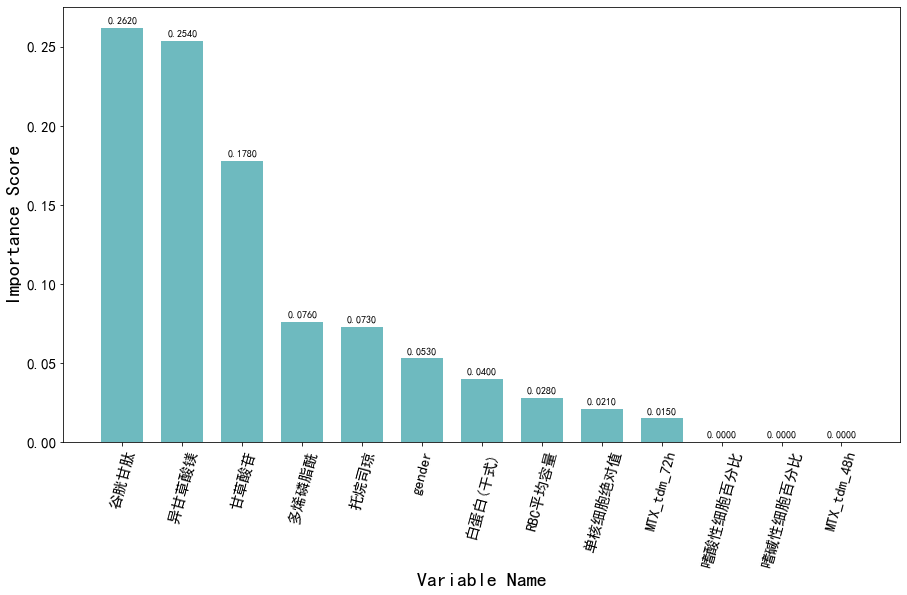

In [1189]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

names = df_importance['特征']
index = np.arange(len(names))
plt.figure(figsize=(15, 8))
plt.bar(df_importance['特征'], df_importance['重要性评分'], width=0.7,
        color=(0.42941176470588235, 0.7294117647058823, 0.7490196078431373), tick_label=names)
plt.xticks(rotation=75)
# 设置坐标刻度值的大小
plt.tick_params(labelsize=15)

plt.ylabel('Importance Score',fontsize=20)
plt.xlabel('Variable Name',fontsize=20)
for a, b in zip(index, df_importance['重要性评分']):
    plt.text(a, b + 0.002, '%.4f' % b, ha='center', va='bottom', fontsize=10)
# plt.title('重要变量得分柱形图')
# plt.show()

### 散点图

In [51]:
# 判断文件路径是否存在，如果不存在则创建该路径
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:  # 判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(path)  # makedirs 创建文件时如果路径不存在会创建这个路径

In [ ]:
# 画图
print('-----------------------画图---------------------------')
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

# 散点图
# axis设置坐标轴的范围
# plt.axis([-20, 20, 0, 200])
# x为x轴中坐标x的值，y为y轴中坐标y的值，x与y都是长度相同的数组序列，color为点的颜色，marker为散点的形状，
# 折线图刻度调小，要不然点都堆到一块了
ax = plt.gca()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
# plt.scatter(range(len(test_y)),test_y,c='r')
plt.scatter(test_y,predictions,c='b')
# 红色参照线
plt.plot(list(range(test_y.shape[0])), list(range(test_y.shape[0])),color='r')
# plt.plot(list(range(30)), list(range(30)),color='r')
plt.xlabel('Number of Events(unit)')
plt.ylabel('MTX Bone Suppression')

In [52]:
# plt.show()
# 判断图片保存路径是否存在，否则创建
jpg_path = project_path + "/jpg"
mkdir(jpg_path)
plt.savefig(jpg_path + "/他克莫司血药浓度测试集散点图v2.0.jpg", dpi=300)
plt.clf()  # 删除前面所画的图

-----------------------画图---------------------------


<Figure size 432x288 with 0 Axes>

### AUC曲线

In [56]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

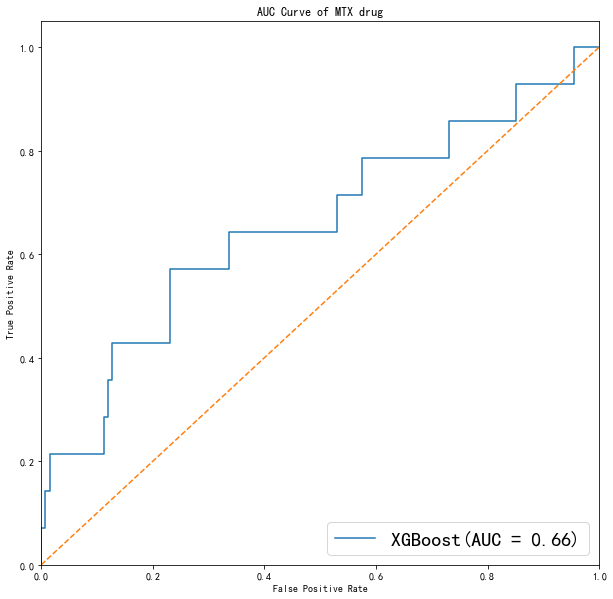

In [87]:
plt.figure(figsize=(10,10))

# plt.plot(logistic_fpr, logistic_tpr,label='LogisticRegression(AUC = %0.2f)' % logistic_auc) 
# plt.plot(rf_fpr, rf_tpr,label='RandomForest(AUC = %0.2f)' % rf_auc) 
plt.plot(xgb_fpr, xgb_tpr,label='XGBoost(AUC = %0.2f)' % xgb_auc) 
# plt.plot(ann_fpr, ann_tpr,label='ANN(AUC = %0.2f)' % ann_auc) 

plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve of MTX drug')
plt.legend(loc="lower right", fontsize=20)
plt.show()

### precision曲线

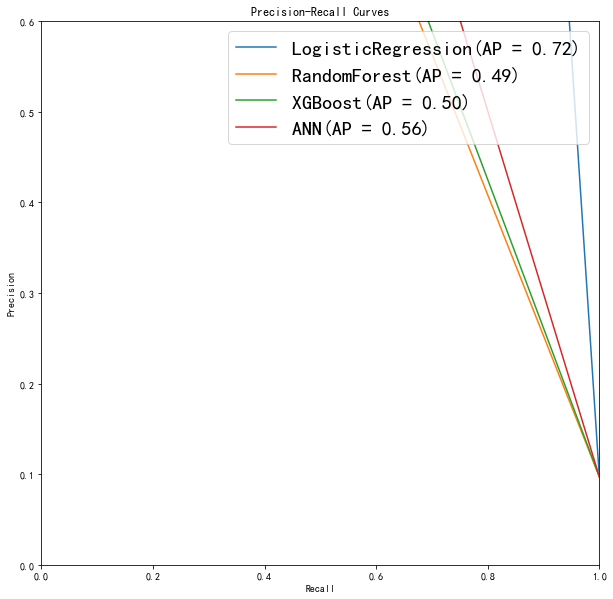

In [57]:
plt.figure(figsize=(10,10))

plt.plot(logistic_recall, logistic_precision, label='LogisticRegression(AP = %0.2f)' % logistic_ap)
plt.plot(rf_recall, rf_precision,label='RandomForest(AP = %0.2f)' % rf_ap) 
plt.plot(xgb_recall, xgb_precision,label='XGBoost(AP = %0.2f)' % xgb_ap) 
plt.plot(ann_recall, ann_precision,label='ANN(AP = %0.2f)' % ann_ap) 
         
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.6])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right", fontsize=20)
plt.show()

### SHAP图

In [292]:
?shap.initjs() 

Object `shap.initjs() ` not found.


In [297]:
# SHAP图
from pylab import mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib import rc
rc('mathtext', default='regular')

import catboost,xgboost
from catboost import *
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码
# xgb_model=xgboost.XGBClassifier(max_depth=5,
#                         learning_rate=0.01,
#                         n_estimators=500,
#                         min_child_weight=0.5,
#                         eta=0.1,
#                         gamma=0.5,
#                         reg_lambda=10,
#                         subsample=0.5,
#                         colsample_bytree=0.8,
#                         nthread=4,
#                         scale_pos_weight=1,
#                         random_state=3)
# xgb_model.fit(tran_x_sm, tran_y_sm)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(tran_x_sm)  # 传入特征矩阵X，计算SHAP值
# print(shap_values)

Device used : cpu
epoch 0  | loss: 0.75528 | train_auc: 0.63881 |  0:00:00s
epoch 1  | loss: 0.59836 | train_auc: 0.92063 |  0:00:00s
epoch 2  | loss: 0.56821 | train_auc: 0.91119 |  0:00:00s
epoch 3  | loss: 0.50365 | train_auc: 0.96853 |  0:00:00s
epoch 4  | loss: 0.45512 | train_auc: 0.94126 |  0:00:01s
epoch 5  | loss: 0.41852 | train_auc: 0.92727 |  0:00:01s
epoch 6  | loss: 0.43255 | train_auc: 0.94441 |  0:00:01s
epoch 7  | loss: 0.40222 | train_auc: 0.94545 |  0:00:01s
epoch 8  | loss: 0.36702 | train_auc: 0.91993 |  0:00:02s
epoch 9  | loss: 0.35444 | train_auc: 0.96294 |  0:00:02s
epoch 10 | loss: 0.36125 | train_auc: 0.97343 |  0:00:02s
epoch 11 | loss: 0.3187  | train_auc: 0.97203 |  0:00:02s
epoch 12 | loss: 0.28125 | train_auc: 0.97098 |  0:00:03s
epoch 13 | loss: 0.2984  | train_auc: 0.98427 |  0:00:03s
epoch 14 | loss: 0.27376 | train_auc: 0.98147 |  0:00:03s
epoch 15 | loss: 0.23633 | train_auc: 0.97028 |  0:00:03s
epoch 16 | loss: 0.24844 | train_auc: 0.97063 |  0:00:

AssertionError: <class 'pytorch_tabnet.tab_model.TabNetClassifier'> is not currently a supported model type!

In [295]:
# summarize the effects of all the features
shap.summary_plot(shap_values, tran_x_sm, plot_size=(27,20))

Device used : cpu
epoch 0  | loss: 0.75528 | train_auc: 0.63881 |  0:00:00s
epoch 1  | loss: 0.59836 | train_auc: 0.92063 |  0:00:00s
epoch 2  | loss: 0.56821 | train_auc: 0.91119 |  0:00:00s
epoch 3  | loss: 0.50365 | train_auc: 0.96853 |  0:00:00s
epoch 4  | loss: 0.45512 | train_auc: 0.94126 |  0:00:01s
epoch 5  | loss: 0.41852 | train_auc: 0.92727 |  0:00:01s
epoch 6  | loss: 0.43255 | train_auc: 0.94441 |  0:00:01s
epoch 7  | loss: 0.40222 | train_auc: 0.94545 |  0:00:01s
epoch 8  | loss: 0.36702 | train_auc: 0.91993 |  0:00:02s
epoch 9  | loss: 0.35444 | train_auc: 0.96294 |  0:00:02s
epoch 10 | loss: 0.36125 | train_auc: 0.97343 |  0:00:02s
epoch 11 | loss: 0.3187  | train_auc: 0.97203 |  0:00:02s
epoch 12 | loss: 0.28125 | train_auc: 0.97098 |  0:00:03s
epoch 13 | loss: 0.2984  | train_auc: 0.98427 |  0:00:03s
epoch 14 | loss: 0.27376 | train_auc: 0.98147 |  0:00:03s
epoch 15 | loss: 0.23633 | train_auc: 0.97028 |  0:00:03s
epoch 16 | loss: 0.24844 | train_auc: 0.97063 |  0:00:

AssertionError: <class 'pytorch_tabnet.tab_model.TabNetClassifier'> is not currently a supported model type!

In [148]:
# 保存各个变量的shape值的和
df_shap_values=pd.DataFrame(shap_values)
shap_list=[]
shap_pos_list=[]
patient_pos_list=[]
shap_neg_list=[]
patient_neg_list=[]

for j in range(df_shap_values.shape[1]):
    temp=df_shap_values.iloc[:,j]
    df_temp=pd.DataFrame(data={'values':temp})
    # 正shap值
    df_shap_pos=df_temp[df_temp['values']>=0]
    shap_pos_list.append(df_shap_pos.values.sum())
    # 正shap患者数
    patient_pos_list.append(df_shap_pos.shape[0])
    # 负shap值
    df_shap_neg=df_temp[df_temp['values']<0]
    shap_neg_list.append(df_shap_neg.values.sum())
    # 负sahp患者数
    patient_neg_list.append(df_shap_neg.shape[0])
    # shap和
    shap_sum = temp.sum()
    shap_sum = round(shap_sum, 2)
    shap_list.append(shap_sum)

df_shap = pd.DataFrame({'features':list(tran_x.columns),
                        'shap值':shap_list,
                        '正患者数':patient_pos_list,
                       'shap_pos':shap_pos_list,
                        '负患者数':patient_neg_list,
                       'shap_neg':shap_neg_list})
df_shap = df_shap.sort_values(by=['shap值'], ascending=False)
df_shap = df_shap.reset_index(drop=True)

In [149]:
df_shap_values

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.493114,0.013439,0.212330,0.161205,-0.017556,0.127539,-0.066257,-0.018847,0.035362,0.023770,...,0.007541,-0.026841,-0.004471,0.007767,-0.002491,-0.011834,0.051021,-0.006103,0.0,0.000336
1,-0.465787,-0.204204,0.057564,-0.128542,0.002040,0.081842,-0.074861,-0.015492,0.023511,-0.013714,...,0.000296,0.020651,-0.007464,0.125231,-0.023509,-0.015810,-0.031778,0.005809,0.0,-0.005455
2,0.333714,-0.009154,0.113778,-0.262280,0.002901,-0.279201,-0.040720,-0.016642,0.002133,-0.016595,...,-0.004984,-0.034450,-0.010802,0.002106,0.001951,-0.010774,-0.032060,-0.010410,0.0,-0.004721
3,0.361266,-0.226927,0.129515,-0.337756,0.004688,0.087664,-0.070344,0.009610,-0.003264,-0.021443,...,0.002200,-0.004920,-0.008501,0.001250,-0.019360,-0.017627,-0.024562,-0.019865,0.0,-0.001508
4,-0.385250,-0.162730,0.044208,-0.098532,0.001598,-0.142825,-0.016146,-0.012490,-0.002583,-0.007621,...,0.005418,-0.022117,-0.001664,-0.017059,-0.026260,-0.013795,0.020640,-0.019700,0.0,-0.004067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,-0.547174,0.519316,0.064741,0.055347,0.002658,-0.197009,0.254998,-0.011823,-0.007559,-0.006645,...,-0.006296,0.025902,-0.004314,-0.002442,-0.021549,-0.012578,0.015023,-0.013855,0.0,-0.001509
570,-0.383122,-0.161732,0.049291,-0.106437,0.001931,-0.191388,-0.042469,-0.014820,-0.007851,0.014002,...,-0.002495,-0.009965,-0.009123,-0.002402,0.087126,-0.011996,-0.033185,-0.001849,0.0,-0.002297
571,-0.502401,-0.162989,0.058127,0.050063,0.002189,-0.214503,-0.059646,0.030141,0.003770,0.011629,...,-0.002717,-0.030359,0.075569,0.016345,0.083354,-0.010346,0.012017,-0.002183,0.0,-0.001201
572,-0.410083,-0.185747,0.052042,-0.125258,0.002029,0.080268,-0.071100,0.036042,-0.019607,-0.015195,...,-0.004088,0.018902,-0.017878,-0.025403,-0.020374,0.006123,0.017941,-0.017112,0.0,-0.003338


In [150]:
writer = pd.ExcelWriter(project_path + '/data/result/df_27变量_shap值排序.xlsx')
df_shap.to_excel(writer)
writer.save()

### tabnet mask graph

In [299]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier()  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.1, random_state=3)

TabNet_model.fit(X_train=tran_x_x.to_numpy(),  
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100,
        patience=15,
        batch_size=128,
        virtual_batch_size=15,
        num_workers=0,
        drop_last=False)

Device used : cpu
epoch 0  | loss: 0.75528 | train_auc: 0.63881 |  0:00:00s
epoch 1  | loss: 0.59836 | train_auc: 0.92063 |  0:00:00s
epoch 2  | loss: 0.56821 | train_auc: 0.91119 |  0:00:00s
epoch 3  | loss: 0.50365 | train_auc: 0.96853 |  0:00:01s
epoch 4  | loss: 0.45512 | train_auc: 0.94126 |  0:00:01s
epoch 5  | loss: 0.41852 | train_auc: 0.92727 |  0:00:01s
epoch 6  | loss: 0.43255 | train_auc: 0.94441 |  0:00:01s
epoch 7  | loss: 0.40222 | train_auc: 0.94545 |  0:00:02s
epoch 8  | loss: 0.36702 | train_auc: 0.91993 |  0:00:02s
epoch 9  | loss: 0.35444 | train_auc: 0.96294 |  0:00:02s
epoch 10 | loss: 0.36125 | train_auc: 0.97343 |  0:00:02s
epoch 11 | loss: 0.3187  | train_auc: 0.97203 |  0:00:02s
epoch 12 | loss: 0.28125 | train_auc: 0.97098 |  0:00:03s
epoch 13 | loss: 0.2984  | train_auc: 0.98427 |  0:00:03s
epoch 14 | loss: 0.27376 | train_auc: 0.98147 |  0:00:03s
epoch 15 | loss: 0.23633 | train_auc: 0.97028 |  0:00:03s
epoch 16 | loss: 0.24844 | train_auc: 0.97063 |  0:00:

In [1190]:
explain_matrix,masks=TabNet_model.explain(tran_x_sm.to_numpy())

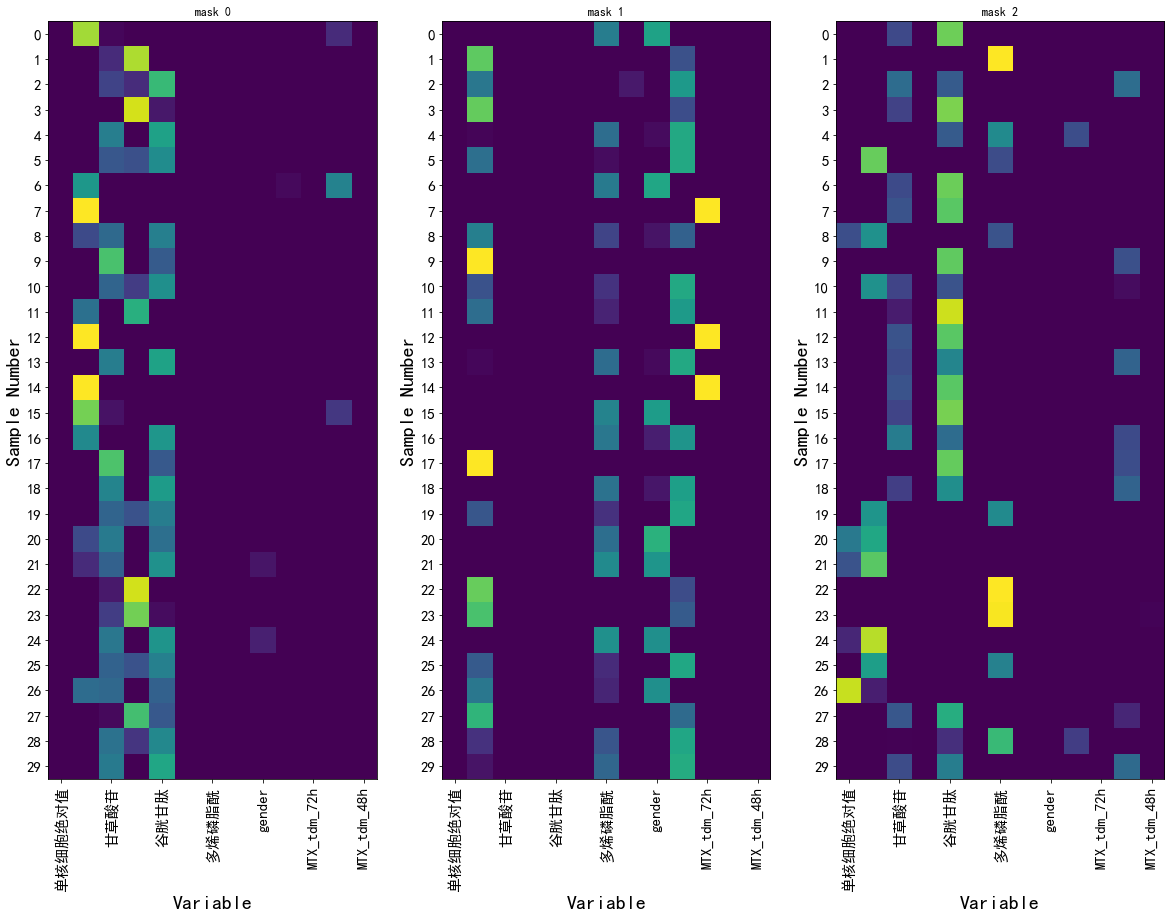

In [1191]:
from matplotlib import pyplot as plt
# fig = plt.figure(figsize=(40,40))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plt.yticks(np.arange(0, len(explain_matrix), 1.0))
# plt.xticks(np.arange(0, len(explain_matrix[0]), 1.0))
# ax.set_xticklabels(tran_x_sm.columns, rotation=75)
# plt.ylabel('Sample Number')
# plt.xlabel('Variable')
# # plt.imshow(explain_matrix[:30])  # 显示30个

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].set_yticks(np.arange(0, len(explain_matrix), 1.0))  # 设置左边间距
    axs[i].set_xticks(np.arange(0, len(explain_matrix[0]), 2.0))
    axs[i].set_ylabel('Sample Number',size=20)
    axs[i].set_xlabel('Variable',size=20)
    # 设置坐标刻度值的大小
    axs[i].tick_params(labelsize=15)
    axs[i].imshow(masks[i][:30])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(tran_x_sm.columns[::2], rotation=90)

In [351]:
tran_x_sm.columns

Index(['单核细胞绝对值', '异甘草酸镁', '谷草转氨酶(干式)', '甘草酸苷', '单核细胞百分比', '淋巴细胞百分比',
       '乳酸脱氢酶(干式)', '托烷司琼', '中性细胞绝对值', '嗜酸性细胞绝对值', '谷胱甘肽', '红细胞', '嗜酸性细胞百分比',
       '多烯磷脂酰', '嗜碱性细胞百分比', 'age', 'gender', 'RBC平均容量', 'MTX_tdm_72h',
       '白蛋白(干式)', '中性细胞百分比', 'MTX_tdm_48h', '总蛋白(干式)', '淋巴细胞绝对值', '吸烟史',
       '肌酐(干式)', 'MTX_tdm_24h', '日剂量', '长春新碱', 'RBC血红浓度'],
      dtype='object')